In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 1024
hidden_1 = 1024
hidden_2 = 1024
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=4, min_val=-8.0, max_val=7.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.relu0 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.relu1 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.relu2 = qnn.QuantReLU(bit_width=4, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=4, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.relu0(self.bn0(self.fc0(out))))
        out = self.drop1(self.relu1(self.bn1(self.fc1(out))))
        out = self.drop2(self.relu2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2948, Acc: 0.9148 | Val Loss: 0.1626, Acc: 0.9513


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9603 | Val Loss: 0.1445, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9689 | Val Loss: 0.0997, Acc: 0.9706


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9759 | Val Loss: 0.1040, Acc: 0.9684


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9790 | Val Loss: 0.1048, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9817 | Val Loss: 0.1021, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9833 | Val Loss: 0.0926, Acc: 0.9746


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.0990, Acc: 0.9714


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9870 | Val Loss: 0.0977, Acc: 0.9739


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.1100, Acc: 0.9699


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1135, Acc: 0.9709


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0950, Acc: 0.9742


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0982, Acc: 0.9751


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9905 | Val Loss: 0.1090, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.1053, Acc: 0.9756


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.1054, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.1027, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0999, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1264, Acc: 0.9755


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1210, Acc: 0.9756


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1286, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1251, Acc: 0.9765


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1138, Acc: 0.9762


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.1232, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1102, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1094, Acc: 0.9787


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.1299, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9940 | Val Loss: 0.1096, Acc: 0.9773


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1116, Acc: 0.9751


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1455, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1332, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1409, Acc: 0.9732


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1201, Acc: 0.9743


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0973, Acc: 0.9766


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1442, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1015, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1671, Acc: 0.9735


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1367, Acc: 0.9756


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1301, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1287, Acc: 0.9730


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1218, Acc: 0.9777


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1333, Acc: 0.9754


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0865, Acc: 0.9754


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.1292, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1083, Acc: 0.9739


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1334, Acc: 0.9769


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1198, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1414, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0998, Acc: 0.9769


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.1435, Acc: 0.9753


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1407, Acc: 0.9747


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1586, Acc: 0.9766


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1548, Acc: 0.9734


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9967 | Val Loss: 0.1316, Acc: 0.9758


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1166, Acc: 0.9752


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1353, Acc: 0.9772


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0993, Acc: 0.9753


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1293, Acc: 0.9768


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0879, Acc: 0.9772


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1364, Acc: 0.9740


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1449, Acc: 0.9741


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1379, Acc: 0.9758


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1380, Acc: 0.9761


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0967, Acc: 0.9760


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1208, Acc: 0.9761


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1239, Acc: 0.9747


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1083, Acc: 0.9771


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0860, Acc: 0.9766


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1403, Acc: 0.9782


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1347, Acc: 0.9764


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1154, Acc: 0.9769


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1127, Acc: 0.9757


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1735, Acc: 0.9749


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1659, Acc: 0.9750


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1397, Acc: 0.9772


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0831, Acc: 0.9753


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1710, Acc: 0.9755


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1243, Acc: 0.9757


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0910, Acc: 0.9759


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1486, Acc: 0.9764


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.1310, Acc: 0.9773


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1747, Acc: 0.9749


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1778, Acc: 0.9785


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1316, Acc: 0.9778


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1174, Acc: 0.9770


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1346, Acc: 0.9752


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1382, Acc: 0.9758


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1454, Acc: 0.9769


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1114, Acc: 0.9767


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1578, Acc: 0.9756


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1624, Acc: 0.9752


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1566, Acc: 0.9763


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1426, Acc: 0.9776


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1394, Acc: 0.9773


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1460, Acc: 0.9755


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1445, Acc: 0.9768


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1046, Acc: 0.9774


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1398, Acc: 0.9772


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1434, Acc: 0.9768


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1220, Acc: 0.9763


Final Test Loss: 0.1158 Accuracy: 0.9767


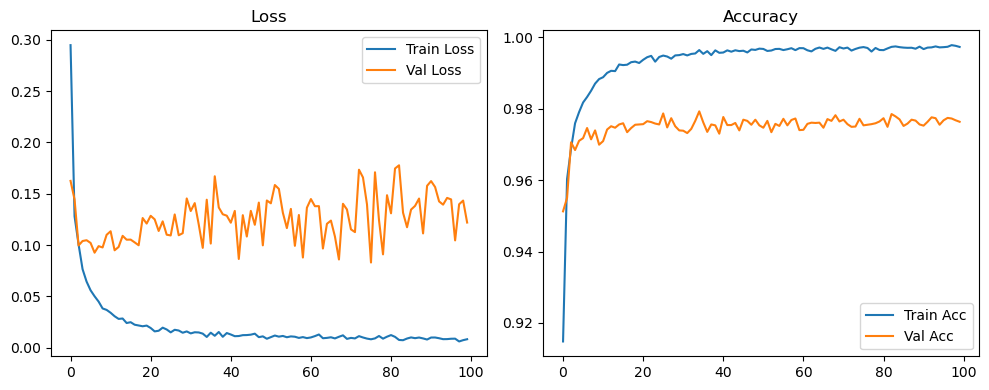

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3213, Acc: 0.9087 | Val Loss: 0.1540, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1554, Acc: 0.9534 | Val Loss: 0.1255, Acc: 0.9621


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1178, Acc: 0.9635 | Val Loss: 0.1019, Acc: 0.9692


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9691 | Val Loss: 0.1049, Acc: 0.9675


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9719 | Val Loss: 0.0930, Acc: 0.9721


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9756 | Val Loss: 0.1094, Acc: 0.9694


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9782 | Val Loss: 0.0971, Acc: 0.9734


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9804 | Val Loss: 0.0854, Acc: 0.9749


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9825 | Val Loss: 0.0912, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9821 | Val Loss: 0.0968, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9838 | Val Loss: 0.1042, Acc: 0.9713


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0911, Acc: 0.9736


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9850 | Val Loss: 0.0943, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0961, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.0921, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9867 | Val Loss: 0.0943, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.0869, Acc: 0.9788


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.0870, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.0839, Acc: 0.9766


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.0905, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.1045, Acc: 0.9772


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0907, Acc: 0.9767


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.1046, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.0757, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.0998, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.1049, Acc: 0.9764


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0977, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9902 | Val Loss: 0.1218, Acc: 0.9757


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.1038, Acc: 0.9771


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0904, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.0904, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.1043, Acc: 0.9781


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0956, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.1054, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0793, Acc: 0.9776


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.0907, Acc: 0.9777


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.1031, Acc: 0.9766


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.1120, Acc: 0.9765


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.0874, Acc: 0.9775


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.0929, Acc: 0.9794


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0793, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1249, Acc: 0.9780


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1131, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0904, Acc: 0.9781


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0775, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0819, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.1067, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.1005, Acc: 0.9788


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.1392, Acc: 0.9782


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1083, Acc: 0.9780


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9931 | Val Loss: 0.0997, Acc: 0.9788


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.0944, Acc: 0.9795


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.1049, Acc: 0.9779


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.0929, Acc: 0.9784


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.0811, Acc: 0.9786


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0921, Acc: 0.9787


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0839, Acc: 0.9783


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9930 | Val Loss: 0.0909, Acc: 0.9783


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0839, Acc: 0.9779


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9933 | Val Loss: 0.0954, Acc: 0.9782


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.1066, Acc: 0.9771


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.0976, Acc: 0.9785


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.1096, Acc: 0.9781


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9926 | Val Loss: 0.1004, Acc: 0.9770


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0913, Acc: 0.9778


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.0817, Acc: 0.9794


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1202, Acc: 0.9772


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9934 | Val Loss: 0.0910, Acc: 0.9770


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9928 | Val Loss: 0.1402, Acc: 0.9771


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.1155, Acc: 0.9778


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9935 | Val Loss: 0.1109, Acc: 0.9772


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9927 | Val Loss: 0.1129, Acc: 0.9767


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.1164, Acc: 0.9787


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0999, Acc: 0.9772


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.0912, Acc: 0.9762


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.1049, Acc: 0.9778


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1346, Acc: 0.9772


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.1258, Acc: 0.9762


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.1179, Acc: 0.9788


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9936 | Val Loss: 0.1185, Acc: 0.9786


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9938 | Val Loss: 0.1183, Acc: 0.9789


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.1369, Acc: 0.9788


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.1526, Acc: 0.9789


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9931 | Val Loss: 0.1223, Acc: 0.9791


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9924 | Val Loss: 0.0891, Acc: 0.9778


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0864, Acc: 0.9788


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0991, Acc: 0.9782


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0981, Acc: 0.9796


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.1306, Acc: 0.9778


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.1006, Acc: 0.9782


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.1044, Acc: 0.9769


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.1123, Acc: 0.9797


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0877, Acc: 0.9800


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9939 | Val Loss: 0.0896, Acc: 0.9794


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.1327, Acc: 0.9779


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9934 | Val Loss: 0.0924, Acc: 0.9785


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.1172, Acc: 0.9767


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.1163, Acc: 0.9773


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1193, Acc: 0.9788


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9940 | Val Loss: 0.1774, Acc: 0.9780


Final Test Loss: 0.1357 Accuracy: 0.9804


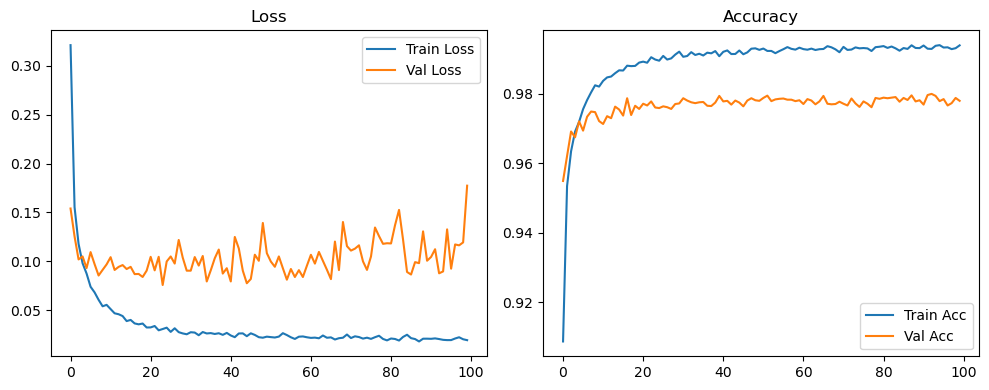

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4074, Acc: 0.8855 | Val Loss: 0.1541, Acc: 0.9522


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2028, Acc: 0.9388 | Val Loss: 0.1256, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1752, Acc: 0.9464 | Val Loss: 0.1153, Acc: 0.9651


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1561, Acc: 0.9514 | Val Loss: 0.1234, Acc: 0.9654


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9544 | Val Loss: 0.0959, Acc: 0.9708


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9584 | Val Loss: 0.0955, Acc: 0.9700


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1311, Acc: 0.9599 | Val Loss: 0.1177, Acc: 0.9714


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9625 | Val Loss: 0.1011, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9635 | Val Loss: 0.0880, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1169, Acc: 0.9639 | Val Loss: 0.0881, Acc: 0.9737


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1073, Acc: 0.9667 | Val Loss: 0.0905, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1066, Acc: 0.9669 | Val Loss: 0.0913, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9673 | Val Loss: 0.0950, Acc: 0.9731


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9673 | Val Loss: 0.1046, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1052, Acc: 0.9672 | Val Loss: 0.0879, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0989, Acc: 0.9692 | Val Loss: 0.0977, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9693 | Val Loss: 0.0923, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9701 | Val Loss: 0.0910, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0963, Acc: 0.9700 | Val Loss: 0.0804, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0970, Acc: 0.9697 | Val Loss: 0.0798, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0921, Acc: 0.9712 | Val Loss: 0.1005, Acc: 0.9750


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9707 | Val Loss: 0.0866, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9730 | Val Loss: 0.0885, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9705 | Val Loss: 0.0811, Acc: 0.9738


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9712 | Val Loss: 0.0922, Acc: 0.9749


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9704 | Val Loss: 0.0851, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9709 | Val Loss: 0.0909, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9720 | Val Loss: 0.1007, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9714 | Val Loss: 0.0810, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0886, Acc: 0.9720 | Val Loss: 0.0963, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9730 | Val Loss: 0.0811, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9730 | Val Loss: 0.1011, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9745 | Val Loss: 0.0792, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9720 | Val Loss: 0.0826, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9740 | Val Loss: 0.0849, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9722 | Val Loss: 0.0788, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.1091, Acc: 0.9756


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9744 | Val Loss: 0.0898, Acc: 0.9755


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9734 | Val Loss: 0.1006, Acc: 0.9772


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9726 | Val Loss: 0.0921, Acc: 0.9762


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9750 | Val Loss: 0.0892, Acc: 0.9741


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9740 | Val Loss: 0.0821, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0873, Acc: 0.9724 | Val Loss: 0.0991, Acc: 0.9764


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9733 | Val Loss: 0.0770, Acc: 0.9763


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9750 | Val Loss: 0.0840, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9741 | Val Loss: 0.0966, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9736 | Val Loss: 0.0820, Acc: 0.9757


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9750 | Val Loss: 0.0763, Acc: 0.9761


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9741 | Val Loss: 0.0914, Acc: 0.9781


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9736 | Val Loss: 0.0820, Acc: 0.9769


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9745 | Val Loss: 0.0929, Acc: 0.9749


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0828, Acc: 0.9744 | Val Loss: 0.0895, Acc: 0.9772


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9742 | Val Loss: 0.0859, Acc: 0.9773


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9733 | Val Loss: 0.0770, Acc: 0.9762


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0814, Acc: 0.9750 | Val Loss: 0.0769, Acc: 0.9763


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0852, Acc: 0.9741 | Val Loss: 0.0815, Acc: 0.9762


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9754 | Val Loss: 0.0962, Acc: 0.9780


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9755 | Val Loss: 0.0950, Acc: 0.9768


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.0792, Acc: 0.9763


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9764 | Val Loss: 0.0760, Acc: 0.9767


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0780, Acc: 0.9754 | Val Loss: 0.0776, Acc: 0.9775


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9755 | Val Loss: 0.0734, Acc: 0.9775


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9750 | Val Loss: 0.0864, Acc: 0.9767


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0789, Acc: 0.9756 | Val Loss: 0.0772, Acc: 0.9774


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9755 | Val Loss: 0.0786, Acc: 0.9754


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0764, Acc: 0.9762 | Val Loss: 0.0893, Acc: 0.9761


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0771, Acc: 0.9759 | Val Loss: 0.0795, Acc: 0.9762


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0811, Acc: 0.9752 | Val Loss: 0.0757, Acc: 0.9773


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9758 | Val Loss: 0.0749, Acc: 0.9776


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0794, Acc: 0.9757 | Val Loss: 0.0880, Acc: 0.9775


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0806, Acc: 0.9757 | Val Loss: 0.0911, Acc: 0.9771


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0776, Acc: 0.9756 | Val Loss: 0.0842, Acc: 0.9768


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0769, Acc: 0.9762 | Val Loss: 0.0744, Acc: 0.9779


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9767 | Val Loss: 0.0819, Acc: 0.9774


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0696, Acc: 0.9781 | Val Loss: 0.0796, Acc: 0.9775


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0736, Acc: 0.9768 | Val Loss: 0.1039, Acc: 0.9761


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0749, Acc: 0.9761 | Val Loss: 0.0868, Acc: 0.9774


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9753 | Val Loss: 0.0813, Acc: 0.9752


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0819, Acc: 0.9748 | Val Loss: 0.0841, Acc: 0.9770


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0799, Acc: 0.9752 | Val Loss: 0.0784, Acc: 0.9782


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0734, Acc: 0.9769 | Val Loss: 0.0757, Acc: 0.9772


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9771 | Val Loss: 0.0845, Acc: 0.9781


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0742, Acc: 0.9775 | Val Loss: 0.0981, Acc: 0.9769


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9769 | Val Loss: 0.0745, Acc: 0.9774


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0765, Acc: 0.9765 | Val Loss: 0.0868, Acc: 0.9782


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0755, Acc: 0.9768 | Val Loss: 0.0769, Acc: 0.9769


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9758 | Val Loss: 0.0916, Acc: 0.9768


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9783 | Val Loss: 0.0771, Acc: 0.9772


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0759, Acc: 0.9765 | Val Loss: 0.0758, Acc: 0.9761


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0728, Acc: 0.9768 | Val Loss: 0.0812, Acc: 0.9773


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0775, Acc: 0.9758 | Val Loss: 0.0982, Acc: 0.9762


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9769 | Val Loss: 0.0836, Acc: 0.9770


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0757, Acc: 0.9767 | Val Loss: 0.0765, Acc: 0.9773


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9782 | Val Loss: 0.0838, Acc: 0.9772


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0717, Acc: 0.9786 | Val Loss: 0.0766, Acc: 0.9765


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0724, Acc: 0.9779 | Val Loss: 0.0838, Acc: 0.9781


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0745, Acc: 0.9771 | Val Loss: 0.0935, Acc: 0.9776


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0733, Acc: 0.9771 | Val Loss: 0.1034, Acc: 0.9782


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0772, Acc: 0.9764 | Val Loss: 0.0743, Acc: 0.9785


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9770 | Val Loss: 0.1009, Acc: 0.9773


Final Test Loss: 0.0866 Accuracy: 0.9815


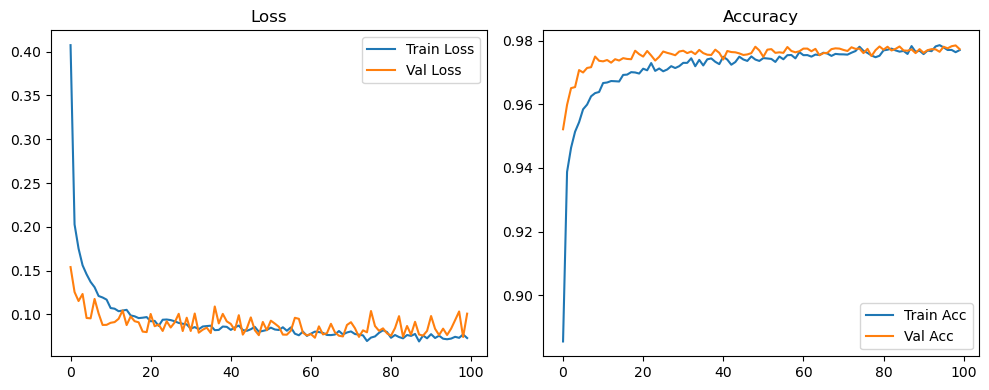

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2948, Acc: 0.9148 | Val Loss: 0.1626, Acc: 0.9513


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9603 | Val Loss: 0.1445, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9689 | Val Loss: 0.0997, Acc: 0.9706


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9759 | Val Loss: 0.1040, Acc: 0.9684


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9790 | Val Loss: 0.1048, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9817 | Val Loss: 0.1021, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9833 | Val Loss: 0.0926, Acc: 0.9746


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.0990, Acc: 0.9714


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9870 | Val Loss: 0.0977, Acc: 0.9739


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.1100, Acc: 0.9699


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1135, Acc: 0.9709


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0950, Acc: 0.9742


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0982, Acc: 0.9751


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9905 | Val Loss: 0.1090, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.1053, Acc: 0.9756


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.1054, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.1027, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0999, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1264, Acc: 0.9755


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1210, Acc: 0.9756


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1286, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1251, Acc: 0.9765


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1138, Acc: 0.9762


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.1232, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1102, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1094, Acc: 0.9787


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.1299, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9940 | Val Loss: 0.1096, Acc: 0.9773


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1116, Acc: 0.9751


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1455, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1332, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1409, Acc: 0.9732


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1201, Acc: 0.9743


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0973, Acc: 0.9766


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1442, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1015, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1671, Acc: 0.9735


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1367, Acc: 0.9756


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1301, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1287, Acc: 0.9730


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1218, Acc: 0.9777


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1333, Acc: 0.9754


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0865, Acc: 0.9754


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.1292, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1083, Acc: 0.9739


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1334, Acc: 0.9769


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1198, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1414, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0998, Acc: 0.9769


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.1435, Acc: 0.9753


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1403, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1145, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1458, Acc: 0.9790


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1240, Acc: 0.9807


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1188, Acc: 0.9793


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1203, Acc: 0.9768


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1507, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0987, Acc: 0.9788


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1600, Acc: 0.9774


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1511, Acc: 0.9799


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1220, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1169, Acc: 0.9784


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1568, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1780, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1465, Acc: 0.9781


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1764, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1653, Acc: 0.9771


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1476, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1532, Acc: 0.9801


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1577, Acc: 0.9778


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1086, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1239, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1574, Acc: 0.9790


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1021, Acc: 0.9790


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1520, Acc: 0.9773


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1373, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1490, Acc: 0.9764


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1036, Acc: 0.9780


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1778, Acc: 0.9773


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1136, Acc: 0.9780


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1288, Acc: 0.9786


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1711, Acc: 0.9787


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1550, Acc: 0.9790


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1980, Acc: 0.9787


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1196, Acc: 0.9788


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1633, Acc: 0.9785


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1733, Acc: 0.9787


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1646, Acc: 0.9787


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1734, Acc: 0.9790


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1628, Acc: 0.9782


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1944, Acc: 0.9788


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1774, Acc: 0.9782


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1446, Acc: 0.9795


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1214, Acc: 0.9802


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1778, Acc: 0.9796


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1937, Acc: 0.9799


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1646, Acc: 0.9795


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1636, Acc: 0.9806


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1644, Acc: 0.9810


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1604, Acc: 0.9804


Final Test Loss: 0.1574 Accuracy: 0.9810


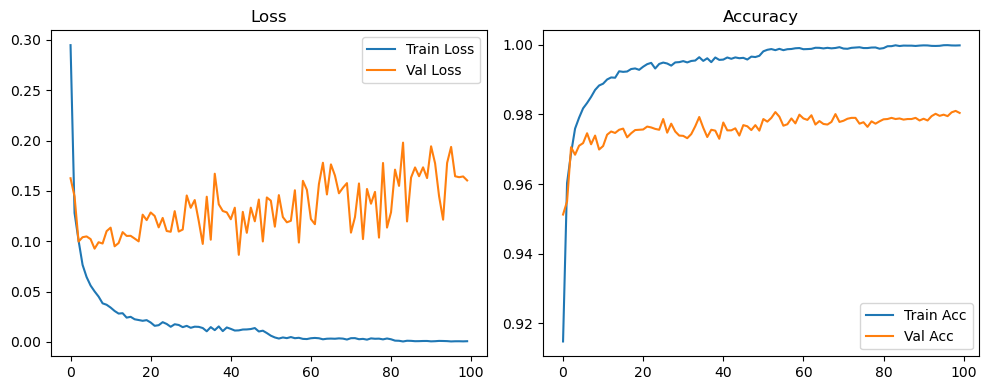

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3213, Acc: 0.9087 | Val Loss: 0.1540, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1554, Acc: 0.9534 | Val Loss: 0.1255, Acc: 0.9621


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1178, Acc: 0.9635 | Val Loss: 0.1019, Acc: 0.9692


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9691 | Val Loss: 0.1049, Acc: 0.9675


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9719 | Val Loss: 0.0930, Acc: 0.9721


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9756 | Val Loss: 0.1094, Acc: 0.9694


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9782 | Val Loss: 0.0971, Acc: 0.9734


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9804 | Val Loss: 0.0854, Acc: 0.9749


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9825 | Val Loss: 0.0912, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9821 | Val Loss: 0.0968, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9838 | Val Loss: 0.1042, Acc: 0.9713


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0911, Acc: 0.9736


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9850 | Val Loss: 0.0943, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0961, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.0921, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9867 | Val Loss: 0.0943, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.0869, Acc: 0.9788


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.0870, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.0839, Acc: 0.9766


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.0905, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.1045, Acc: 0.9772


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0907, Acc: 0.9767


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.1046, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.0757, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.0998, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.1049, Acc: 0.9764


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0977, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9902 | Val Loss: 0.1218, Acc: 0.9757


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.1038, Acc: 0.9771


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0904, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.0904, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.1043, Acc: 0.9781


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0956, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.1054, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0793, Acc: 0.9776


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.0907, Acc: 0.9777


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.1031, Acc: 0.9766


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.1120, Acc: 0.9765


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.0874, Acc: 0.9775


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.0929, Acc: 0.9794


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0793, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1249, Acc: 0.9780


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1131, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0904, Acc: 0.9781


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0775, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0819, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.1067, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.1005, Acc: 0.9788


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.1392, Acc: 0.9782


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1083, Acc: 0.9780


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1170, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0898, Acc: 0.9803


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0939, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0976, Acc: 0.9809


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0872, Acc: 0.9794


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1324, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0903, Acc: 0.9804


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1211, Acc: 0.9791


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0972, Acc: 0.9805


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1245, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0982, Acc: 0.9802


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1361, Acc: 0.9803


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1029, Acc: 0.9813


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1114, Acc: 0.9809


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.0744, Acc: 0.9787


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0755, Acc: 0.9786


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0970, Acc: 0.9803


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1237, Acc: 0.9800


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1145, Acc: 0.9802


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0894, Acc: 0.9811


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0766, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0976, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1107, Acc: 0.9826


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1088, Acc: 0.9802


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1137, Acc: 0.9807


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1112, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1288, Acc: 0.9795


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1082, Acc: 0.9788


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1262, Acc: 0.9800


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1143, Acc: 0.9802


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0987, Acc: 0.9811


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1173, Acc: 0.9800


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1084, Acc: 0.9808


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0895, Acc: 0.9805


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0991, Acc: 0.9815


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1078, Acc: 0.9818


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0910, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1008, Acc: 0.9810


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1247, Acc: 0.9821


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1097, Acc: 0.9800


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0939, Acc: 0.9802


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0930, Acc: 0.9810


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1266, Acc: 0.9808


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1020, Acc: 0.9810


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1168, Acc: 0.9815


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1224, Acc: 0.9816


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1561, Acc: 0.9820


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1211, Acc: 0.9818


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1120, Acc: 0.9819


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1408, Acc: 0.9809


Final Test Loss: 0.1262 Accuracy: 0.9831


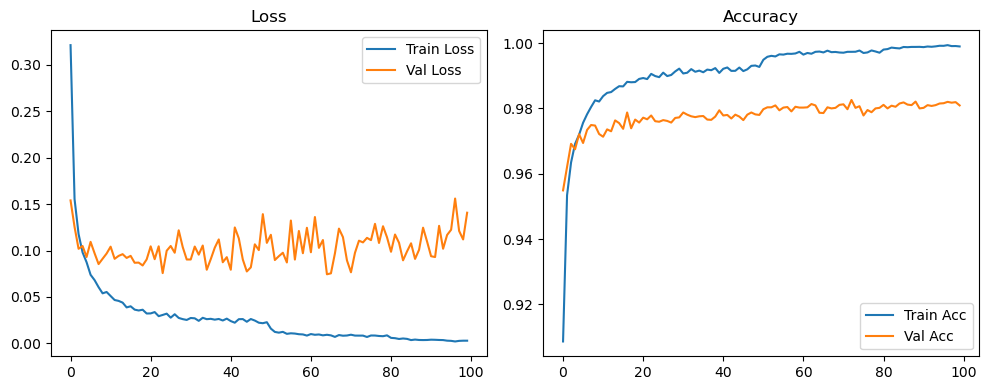

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4074, Acc: 0.8855 | Val Loss: 0.1541, Acc: 0.9522


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2028, Acc: 0.9388 | Val Loss: 0.1256, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1752, Acc: 0.9464 | Val Loss: 0.1153, Acc: 0.9651


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1561, Acc: 0.9514 | Val Loss: 0.1234, Acc: 0.9654


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9544 | Val Loss: 0.0959, Acc: 0.9708


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9584 | Val Loss: 0.0955, Acc: 0.9700


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1311, Acc: 0.9599 | Val Loss: 0.1177, Acc: 0.9714


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9625 | Val Loss: 0.1011, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9635 | Val Loss: 0.0880, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1169, Acc: 0.9639 | Val Loss: 0.0881, Acc: 0.9737


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1073, Acc: 0.9667 | Val Loss: 0.0905, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1066, Acc: 0.9669 | Val Loss: 0.0913, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9673 | Val Loss: 0.0950, Acc: 0.9731


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9673 | Val Loss: 0.1046, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1052, Acc: 0.9672 | Val Loss: 0.0879, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0989, Acc: 0.9692 | Val Loss: 0.0977, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9693 | Val Loss: 0.0923, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9701 | Val Loss: 0.0910, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0963, Acc: 0.9700 | Val Loss: 0.0804, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0970, Acc: 0.9697 | Val Loss: 0.0798, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0921, Acc: 0.9712 | Val Loss: 0.1005, Acc: 0.9750


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9707 | Val Loss: 0.0866, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9730 | Val Loss: 0.0885, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9705 | Val Loss: 0.0811, Acc: 0.9738


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9712 | Val Loss: 0.0922, Acc: 0.9749


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9704 | Val Loss: 0.0851, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9709 | Val Loss: 0.0909, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9720 | Val Loss: 0.1007, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9714 | Val Loss: 0.0810, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0886, Acc: 0.9720 | Val Loss: 0.0963, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9730 | Val Loss: 0.0811, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9730 | Val Loss: 0.1011, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9745 | Val Loss: 0.0792, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9720 | Val Loss: 0.0826, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9740 | Val Loss: 0.0849, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9722 | Val Loss: 0.0788, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.1091, Acc: 0.9756


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9744 | Val Loss: 0.0898, Acc: 0.9755


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9734 | Val Loss: 0.1006, Acc: 0.9772


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9726 | Val Loss: 0.0921, Acc: 0.9762


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9750 | Val Loss: 0.0892, Acc: 0.9741


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9740 | Val Loss: 0.0821, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0873, Acc: 0.9724 | Val Loss: 0.0991, Acc: 0.9764


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9733 | Val Loss: 0.0770, Acc: 0.9763


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9750 | Val Loss: 0.0840, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9741 | Val Loss: 0.0966, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9736 | Val Loss: 0.0820, Acc: 0.9757


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9750 | Val Loss: 0.0763, Acc: 0.9761


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9741 | Val Loss: 0.0914, Acc: 0.9781


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9736 | Val Loss: 0.0820, Acc: 0.9769


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9751 | Val Loss: 0.0787, Acc: 0.9775


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9784 | Val Loss: 0.0790, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9791 | Val Loss: 0.0850, Acc: 0.9783


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0796, Acc: 0.9791


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9807 | Val Loss: 0.0757, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9817 | Val Loss: 0.0735, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9835 | Val Loss: 0.0713, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9828 | Val Loss: 0.0736, Acc: 0.9790


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9832 | Val Loss: 0.0681, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9833 | Val Loss: 0.0734, Acc: 0.9795


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9834 | Val Loss: 0.0795, Acc: 0.9799


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9834 | Val Loss: 0.0653, Acc: 0.9802


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9845 | Val Loss: 0.0809, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 0.0717, Acc: 0.9793


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9852 | Val Loss: 0.0735, Acc: 0.9794


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9858 | Val Loss: 0.0752, Acc: 0.9800


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9860 | Val Loss: 0.0798, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9852 | Val Loss: 0.0711, Acc: 0.9800


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9857 | Val Loss: 0.0754, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9860 | Val Loss: 0.0766, Acc: 0.9807


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0836, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9855 | Val Loss: 0.0726, Acc: 0.9793


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 0.0772, Acc: 0.9811


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.0722, Acc: 0.9798


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9867 | Val Loss: 0.0750, Acc: 0.9805


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9867 | Val Loss: 0.0812, Acc: 0.9807


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.0820, Acc: 0.9804


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.0816, Acc: 0.9806


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.0702, Acc: 0.9809


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0396, Acc: 0.9872 | Val Loss: 0.0749, Acc: 0.9811


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0355, Acc: 0.9884 | Val Loss: 0.0726, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9887 | Val Loss: 0.0866, Acc: 0.9814


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.0747, Acc: 0.9811


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.0862, Acc: 0.9809


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9898 | Val Loss: 0.0998, Acc: 0.9810


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0717, Acc: 0.9809


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9905 | Val Loss: 0.0870, Acc: 0.9808


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0302, Acc: 0.9900 | Val Loss: 0.0763, Acc: 0.9810


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.0909, Acc: 0.9807


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0826, Acc: 0.9812


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.0764, Acc: 0.9811


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0804, Acc: 0.9815


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9911 | Val Loss: 0.0746, Acc: 0.9817


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.0727, Acc: 0.9814


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9914 | Val Loss: 0.0749, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0778, Acc: 0.9814


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9919 | Val Loss: 0.0851, Acc: 0.9812


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0816, Acc: 0.9818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9919 | Val Loss: 0.0791, Acc: 0.9818


Final Test Loss: 0.0708 Accuracy: 0.9830


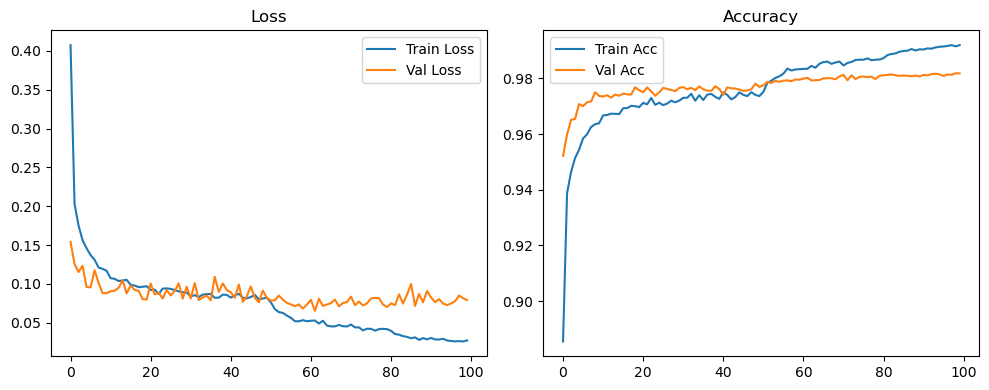

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2948, Acc: 0.9148 | Val Loss: 0.1626, Acc: 0.9513


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9603 | Val Loss: 0.1445, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9689 | Val Loss: 0.0997, Acc: 0.9706


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9759 | Val Loss: 0.1040, Acc: 0.9684


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9790 | Val Loss: 0.1048, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9817 | Val Loss: 0.1021, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9833 | Val Loss: 0.0926, Acc: 0.9746


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.0990, Acc: 0.9714


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9870 | Val Loss: 0.0977, Acc: 0.9739


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.1100, Acc: 0.9699


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1135, Acc: 0.9709


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0950, Acc: 0.9742


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0982, Acc: 0.9751


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9905 | Val Loss: 0.1090, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.1053, Acc: 0.9756


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.1054, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.1027, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0999, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1264, Acc: 0.9755


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1210, Acc: 0.9756


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1286, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1251, Acc: 0.9765


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1138, Acc: 0.9762


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.1232, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1102, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1094, Acc: 0.9787


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.1299, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9940 | Val Loss: 0.1096, Acc: 0.9773


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1116, Acc: 0.9751


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1455, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1332, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1409, Acc: 0.9732


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1201, Acc: 0.9743


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0973, Acc: 0.9766


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1442, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1015, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1671, Acc: 0.9735


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1367, Acc: 0.9756


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1301, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1287, Acc: 0.9730


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1218, Acc: 0.9777


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1333, Acc: 0.9754


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0865, Acc: 0.9754


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.1292, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1083, Acc: 0.9739


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1334, Acc: 0.9769


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1198, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1414, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0998, Acc: 0.9769


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.1435, Acc: 0.9753


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1403, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1145, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1458, Acc: 0.9790


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1240, Acc: 0.9807


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1188, Acc: 0.9793


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1203, Acc: 0.9768


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1507, Acc: 0.9772


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0987, Acc: 0.9788


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1600, Acc: 0.9774


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1511, Acc: 0.9799


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1220, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1169, Acc: 0.9784


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1568, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1780, Acc: 0.9771


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1465, Acc: 0.9781


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1764, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1653, Acc: 0.9771


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1476, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1532, Acc: 0.9801


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1577, Acc: 0.9778


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1086, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1239, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1574, Acc: 0.9790


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1021, Acc: 0.9790


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1520, Acc: 0.9773


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1373, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1490, Acc: 0.9764


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1036, Acc: 0.9780


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1778, Acc: 0.9773


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1136, Acc: 0.9780


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1389, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1517, Acc: 0.9794


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1582, Acc: 0.9787


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1797, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1759, Acc: 0.9791


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1616, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1736, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1644, Acc: 0.9796


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1827, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1868, Acc: 0.9797


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1721, Acc: 0.9785


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2030, Acc: 0.9795


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1580, Acc: 0.9791


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1525, Acc: 0.9791


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1680, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1784, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1534, Acc: 0.9793


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1384, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1734, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2026, Acc: 0.9801


Final Test Loss: 0.1933 Accuracy: 0.9804


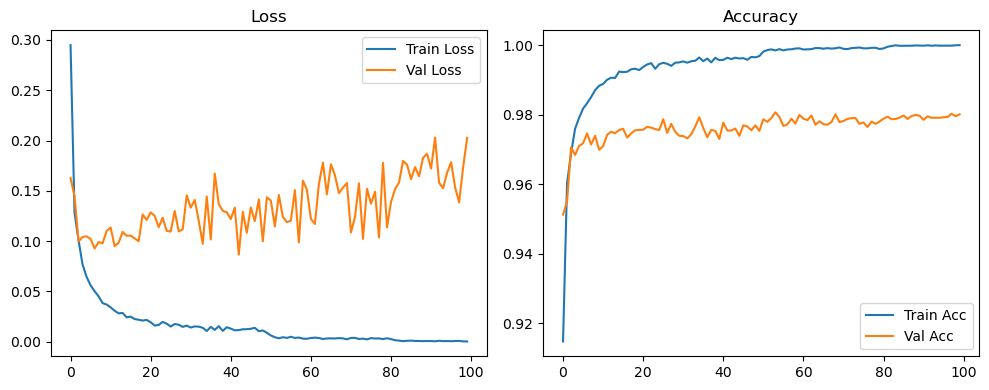

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3213, Acc: 0.9087 | Val Loss: 0.1540, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1554, Acc: 0.9534 | Val Loss: 0.1255, Acc: 0.9621


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1178, Acc: 0.9635 | Val Loss: 0.1019, Acc: 0.9692


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9691 | Val Loss: 0.1049, Acc: 0.9675


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9719 | Val Loss: 0.0930, Acc: 0.9721


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9756 | Val Loss: 0.1094, Acc: 0.9694


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9782 | Val Loss: 0.0971, Acc: 0.9734


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9804 | Val Loss: 0.0854, Acc: 0.9749


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9825 | Val Loss: 0.0912, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9821 | Val Loss: 0.0968, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9838 | Val Loss: 0.1042, Acc: 0.9713


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0911, Acc: 0.9736


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9850 | Val Loss: 0.0943, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0961, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.0921, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9867 | Val Loss: 0.0943, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.0869, Acc: 0.9788


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.0870, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.0839, Acc: 0.9766


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.0905, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.1045, Acc: 0.9772


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0907, Acc: 0.9767


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.1046, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.0757, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.0998, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.1049, Acc: 0.9764


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0977, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9902 | Val Loss: 0.1218, Acc: 0.9757


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.1038, Acc: 0.9771


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0904, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.0904, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.1043, Acc: 0.9781


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0956, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.1054, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0793, Acc: 0.9776


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.0907, Acc: 0.9777


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.1031, Acc: 0.9766


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.1120, Acc: 0.9765


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.0874, Acc: 0.9775


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.0929, Acc: 0.9794


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0793, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1249, Acc: 0.9780


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1131, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0904, Acc: 0.9781


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0775, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0819, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.1067, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.1005, Acc: 0.9788


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.1392, Acc: 0.9782


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1083, Acc: 0.9780


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.1170, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0898, Acc: 0.9803


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0939, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0976, Acc: 0.9809


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0872, Acc: 0.9794


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1324, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0903, Acc: 0.9804


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1211, Acc: 0.9791


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0972, Acc: 0.9805


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1245, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0982, Acc: 0.9802


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1361, Acc: 0.9803


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1029, Acc: 0.9813


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1114, Acc: 0.9809


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.0744, Acc: 0.9787


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0755, Acc: 0.9786


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0970, Acc: 0.9803


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1237, Acc: 0.9800


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1145, Acc: 0.9802


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0894, Acc: 0.9811


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0766, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0976, Acc: 0.9798


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1107, Acc: 0.9826


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1088, Acc: 0.9802


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1137, Acc: 0.9807


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1112, Acc: 0.9778


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1288, Acc: 0.9795


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1082, Acc: 0.9788


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1262, Acc: 0.9800


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1143, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0969, Acc: 0.9808


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1075, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0980, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0980, Acc: 0.9811


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1074, Acc: 0.9809


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1106, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0947, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9987 | Val Loss: 0.1137, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1164, Acc: 0.9815


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1074, Acc: 0.9820


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1133, Acc: 0.9814


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1239, Acc: 0.9817


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1207, Acc: 0.9810


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.0975, Acc: 0.9817


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1215, Acc: 0.9818


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1125, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1313, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1179, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1308, Acc: 0.9825


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1196, Acc: 0.9822


Final Test Loss: 0.1083 Accuracy: 0.9835


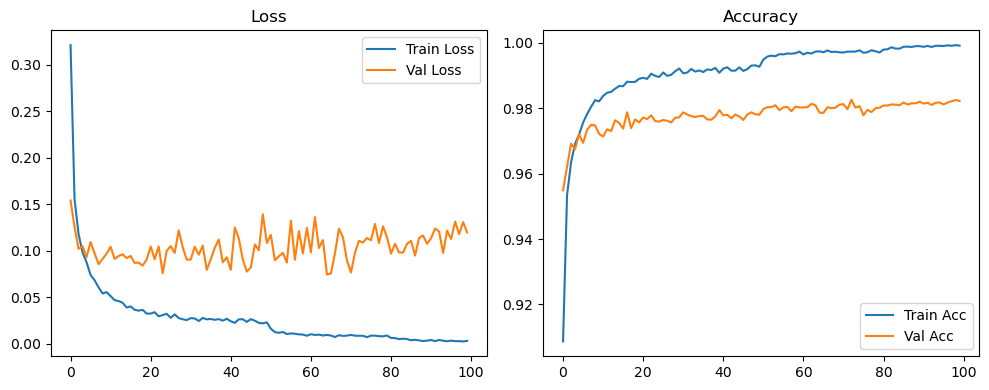

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4074, Acc: 0.8855 | Val Loss: 0.1541, Acc: 0.9522


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2028, Acc: 0.9388 | Val Loss: 0.1256, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1752, Acc: 0.9464 | Val Loss: 0.1153, Acc: 0.9651


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1561, Acc: 0.9514 | Val Loss: 0.1234, Acc: 0.9654


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9544 | Val Loss: 0.0959, Acc: 0.9708


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9584 | Val Loss: 0.0955, Acc: 0.9700


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1311, Acc: 0.9599 | Val Loss: 0.1177, Acc: 0.9714


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9625 | Val Loss: 0.1011, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9635 | Val Loss: 0.0880, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1169, Acc: 0.9639 | Val Loss: 0.0881, Acc: 0.9737


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1073, Acc: 0.9667 | Val Loss: 0.0905, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1066, Acc: 0.9669 | Val Loss: 0.0913, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9673 | Val Loss: 0.0950, Acc: 0.9731


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9673 | Val Loss: 0.1046, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1052, Acc: 0.9672 | Val Loss: 0.0879, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0989, Acc: 0.9692 | Val Loss: 0.0977, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9693 | Val Loss: 0.0923, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9701 | Val Loss: 0.0910, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0963, Acc: 0.9700 | Val Loss: 0.0804, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0970, Acc: 0.9697 | Val Loss: 0.0798, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0921, Acc: 0.9712 | Val Loss: 0.1005, Acc: 0.9750


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9707 | Val Loss: 0.0866, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9730 | Val Loss: 0.0885, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9705 | Val Loss: 0.0811, Acc: 0.9738


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9712 | Val Loss: 0.0922, Acc: 0.9749


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9704 | Val Loss: 0.0851, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9709 | Val Loss: 0.0909, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9720 | Val Loss: 0.1007, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9714 | Val Loss: 0.0810, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0886, Acc: 0.9720 | Val Loss: 0.0963, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9730 | Val Loss: 0.0811, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9730 | Val Loss: 0.1011, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9745 | Val Loss: 0.0792, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9720 | Val Loss: 0.0826, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9740 | Val Loss: 0.0849, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9722 | Val Loss: 0.0788, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.1091, Acc: 0.9756


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9744 | Val Loss: 0.0898, Acc: 0.9755


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9734 | Val Loss: 0.1006, Acc: 0.9772


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9726 | Val Loss: 0.0921, Acc: 0.9762


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9750 | Val Loss: 0.0892, Acc: 0.9741


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9740 | Val Loss: 0.0821, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0873, Acc: 0.9724 | Val Loss: 0.0991, Acc: 0.9764


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9733 | Val Loss: 0.0770, Acc: 0.9763


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9750 | Val Loss: 0.0840, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9741 | Val Loss: 0.0966, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9736 | Val Loss: 0.0820, Acc: 0.9757


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9750 | Val Loss: 0.0763, Acc: 0.9761


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9741 | Val Loss: 0.0914, Acc: 0.9781


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9736 | Val Loss: 0.0820, Acc: 0.9769


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0762, Acc: 0.9751 | Val Loss: 0.0787, Acc: 0.9775


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0676, Acc: 0.9784 | Val Loss: 0.0790, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0636, Acc: 0.9791 | Val Loss: 0.0850, Acc: 0.9783


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9802 | Val Loss: 0.0796, Acc: 0.9791


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9807 | Val Loss: 0.0757, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9817 | Val Loss: 0.0735, Acc: 0.9792


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9835 | Val Loss: 0.0713, Acc: 0.9792


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9828 | Val Loss: 0.0736, Acc: 0.9790


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0533, Acc: 0.9832 | Val Loss: 0.0681, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0519, Acc: 0.9833 | Val Loss: 0.0734, Acc: 0.9795


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9834 | Val Loss: 0.0795, Acc: 0.9799


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0528, Acc: 0.9834 | Val Loss: 0.0653, Acc: 0.9802


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0490, Acc: 0.9845 | Val Loss: 0.0809, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9838 | Val Loss: 0.0717, Acc: 0.9793


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9852 | Val Loss: 0.0735, Acc: 0.9794


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9858 | Val Loss: 0.0752, Acc: 0.9800


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9860 | Val Loss: 0.0798, Acc: 0.9801


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0471, Acc: 0.9852 | Val Loss: 0.0711, Acc: 0.9800


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0455, Acc: 0.9857 | Val Loss: 0.0754, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9860 | Val Loss: 0.0766, Acc: 0.9807


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9846 | Val Loss: 0.0836, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9855 | Val Loss: 0.0726, Acc: 0.9793


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9859 | Val Loss: 0.0772, Acc: 0.9811


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9866 | Val Loss: 0.0722, Acc: 0.9798


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9867 | Val Loss: 0.0750, Acc: 0.9805


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0421, Acc: 0.9867 | Val Loss: 0.0812, Acc: 0.9807


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.0820, Acc: 0.9804


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.0816, Acc: 0.9806


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9867 | Val Loss: 0.0734, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.0702, Acc: 0.9809


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9872 | Val Loss: 0.0712, Acc: 0.9811


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0746, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9883 | Val Loss: 0.0777, Acc: 0.9807


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0326, Acc: 0.9893 | Val Loss: 0.0781, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.0833, Acc: 0.9807


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.0824, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0319, Acc: 0.9898 | Val Loss: 0.0781, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.0796, Acc: 0.9820


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9900 | Val Loss: 0.0764, Acc: 0.9822


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9900 | Val Loss: 0.0909, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0771, Acc: 0.9813


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0299, Acc: 0.9901 | Val Loss: 0.0789, Acc: 0.9819


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.0819, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9903 | Val Loss: 0.0737, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.0761, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0713, Acc: 0.9819


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0801, Acc: 0.9819


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9919 | Val Loss: 0.0810, Acc: 0.9816


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0787, Acc: 0.9815


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9916 | Val Loss: 0.0799, Acc: 0.9817


Final Test Loss: 0.0721 Accuracy: 0.9832


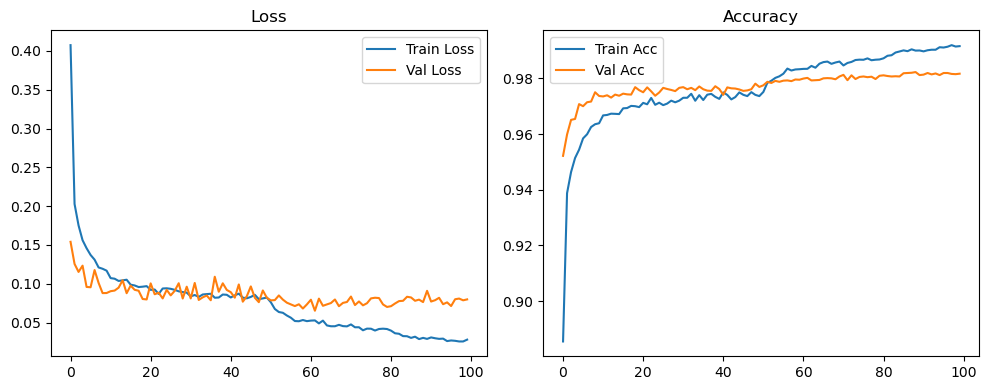

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2948, Acc: 0.9148 | Val Loss: 0.1626, Acc: 0.9513


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9603 | Val Loss: 0.1445, Acc: 0.9550


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1007, Acc: 0.9689 | Val Loss: 0.0997, Acc: 0.9706


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9759 | Val Loss: 0.1040, Acc: 0.9684


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0645, Acc: 0.9790 | Val Loss: 0.1048, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0560, Acc: 0.9817 | Val Loss: 0.1021, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9833 | Val Loss: 0.0926, Acc: 0.9746


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.0990, Acc: 0.9714


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9870 | Val Loss: 0.0977, Acc: 0.9739


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0369, Acc: 0.9883 | Val Loss: 0.1100, Acc: 0.9699


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1135, Acc: 0.9709


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0950, Acc: 0.9742


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0982, Acc: 0.9751


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9905 | Val Loss: 0.1090, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.1053, Acc: 0.9756


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.1054, Acc: 0.9759


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.1027, Acc: 0.9734


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0999, Acc: 0.9746


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1264, Acc: 0.9755


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9928 | Val Loss: 0.1210, Acc: 0.9756


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1286, Acc: 0.9757


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1251, Acc: 0.9765


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1138, Acc: 0.9762


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9932 | Val Loss: 0.1232, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9945 | Val Loss: 0.1102, Acc: 0.9756


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.1094, Acc: 0.9787


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9946 | Val Loss: 0.1299, Acc: 0.9748


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9940 | Val Loss: 0.1096, Acc: 0.9773


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1116, Acc: 0.9751


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9950 | Val Loss: 0.1455, Acc: 0.9739


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1332, Acc: 0.9738


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1409, Acc: 0.9732


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1201, Acc: 0.9743


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0973, Acc: 0.9766


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1442, Acc: 0.9792


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1015, Acc: 0.9762


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1671, Acc: 0.9735


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1367, Acc: 0.9756


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1301, Acc: 0.9753


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1287, Acc: 0.9730


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1218, Acc: 0.9777


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1333, Acc: 0.9754


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0865, Acc: 0.9754


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.1292, Acc: 0.9760


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1083, Acc: 0.9739


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9962 | Val Loss: 0.1334, Acc: 0.9769


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1198, Acc: 0.9766


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1414, Acc: 0.9755


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0998, Acc: 0.9769


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.1435, Acc: 0.9753


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1384, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1414, Acc: 0.9790


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1483, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1476, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1407, Acc: 0.9796


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1292, Acc: 0.9799


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1416, Acc: 0.9797


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1724, Acc: 0.9801


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1950, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1319, Acc: 0.9799


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1428, Acc: 0.9790


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1522, Acc: 0.9788


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1673, Acc: 0.9794


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1760, Acc: 0.9791


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1786, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1517, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1409, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1595, Acc: 0.9799


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1891, Acc: 0.9805


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1522, Acc: 0.9800


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1724, Acc: 0.9807


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1491, Acc: 0.9796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1528, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1435, Acc: 0.9811


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1563, Acc: 0.9808


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1426, Acc: 0.9794


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1703, Acc: 0.9798


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1543, Acc: 0.9796


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1822, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1457, Acc: 0.9797


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1589, Acc: 0.9804


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1620, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1644, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1748, Acc: 0.9790


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1894, Acc: 0.9796


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1618, Acc: 0.9800


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1981, Acc: 0.9805


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1722, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1675, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1827, Acc: 0.9803


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1798, Acc: 0.9805


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1886, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1926, Acc: 0.9805


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1746, Acc: 0.9811


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1759, Acc: 0.9804


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1651, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1632, Acc: 0.9811


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1884, Acc: 0.9821


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1873, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1914, Acc: 0.9807


Final Test Loss: 0.1842 Accuracy: 0.9822


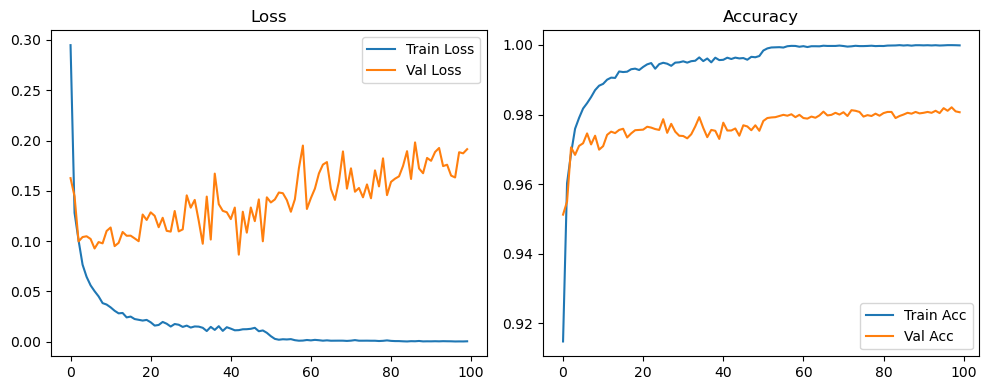

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3213, Acc: 0.9087 | Val Loss: 0.1540, Acc: 0.9549


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1554, Acc: 0.9534 | Val Loss: 0.1255, Acc: 0.9621


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1178, Acc: 0.9635 | Val Loss: 0.1019, Acc: 0.9692


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0980, Acc: 0.9691 | Val Loss: 0.1049, Acc: 0.9675


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0874, Acc: 0.9719 | Val Loss: 0.0930, Acc: 0.9721


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0739, Acc: 0.9756 | Val Loss: 0.1094, Acc: 0.9694


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9782 | Val Loss: 0.0971, Acc: 0.9734


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9804 | Val Loss: 0.0854, Acc: 0.9749


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9825 | Val Loss: 0.0912, Acc: 0.9748


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9821 | Val Loss: 0.0968, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9838 | Val Loss: 0.1042, Acc: 0.9713


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0911, Acc: 0.9736


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9850 | Val Loss: 0.0943, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9860 | Val Loss: 0.0961, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9868 | Val Loss: 0.0921, Acc: 0.9755


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9867 | Val Loss: 0.0943, Acc: 0.9738


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.0869, Acc: 0.9788


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9880 | Val Loss: 0.0870, Acc: 0.9739


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9881 | Val Loss: 0.0839, Acc: 0.9766


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.0905, Acc: 0.9757


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9893 | Val Loss: 0.1045, Acc: 0.9772


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9890 | Val Loss: 0.0907, Acc: 0.9767


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.1046, Acc: 0.9778


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.0757, Acc: 0.9761


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9896 | Val Loss: 0.0998, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.1049, Acc: 0.9764


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0977, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9902 | Val Loss: 0.1218, Acc: 0.9757


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.1038, Acc: 0.9771


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9922 | Val Loss: 0.0904, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.0904, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.1043, Acc: 0.9781


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0956, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9912 | Val Loss: 0.1054, Acc: 0.9773


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9916 | Val Loss: 0.0793, Acc: 0.9776


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.0907, Acc: 0.9777


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.1031, Acc: 0.9766


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.1120, Acc: 0.9765


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0247, Acc: 0.9923 | Val Loss: 0.0874, Acc: 0.9775


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.0929, Acc: 0.9794


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0793, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.1249, Acc: 0.9780


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1131, Acc: 0.9769


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0904, Acc: 0.9781


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0775, Acc: 0.9775


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0819, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.1067, Acc: 0.9781


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.1005, Acc: 0.9788


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9931 | Val Loss: 0.1392, Acc: 0.9782


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1083, Acc: 0.9780


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1027, Acc: 0.9799


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.1000, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1167, Acc: 0.9801


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0965, Acc: 0.9808


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.0895, Acc: 0.9803


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1008, Acc: 0.9805


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0953, Acc: 0.9817


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0949, Acc: 0.9813


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0951, Acc: 0.9811


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1079, Acc: 0.9815


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1160, Acc: 0.9817


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9978 | Val Loss: 0.1057, Acc: 0.9822


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0881, Acc: 0.9824


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1026, Acc: 0.9826


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0810, Acc: 0.9819


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1038, Acc: 0.9809


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0882, Acc: 0.9820


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1122, Acc: 0.9828


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1194, Acc: 0.9825


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0904, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0839, Acc: 0.9826


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1199, Acc: 0.9828


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0895, Acc: 0.9819


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1028, Acc: 0.9829


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0983, Acc: 0.9825


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0896, Acc: 0.9822


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1027, Acc: 0.9814


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1170, Acc: 0.9823


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0957, Acc: 0.9822


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1348, Acc: 0.9826


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0921, Acc: 0.9831


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1154, Acc: 0.9828


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0916, Acc: 0.9835


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1020, Acc: 0.9837


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0936, Acc: 0.9827


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1116, Acc: 0.9824


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1141, Acc: 0.9824


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1060, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0948, Acc: 0.9832


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1020, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0922, Acc: 0.9827


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1123, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1077, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1018, Acc: 0.9828


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0929, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1040, Acc: 0.9832


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1165, Acc: 0.9824


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1344, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1091, Acc: 0.9830


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1119, Acc: 0.9832


Final Test Loss: 0.0983 Accuracy: 0.9842


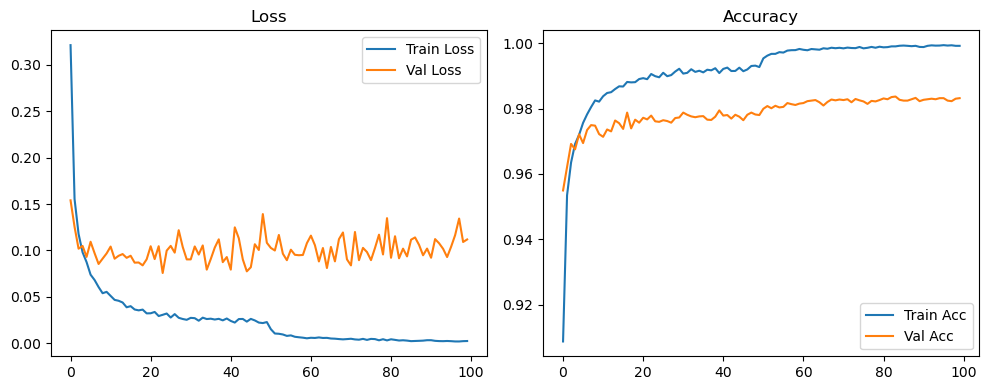

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4074, Acc: 0.8855 | Val Loss: 0.1541, Acc: 0.9522


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2028, Acc: 0.9388 | Val Loss: 0.1256, Acc: 0.9598


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1752, Acc: 0.9464 | Val Loss: 0.1153, Acc: 0.9651


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1561, Acc: 0.9514 | Val Loss: 0.1234, Acc: 0.9654


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1459, Acc: 0.9544 | Val Loss: 0.0959, Acc: 0.9708


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1372, Acc: 0.9584 | Val Loss: 0.0955, Acc: 0.9700


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1311, Acc: 0.9599 | Val Loss: 0.1177, Acc: 0.9714


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1211, Acc: 0.9625 | Val Loss: 0.1011, Acc: 0.9717


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9635 | Val Loss: 0.0880, Acc: 0.9750


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1169, Acc: 0.9639 | Val Loss: 0.0881, Acc: 0.9737


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.1073, Acc: 0.9667 | Val Loss: 0.0905, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.1066, Acc: 0.9669 | Val Loss: 0.0913, Acc: 0.9739


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.1037, Acc: 0.9673 | Val Loss: 0.0950, Acc: 0.9731


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.1045, Acc: 0.9673 | Val Loss: 0.1046, Acc: 0.9742


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.1052, Acc: 0.9672 | Val Loss: 0.0879, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0989, Acc: 0.9692 | Val Loss: 0.0977, Acc: 0.9745


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0979, Acc: 0.9693 | Val Loss: 0.0923, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0958, Acc: 0.9701 | Val Loss: 0.0910, Acc: 0.9742


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0963, Acc: 0.9700 | Val Loss: 0.0804, Acc: 0.9768


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0970, Acc: 0.9697 | Val Loss: 0.0798, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0921, Acc: 0.9712 | Val Loss: 0.1005, Acc: 0.9750


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0927, Acc: 0.9707 | Val Loss: 0.0866, Acc: 0.9768


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0870, Acc: 0.9730 | Val Loss: 0.0885, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9705 | Val Loss: 0.0811, Acc: 0.9738


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0942, Acc: 0.9712 | Val Loss: 0.0922, Acc: 0.9749


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9704 | Val Loss: 0.0851, Acc: 0.9766


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0922, Acc: 0.9709 | Val Loss: 0.0909, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9720 | Val Loss: 0.1007, Acc: 0.9758


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0894, Acc: 0.9714 | Val Loss: 0.0810, Acc: 0.9754


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0886, Acc: 0.9720 | Val Loss: 0.0963, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9730 | Val Loss: 0.0811, Acc: 0.9768


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0855, Acc: 0.9730 | Val Loss: 0.1011, Acc: 0.9761


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9745 | Val Loss: 0.0792, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9720 | Val Loss: 0.0826, Acc: 0.9758


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0867, Acc: 0.9740 | Val Loss: 0.0849, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9722 | Val Loss: 0.0788, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0821, Acc: 0.9741 | Val Loss: 0.1091, Acc: 0.9756


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9744 | Val Loss: 0.0898, Acc: 0.9755


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0862, Acc: 0.9734 | Val Loss: 0.1006, Acc: 0.9772


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9726 | Val Loss: 0.0921, Acc: 0.9762


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0824, Acc: 0.9750 | Val Loss: 0.0892, Acc: 0.9741


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0851, Acc: 0.9740 | Val Loss: 0.0821, Acc: 0.9768


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0873, Acc: 0.9724 | Val Loss: 0.0991, Acc: 0.9764


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0822, Acc: 0.9733 | Val Loss: 0.0770, Acc: 0.9763


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0813, Acc: 0.9750 | Val Loss: 0.0840, Acc: 0.9760


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0831, Acc: 0.9741 | Val Loss: 0.0966, Acc: 0.9755


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0858, Acc: 0.9736 | Val Loss: 0.0820, Acc: 0.9757


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0802, Acc: 0.9750 | Val Loss: 0.0763, Acc: 0.9761


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0812, Acc: 0.9741 | Val Loss: 0.0914, Acc: 0.9781


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0823, Acc: 0.9736 | Val Loss: 0.0820, Acc: 0.9769


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0757, Acc: 0.9754 | Val Loss: 0.0779, Acc: 0.9778


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0676, Acc: 0.9781 | Val Loss: 0.0789, Acc: 0.9784


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0635, Acc: 0.9791 | Val Loss: 0.0804, Acc: 0.9781


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0605, Acc: 0.9804 | Val Loss: 0.0797, Acc: 0.9791


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0575, Acc: 0.9812 | Val Loss: 0.0766, Acc: 0.9783


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0546, Acc: 0.9826 | Val Loss: 0.0713, Acc: 0.9796


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9829 | Val Loss: 0.0694, Acc: 0.9802


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9838 | Val Loss: 0.0693, Acc: 0.9792


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0509, Acc: 0.9828 | Val Loss: 0.0685, Acc: 0.9789


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9849 | Val Loss: 0.0784, Acc: 0.9792


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0741, Acc: 0.9800


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9845 | Val Loss: 0.0907, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9861 | Val Loss: 0.0768, Acc: 0.9796


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0458, Acc: 0.9845 | Val Loss: 0.0684, Acc: 0.9803


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9855 | Val Loss: 0.0731, Acc: 0.9797


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.0758, Acc: 0.9796


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.0753, Acc: 0.9795


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0405, Acc: 0.9868 | Val Loss: 0.0727, Acc: 0.9800


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0406, Acc: 0.9870 | Val Loss: 0.0713, Acc: 0.9804


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0383, Acc: 0.9874 | Val Loss: 0.0728, Acc: 0.9805


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9872 | Val Loss: 0.0676, Acc: 0.9814


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9873 | Val Loss: 0.0686, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0373, Acc: 0.9873 | Val Loss: 0.0738, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 0.0691, Acc: 0.9807


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9882 | Val Loss: 0.0835, Acc: 0.9818


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0341, Acc: 0.9884 | Val Loss: 0.0840, Acc: 0.9805


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9890 | Val Loss: 0.0799, Acc: 0.9804


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9884 | Val Loss: 0.0750, Acc: 0.9799


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9894 | Val Loss: 0.0820, Acc: 0.9798


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9892 | Val Loss: 0.0776, Acc: 0.9806


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0336, Acc: 0.9889 | Val Loss: 0.0703, Acc: 0.9807


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9885 | Val Loss: 0.0759, Acc: 0.9811


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9886 | Val Loss: 0.0750, Acc: 0.9807


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9898 | Val Loss: 0.0776, Acc: 0.9809


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0298, Acc: 0.9902 | Val Loss: 0.0836, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.0837, Acc: 0.9820


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0290, Acc: 0.9905 | Val Loss: 0.0759, Acc: 0.9811


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0867, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.0753, Acc: 0.9806


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.0780, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9901 | Val Loss: 0.0767, Acc: 0.9805


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.0745, Acc: 0.9817


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9909 | Val Loss: 0.0773, Acc: 0.9815


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0270, Acc: 0.9911 | Val Loss: 0.0756, Acc: 0.9813


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.0747, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.0710, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0269, Acc: 0.9910 | Val Loss: 0.0765, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0829, Acc: 0.9810


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0786, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.0782, Acc: 0.9821


Final Test Loss: 0.0710 Accuracy: 0.9844


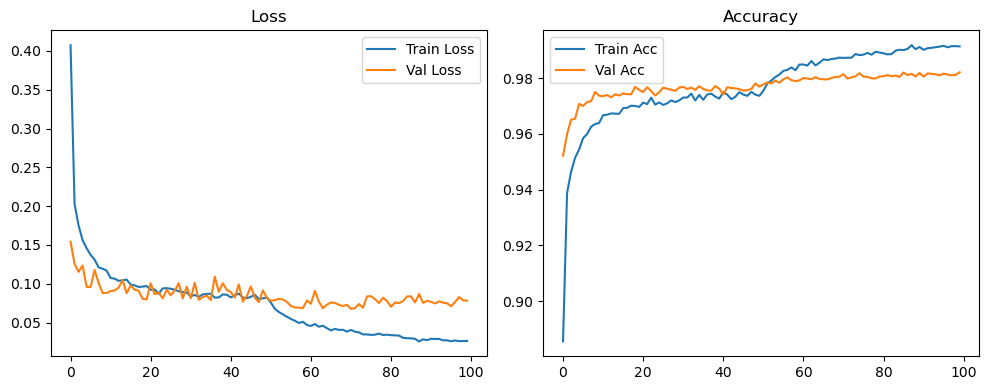

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2743, Acc: 0.9189 | Val Loss: 0.1584, Acc: 0.9520


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1296, Acc: 0.9601 | Val Loss: 0.1203, Acc: 0.9637


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9702 | Val Loss: 0.1016, Acc: 0.9689


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.1084, Acc: 0.9703


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9803 | Val Loss: 0.0864, Acc: 0.9763


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9845 | Val Loss: 0.0985, Acc: 0.9728


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9864 | Val Loss: 0.0842, Acc: 0.9763


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0991, Acc: 0.9741


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.0874, Acc: 0.9761


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0971, Acc: 0.9726


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0970, Acc: 0.9770


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0978, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0802, Acc: 0.9783


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0934, Acc: 0.9779


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0897, Acc: 0.9782


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0848, Acc: 0.9784


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.0995, Acc: 0.9778


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0875, Acc: 0.9785


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.0856, Acc: 0.9794


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9950 | Val Loss: 0.0905, Acc: 0.9807


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0935, Acc: 0.9773


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0771, Acc: 0.9799


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0850, Acc: 0.9802


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.0908, Acc: 0.9793


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1052, Acc: 0.9781


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1127, Acc: 0.9749


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0855, Acc: 0.9786


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0908, Acc: 0.9769


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0936, Acc: 0.9790


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0991, Acc: 0.9792


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1131, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0982, Acc: 0.9782


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0973, Acc: 0.9785


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0842, Acc: 0.9786


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0898, Acc: 0.9791


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0882, Acc: 0.9776


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1048, Acc: 0.9801


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1139, Acc: 0.9756


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9792


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1314, Acc: 0.9777


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1102, Acc: 0.9785


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1424, Acc: 0.9742


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1178, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1080, Acc: 0.9790


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1227, Acc: 0.9802


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1104, Acc: 0.9778


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0986, Acc: 0.9769


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1189, Acc: 0.9783


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1145, Acc: 0.9789


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.1100, Acc: 0.9793


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1180, Acc: 0.9778


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1188, Acc: 0.9795


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1302, Acc: 0.9783


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1241, Acc: 0.9792


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1099, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1180, Acc: 0.9797


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0996, Acc: 0.9778


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1087, Acc: 0.9785


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1158, Acc: 0.9799


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1385, Acc: 0.9784


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0865, Acc: 0.9795


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1073, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1291, Acc: 0.9797


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1114, Acc: 0.9800


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1069, Acc: 0.9808


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1366, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0934, Acc: 0.9810


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1496, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1307, Acc: 0.9792


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1383, Acc: 0.9758


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0984, Acc: 0.9791


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1246, Acc: 0.9779


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1078, Acc: 0.9782


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1202, Acc: 0.9793


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1318, Acc: 0.9777


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1230, Acc: 0.9767


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1341, Acc: 0.9785


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1397, Acc: 0.9788


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0942, Acc: 0.9795


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0992, Acc: 0.9773


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1579, Acc: 0.9798


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1521, Acc: 0.9783


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1478, Acc: 0.9782


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1247, Acc: 0.9780


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1187, Acc: 0.9802


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0967, Acc: 0.9794


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1143, Acc: 0.9788


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1109, Acc: 0.9798


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1506, Acc: 0.9797


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1191, Acc: 0.9782


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1108, Acc: 0.9771


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1044, Acc: 0.9777


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1242, Acc: 0.9768


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1243, Acc: 0.9784


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1316, Acc: 0.9790


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1061, Acc: 0.9789


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1427, Acc: 0.9775


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1532, Acc: 0.9777


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1470, Acc: 0.9789


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1072, Acc: 0.9783


Final Test Loss: 0.1031 Accuracy: 0.9789


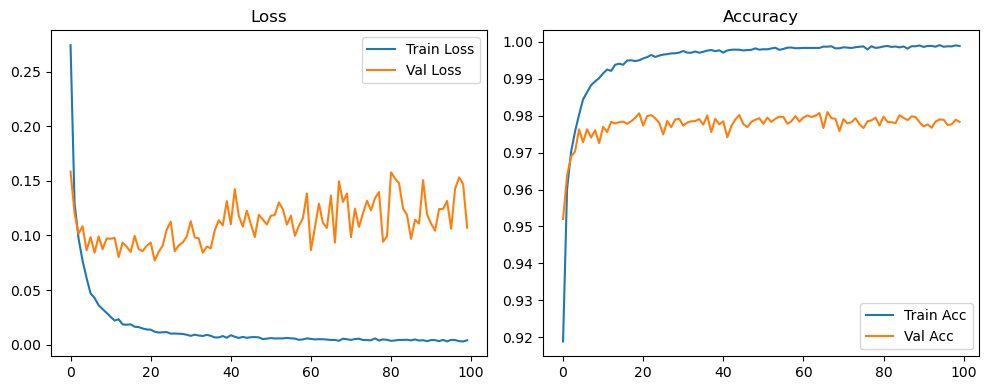

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2921, Acc: 0.9133 | Val Loss: 0.1731, Acc: 0.9494


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1496, Acc: 0.9547 | Val Loss: 0.1126, Acc: 0.9652


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1168, Acc: 0.9643 | Val Loss: 0.1296, Acc: 0.9612


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9707 | Val Loss: 0.1053, Acc: 0.9703


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9767 | Val Loss: 0.0940, Acc: 0.9728


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9794 | Val Loss: 0.0852, Acc: 0.9748


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9813 | Val Loss: 0.0938, Acc: 0.9743


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9839 | Val Loss: 0.0977, Acc: 0.9748


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9846 | Val Loss: 0.0972, Acc: 0.9730


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.0924, Acc: 0.9738


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0930, Acc: 0.9750


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.0961, Acc: 0.9777


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.0933, Acc: 0.9756


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0845, Acc: 0.9760


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0868, Acc: 0.9786


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.0792, Acc: 0.9790


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0883, Acc: 0.9752


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0789, Acc: 0.9780


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0934, Acc: 0.9785


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0824, Acc: 0.9798


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0845, Acc: 0.9784


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0878, Acc: 0.9778


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0857, Acc: 0.9805


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0879, Acc: 0.9791


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9936 | Val Loss: 0.0927, Acc: 0.9782


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0851, Acc: 0.9792


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1011, Acc: 0.9785


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0985, Acc: 0.9777


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.1060, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0898, Acc: 0.9788


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0922, Acc: 0.9782


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0933, Acc: 0.9796


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0985, Acc: 0.9790


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0915, Acc: 0.9796


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0797, Acc: 0.9795


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0853, Acc: 0.9776


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1088, Acc: 0.9792


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0889, Acc: 0.9802


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0790, Acc: 0.9799


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0790, Acc: 0.9813


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.0984, Acc: 0.9794


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0742, Acc: 0.9801


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9957 | Val Loss: 0.1093, Acc: 0.9775


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.0911, Acc: 0.9798


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0884, Acc: 0.9794


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0902, Acc: 0.9818


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0910, Acc: 0.9798


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0844, Acc: 0.9795


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1126, Acc: 0.9798


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1100, Acc: 0.9794


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0895, Acc: 0.9807


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1097, Acc: 0.9782


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1022, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1089, Acc: 0.9792


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0816, Acc: 0.9796


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1064, Acc: 0.9811


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1071, Acc: 0.9797


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0905, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0998, Acc: 0.9790


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1060, Acc: 0.9791


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1018, Acc: 0.9803


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0975, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0993, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1114, Acc: 0.9801


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1053, Acc: 0.9804


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0977, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1235, Acc: 0.9799


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0969, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1156, Acc: 0.9787


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0956, Acc: 0.9805


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0842, Acc: 0.9780


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1375, Acc: 0.9783


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0931, Acc: 0.9803


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1153, Acc: 0.9803


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1038, Acc: 0.9781


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1010, Acc: 0.9799


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1089, Acc: 0.9796


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1085, Acc: 0.9796


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0989, Acc: 0.9802


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1206, Acc: 0.9801


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1163, Acc: 0.9792


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1053, Acc: 0.9804


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0917, Acc: 0.9799


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1252, Acc: 0.9805


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1031, Acc: 0.9814


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0995, Acc: 0.9817


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1020, Acc: 0.9809


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1055, Acc: 0.9805


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1245, Acc: 0.9797


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.0895, Acc: 0.9788


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0788, Acc: 0.9797


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0929, Acc: 0.9808


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1018, Acc: 0.9800


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0942, Acc: 0.9818


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1098, Acc: 0.9798


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0897, Acc: 0.9794


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0989, Acc: 0.9792


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0970, Acc: 0.9798


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0989, Acc: 0.9795


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0980, Acc: 0.9799


Final Test Loss: 0.0847 Accuracy: 0.9820


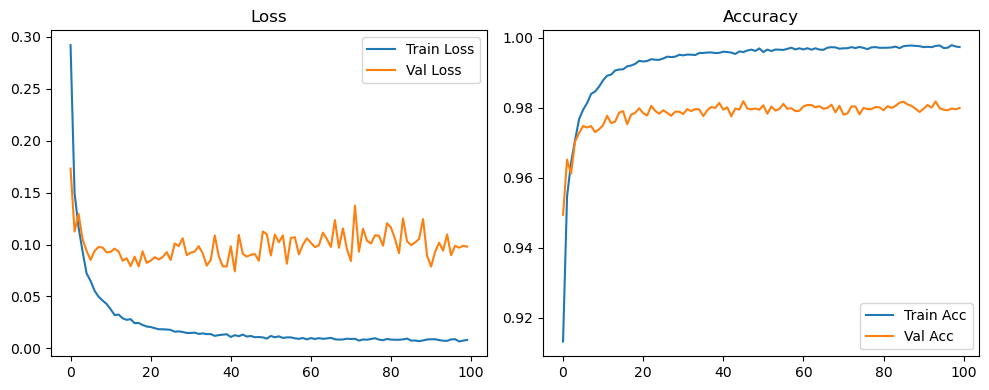

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3731, Acc: 0.8915 | Val Loss: 0.1690, Acc: 0.9493


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2158, Acc: 0.9357 | Val Loss: 0.1323, Acc: 0.9593


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1743, Acc: 0.9485 | Val Loss: 0.1075, Acc: 0.9665


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1387, Acc: 0.9571 | Val Loss: 0.1108, Acc: 0.9660


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1237, Acc: 0.9613 | Val Loss: 0.0914, Acc: 0.9714


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9644 | Val Loss: 0.0910, Acc: 0.9734


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1063, Acc: 0.9665 | Val Loss: 0.0855, Acc: 0.9757


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9700 | Val Loss: 0.0915, Acc: 0.9746


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0936, Acc: 0.9703 | Val Loss: 0.0832, Acc: 0.9771


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9721 | Val Loss: 0.0873, Acc: 0.9760


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0803, Acc: 0.9741 | Val Loss: 0.0918, Acc: 0.9749


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9757 | Val Loss: 0.0754, Acc: 0.9786


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9760 | Val Loss: 0.0772, Acc: 0.9760


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9784 | Val Loss: 0.0799, Acc: 0.9774


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0679, Acc: 0.9782 | Val Loss: 0.0709, Acc: 0.9792


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9795 | Val Loss: 0.0868, Acc: 0.9782


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9797 | Val Loss: 0.0800, Acc: 0.9768


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9814 | Val Loss: 0.0765, Acc: 0.9787


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9809 | Val Loss: 0.0704, Acc: 0.9808


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9822 | Val Loss: 0.0729, Acc: 0.9803


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9829 | Val Loss: 0.0829, Acc: 0.9781


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9824 | Val Loss: 0.0763, Acc: 0.9794


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9850 | Val Loss: 0.0858, Acc: 0.9778


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9832 | Val Loss: 0.0788, Acc: 0.9800


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9835 | Val Loss: 0.0813, Acc: 0.9794


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9829 | Val Loss: 0.0705, Acc: 0.9775


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9842 | Val Loss: 0.0731, Acc: 0.9797


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9839 | Val Loss: 0.0891, Acc: 0.9778


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9835 | Val Loss: 0.0723, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9852 | Val Loss: 0.0792, Acc: 0.9797


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.0770, Acc: 0.9797


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.0765, Acc: 0.9808


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9854 | Val Loss: 0.0813, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.0759, Acc: 0.9796


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9857 | Val Loss: 0.0729, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9853 | Val Loss: 0.0763, Acc: 0.9785


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0817, Acc: 0.9793


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9858 | Val Loss: 0.0719, Acc: 0.9806


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9860 | Val Loss: 0.0815, Acc: 0.9794


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9864 | Val Loss: 0.0751, Acc: 0.9803


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9861 | Val Loss: 0.0697, Acc: 0.9795


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9857 | Val Loss: 0.0789, Acc: 0.9805


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.0803, Acc: 0.9802


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9873 | Val Loss: 0.0857, Acc: 0.9793


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.0743, Acc: 0.9798


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 0.0708, Acc: 0.9814


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9863 | Val Loss: 0.0782, Acc: 0.9797


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0872, Acc: 0.9807


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0769, Acc: 0.9809


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.0746, Acc: 0.9808


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0373, Acc: 0.9885 | Val Loss: 0.0767, Acc: 0.9811


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9877 | Val Loss: 0.0893, Acc: 0.9807


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9881 | Val Loss: 0.0838, Acc: 0.9812


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.0764, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9876 | Val Loss: 0.0747, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0374, Acc: 0.9881 | Val Loss: 0.0735, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9881 | Val Loss: 0.0756, Acc: 0.9787


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9894 | Val Loss: 0.0679, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.0660, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0937, Acc: 0.9803


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9872 | Val Loss: 0.0746, Acc: 0.9810


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9888 | Val Loss: 0.0819, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9883 | Val Loss: 0.0793, Acc: 0.9792


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.0926, Acc: 0.9794


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0364, Acc: 0.9883 | Val Loss: 0.0741, Acc: 0.9790


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.0906, Acc: 0.9802


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0348, Acc: 0.9891 | Val Loss: 0.0667, Acc: 0.9807


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9894 | Val Loss: 0.0716, Acc: 0.9813


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9899 | Val Loss: 0.0811, Acc: 0.9807


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0346, Acc: 0.9892 | Val Loss: 0.0895, Acc: 0.9813


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9879 | Val Loss: 0.0738, Acc: 0.9807


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9885 | Val Loss: 0.0945, Acc: 0.9806


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 0.0689, Acc: 0.9810


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9899 | Val Loss: 0.0777, Acc: 0.9798


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 0.0771, Acc: 0.9797


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9894 | Val Loss: 0.0759, Acc: 0.9804


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9886 | Val Loss: 0.0773, Acc: 0.9811


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9890 | Val Loss: 0.0776, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9887 | Val Loss: 0.0799, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.0789, Acc: 0.9799


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9891 | Val Loss: 0.0801, Acc: 0.9806


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9881 | Val Loss: 0.0697, Acc: 0.9804


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0332, Acc: 0.9898 | Val Loss: 0.0697, Acc: 0.9799


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0725, Acc: 0.9798


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.0804, Acc: 0.9802


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.0729, Acc: 0.9819


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0830, Acc: 0.9808


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9901 | Val Loss: 0.0916, Acc: 0.9808


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.0771, Acc: 0.9795


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9896 | Val Loss: 0.0958, Acc: 0.9809


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9891 | Val Loss: 0.0735, Acc: 0.9811


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9898 | Val Loss: 0.0673, Acc: 0.9806


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9893 | Val Loss: 0.0811, Acc: 0.9807


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9892 | Val Loss: 0.0756, Acc: 0.9799


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0317, Acc: 0.9901 | Val Loss: 0.0905, Acc: 0.9805


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9900 | Val Loss: 0.0694, Acc: 0.9812


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9894 | Val Loss: 0.0787, Acc: 0.9814


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9893 | Val Loss: 0.0735, Acc: 0.9818


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9890 | Val Loss: 0.0672, Acc: 0.9807


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0322, Acc: 0.9903 | Val Loss: 0.0827, Acc: 0.9808


Final Test Loss: 0.0740 Accuracy: 0.9825


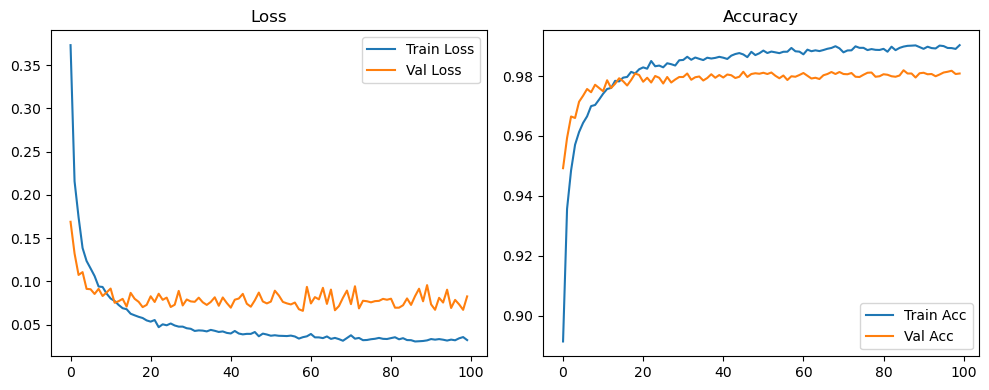

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2743, Acc: 0.9189 | Val Loss: 0.1584, Acc: 0.9520


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1296, Acc: 0.9601 | Val Loss: 0.1203, Acc: 0.9637


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0972, Acc: 0.9702 | Val Loss: 0.1016, Acc: 0.9689


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0768, Acc: 0.9758 | Val Loss: 0.1084, Acc: 0.9703


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9803 | Val Loss: 0.0864, Acc: 0.9763


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9845 | Val Loss: 0.0985, Acc: 0.9728


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0427, Acc: 0.9864 | Val Loss: 0.0842, Acc: 0.9763


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0991, Acc: 0.9741


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.0874, Acc: 0.9761


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0971, Acc: 0.9726


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.0970, Acc: 0.9770


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9925 | Val Loss: 0.0978, Acc: 0.9756


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9921 | Val Loss: 0.0802, Acc: 0.9783


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0934, Acc: 0.9779


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0897, Acc: 0.9782


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0848, Acc: 0.9784


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.0995, Acc: 0.9778


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9950 | Val Loss: 0.0875, Acc: 0.9785


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9948 | Val Loss: 0.0856, Acc: 0.9794


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9950 | Val Loss: 0.0905, Acc: 0.9807


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0935, Acc: 0.9773


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0771, Acc: 0.9799


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0850, Acc: 0.9802


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.0908, Acc: 0.9793


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1052, Acc: 0.9781


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1127, Acc: 0.9749


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0855, Acc: 0.9786


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0908, Acc: 0.9769


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0936, Acc: 0.9790


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0991, Acc: 0.9792


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1131, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0982, Acc: 0.9782


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0973, Acc: 0.9785


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0842, Acc: 0.9786


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0898, Acc: 0.9791


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0882, Acc: 0.9776


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1048, Acc: 0.9801


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1139, Acc: 0.9756


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9792


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1314, Acc: 0.9777


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1102, Acc: 0.9785


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1424, Acc: 0.9742


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1178, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1080, Acc: 0.9790


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1227, Acc: 0.9802


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1104, Acc: 0.9778


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0986, Acc: 0.9769


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1189, Acc: 0.9783


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1145, Acc: 0.9789


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.1100, Acc: 0.9793


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1131, Acc: 0.9818


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1315, Acc: 0.9809


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1309, Acc: 0.9806


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1233, Acc: 0.9817


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1508, Acc: 0.9814


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1165, Acc: 0.9806


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1428, Acc: 0.9815


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1381, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1504, Acc: 0.9814


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1518, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1272, Acc: 0.9807


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1322, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1278, Acc: 0.9818


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1346, Acc: 0.9817


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1335, Acc: 0.9812


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1254, Acc: 0.9815


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1388, Acc: 0.9801


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1333, Acc: 0.9809


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1339, Acc: 0.9816


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1349, Acc: 0.9825


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1295, Acc: 0.9820


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1393, Acc: 0.9800


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0992, Acc: 0.9828


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1459, Acc: 0.9810


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1140, Acc: 0.9811


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1236, Acc: 0.9817


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1385, Acc: 0.9814


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1117, Acc: 0.9821


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0956, Acc: 0.9818


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1179, Acc: 0.9807


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1242, Acc: 0.9815


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1208, Acc: 0.9826


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1321, Acc: 0.9817


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1414, Acc: 0.9813


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1367, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1576, Acc: 0.9819


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1442, Acc: 0.9809


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1391, Acc: 0.9816


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1626, Acc: 0.9821


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1759, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1935, Acc: 0.9819


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1839, Acc: 0.9823


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1843, Acc: 0.9827


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1879, Acc: 0.9820


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1736, Acc: 0.9823


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1598, Acc: 0.9816


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1539, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1610, Acc: 0.9819


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1686, Acc: 0.9817


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1628, Acc: 0.9812


Final Test Loss: 0.1478 Accuracy: 0.9829


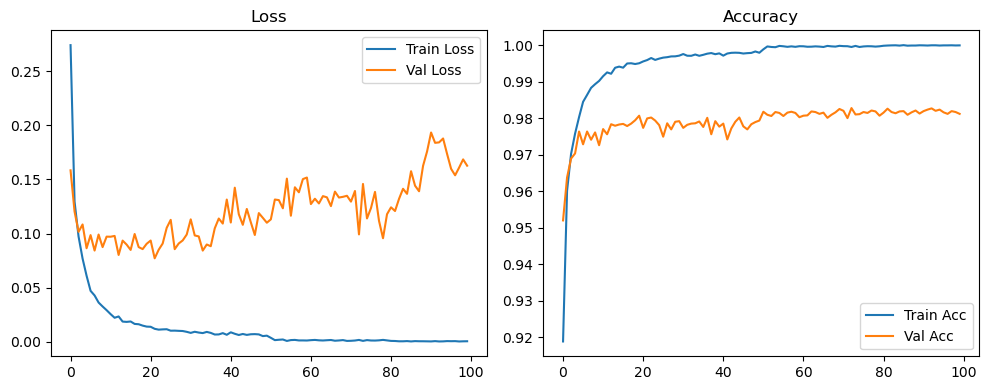

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2921, Acc: 0.9133 | Val Loss: 0.1731, Acc: 0.9494


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1496, Acc: 0.9547 | Val Loss: 0.1126, Acc: 0.9652


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1168, Acc: 0.9643 | Val Loss: 0.1296, Acc: 0.9612


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0934, Acc: 0.9707 | Val Loss: 0.1053, Acc: 0.9703


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9767 | Val Loss: 0.0940, Acc: 0.9728


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0650, Acc: 0.9794 | Val Loss: 0.0852, Acc: 0.9748


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0555, Acc: 0.9813 | Val Loss: 0.0938, Acc: 0.9743


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9839 | Val Loss: 0.0977, Acc: 0.9748


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0461, Acc: 0.9846 | Val Loss: 0.0972, Acc: 0.9730


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.0924, Acc: 0.9738


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0377, Acc: 0.9878 | Val Loss: 0.0930, Acc: 0.9750


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.0961, Acc: 0.9777


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9894 | Val Loss: 0.0933, Acc: 0.9756


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0845, Acc: 0.9760


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0868, Acc: 0.9786


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.0792, Acc: 0.9790


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0883, Acc: 0.9752


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0789, Acc: 0.9780


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9925 | Val Loss: 0.0934, Acc: 0.9785


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.0824, Acc: 0.9798


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0845, Acc: 0.9784


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.0878, Acc: 0.9778


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9938 | Val Loss: 0.0857, Acc: 0.9805


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0879, Acc: 0.9791


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9936 | Val Loss: 0.0927, Acc: 0.9782


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0851, Acc: 0.9792


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1011, Acc: 0.9785


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0985, Acc: 0.9777


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.1060, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0898, Acc: 0.9788


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0922, Acc: 0.9782


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.0933, Acc: 0.9796


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.0985, Acc: 0.9790


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0915, Acc: 0.9796


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0797, Acc: 0.9795


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.0853, Acc: 0.9776


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1088, Acc: 0.9792


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0889, Acc: 0.9802


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0790, Acc: 0.9799


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0790, Acc: 0.9813


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9960 | Val Loss: 0.0984, Acc: 0.9794


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0742, Acc: 0.9801


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9957 | Val Loss: 0.1093, Acc: 0.9775


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.0911, Acc: 0.9798


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9960 | Val Loss: 0.0884, Acc: 0.9794


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0902, Acc: 0.9818


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0910, Acc: 0.9798


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0844, Acc: 0.9795


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1126, Acc: 0.9798


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1100, Acc: 0.9794


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0995, Acc: 0.9818


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0988, Acc: 0.9802


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1061, Acc: 0.9818


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0960, Acc: 0.9815


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1228, Acc: 0.9816


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0869, Acc: 0.9814


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1004, Acc: 0.9812


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0927, Acc: 0.9824


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1025, Acc: 0.9819


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1236, Acc: 0.9798


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1117, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0934, Acc: 0.9815


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1078, Acc: 0.9820


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1049, Acc: 0.9819


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0966, Acc: 0.9810


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1103, Acc: 0.9820


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0996, Acc: 0.9812


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1092, Acc: 0.9816


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0900, Acc: 0.9818


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9991 | Val Loss: 0.1183, Acc: 0.9823


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0755, Acc: 0.9833


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1005, Acc: 0.9810


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1009, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.1302, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0948, Acc: 0.9816


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1171, Acc: 0.9811


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1114, Acc: 0.9822


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1233, Acc: 0.9815


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1035, Acc: 0.9820


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1045, Acc: 0.9811


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1095, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9991 | Val Loss: 0.1131, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0980, Acc: 0.9813


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0966, Acc: 0.9813


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1218, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.1117, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1136, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1034, Acc: 0.9817


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1243, Acc: 0.9820


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0979, Acc: 0.9823


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1047, Acc: 0.9812


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1101, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1090, Acc: 0.9828


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1209, Acc: 0.9833


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1130, Acc: 0.9819


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1136, Acc: 0.9823


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1133, Acc: 0.9824


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1123, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1195, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1222, Acc: 0.9824


Final Test Loss: 0.1141 Accuracy: 0.9832


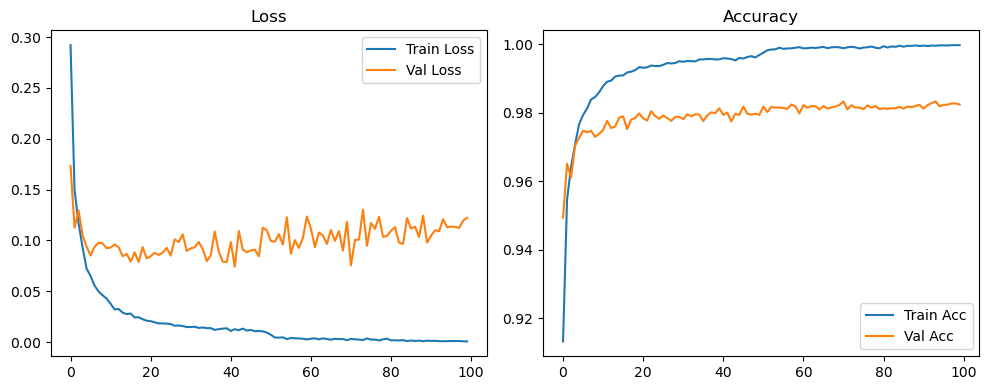

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3731, Acc: 0.8915 | Val Loss: 0.1690, Acc: 0.9493


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2158, Acc: 0.9357 | Val Loss: 0.1323, Acc: 0.9593


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1743, Acc: 0.9485 | Val Loss: 0.1075, Acc: 0.9665


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1387, Acc: 0.9571 | Val Loss: 0.1108, Acc: 0.9660


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1237, Acc: 0.9613 | Val Loss: 0.0914, Acc: 0.9714


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1151, Acc: 0.9644 | Val Loss: 0.0910, Acc: 0.9734


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1063, Acc: 0.9665 | Val Loss: 0.0855, Acc: 0.9757


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9700 | Val Loss: 0.0915, Acc: 0.9746


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0936, Acc: 0.9703 | Val Loss: 0.0832, Acc: 0.9771


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9721 | Val Loss: 0.0873, Acc: 0.9760


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0803, Acc: 0.9741 | Val Loss: 0.0918, Acc: 0.9749


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0775, Acc: 0.9757 | Val Loss: 0.0754, Acc: 0.9786


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0728, Acc: 0.9760 | Val Loss: 0.0772, Acc: 0.9760


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0691, Acc: 0.9784 | Val Loss: 0.0799, Acc: 0.9774


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0679, Acc: 0.9782 | Val Loss: 0.0709, Acc: 0.9792


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0627, Acc: 0.9795 | Val Loss: 0.0868, Acc: 0.9782


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0609, Acc: 0.9797 | Val Loss: 0.0800, Acc: 0.9768


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9814 | Val Loss: 0.0765, Acc: 0.9787


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9809 | Val Loss: 0.0704, Acc: 0.9808


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0550, Acc: 0.9822 | Val Loss: 0.0729, Acc: 0.9803


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0536, Acc: 0.9829 | Val Loss: 0.0829, Acc: 0.9781


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0554, Acc: 0.9824 | Val Loss: 0.0763, Acc: 0.9794


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9850 | Val Loss: 0.0858, Acc: 0.9778


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9832 | Val Loss: 0.0788, Acc: 0.9800


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0494, Acc: 0.9835 | Val Loss: 0.0813, Acc: 0.9794


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9829 | Val Loss: 0.0705, Acc: 0.9775


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9842 | Val Loss: 0.0731, Acc: 0.9797


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9839 | Val Loss: 0.0891, Acc: 0.9778


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0478, Acc: 0.9835 | Val Loss: 0.0723, Acc: 0.9788


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0459, Acc: 0.9852 | Val Loss: 0.0792, Acc: 0.9797


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.0770, Acc: 0.9797


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9864 | Val Loss: 0.0765, Acc: 0.9808


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9854 | Val Loss: 0.0813, Acc: 0.9788


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0432, Acc: 0.9862 | Val Loss: 0.0759, Acc: 0.9796


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0423, Acc: 0.9857 | Val Loss: 0.0729, Acc: 0.9798


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0440, Acc: 0.9853 | Val Loss: 0.0763, Acc: 0.9785


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0817, Acc: 0.9793


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9858 | Val Loss: 0.0719, Acc: 0.9806


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9860 | Val Loss: 0.0815, Acc: 0.9794


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0406, Acc: 0.9864 | Val Loss: 0.0751, Acc: 0.9803


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9861 | Val Loss: 0.0697, Acc: 0.9795


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0428, Acc: 0.9857 | Val Loss: 0.0789, Acc: 0.9805


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.0803, Acc: 0.9802


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9873 | Val Loss: 0.0857, Acc: 0.9793


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.0743, Acc: 0.9798


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0394, Acc: 0.9872 | Val Loss: 0.0708, Acc: 0.9814


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0416, Acc: 0.9863 | Val Loss: 0.0782, Acc: 0.9797


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.0872, Acc: 0.9807


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9870 | Val Loss: 0.0769, Acc: 0.9809


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9876 | Val Loss: 0.0746, Acc: 0.9808


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.0819, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0785, Acc: 0.9816


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9920 | Val Loss: 0.0781, Acc: 0.9812


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9918 | Val Loss: 0.0748, Acc: 0.9817


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9920 | Val Loss: 0.0714, Acc: 0.9824


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0746, Acc: 0.9820


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.0730, Acc: 0.9812


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0712, Acc: 0.9822


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0686, Acc: 0.9820


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.0722, Acc: 0.9815


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9939 | Val Loss: 0.0776, Acc: 0.9816


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9938 | Val Loss: 0.0751, Acc: 0.9820


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9946 | Val Loss: 0.0728, Acc: 0.9822


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0733, Acc: 0.9827


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0840, Acc: 0.9822


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9946 | Val Loss: 0.0922, Acc: 0.9824


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.0766, Acc: 0.9822


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0716, Acc: 0.9822


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0982, Acc: 0.9826


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9947 | Val Loss: 0.0789, Acc: 0.9814


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9945 | Val Loss: 0.0749, Acc: 0.9822


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.0889, Acc: 0.9809


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0857, Acc: 0.9811


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0979, Acc: 0.9818


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0724, Acc: 0.9822


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0775, Acc: 0.9816


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0792, Acc: 0.9816


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.0830, Acc: 0.9809


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0934, Acc: 0.9822


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0836, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0807, Acc: 0.9822


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0839, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.0854, Acc: 0.9815


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0919, Acc: 0.9824


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0924, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0807, Acc: 0.9825


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0841, Acc: 0.9824


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.0897, Acc: 0.9824


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.0834, Acc: 0.9823


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9964 | Val Loss: 0.0868, Acc: 0.9828


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0901, Acc: 0.9823


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0824, Acc: 0.9824


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0813, Acc: 0.9826


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0830, Acc: 0.9825


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0909, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0913, Acc: 0.9826


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0882, Acc: 0.9826


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0916, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0963, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0786, Acc: 0.9821


Final Test Loss: 0.0691 Accuracy: 0.9845


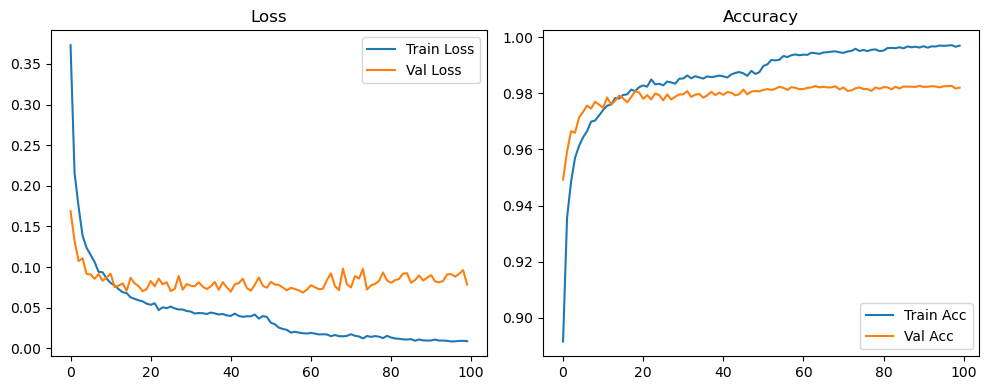

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2459, Acc: 0.9241 | Val Loss: 0.1573, Acc: 0.9529


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1235, Acc: 0.9623 | Val Loss: 0.1177, Acc: 0.9643


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0912, Acc: 0.9717 | Val Loss: 0.0988, Acc: 0.9703


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0693, Acc: 0.9784 | Val Loss: 0.1124, Acc: 0.9675


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0579, Acc: 0.9818 | Val Loss: 0.1035, Acc: 0.9721


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9841 | Val Loss: 0.0947, Acc: 0.9758


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9870 | Val Loss: 0.0947, Acc: 0.9753


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9880 | Val Loss: 0.1135, Acc: 0.9720


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.0931, Acc: 0.9773


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9902 | Val Loss: 0.0999, Acc: 0.9758


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9912 | Val Loss: 0.1193, Acc: 0.9720


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.0984, Acc: 0.9758


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0986, Acc: 0.9778


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.1135, Acc: 0.9747


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9945 | Val Loss: 0.1200, Acc: 0.9731


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0982, Acc: 0.9777


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.1020, Acc: 0.9779


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.1080, Acc: 0.9772


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1031, Acc: 0.9784


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1040, Acc: 0.9772


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.0975, Acc: 0.9788


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1005, Acc: 0.9792


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0950, Acc: 0.9791


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0909, Acc: 0.9801


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1037, Acc: 0.9779


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0971, Acc: 0.9785


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1028, Acc: 0.9780


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1042, Acc: 0.9784


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0962, Acc: 0.9798


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1002, Acc: 0.9798


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1050, Acc: 0.9783


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1061, Acc: 0.9771


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1022, Acc: 0.9792


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0999, Acc: 0.9782


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0968, Acc: 0.9798


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1014, Acc: 0.9782


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1043, Acc: 0.9790


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1028, Acc: 0.9800


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0964, Acc: 0.9805


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1060, Acc: 0.9778


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1032, Acc: 0.9802


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0938, Acc: 0.9808


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0946, Acc: 0.9805


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0907, Acc: 0.9818


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9811


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0949, Acc: 0.9815


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0983, Acc: 0.9808


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1045, Acc: 0.9800


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1066, Acc: 0.9816


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1040, Acc: 0.9798


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1098, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1043, Acc: 0.9795


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0972, Acc: 0.9818


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1097, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0948, Acc: 0.9793


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1072, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1061, Acc: 0.9815


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1036, Acc: 0.9793


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1034, Acc: 0.9784


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1034, Acc: 0.9811


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1083, Acc: 0.9807


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0950, Acc: 0.9813


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1039, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1291, Acc: 0.9800


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1132, Acc: 0.9809


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1137, Acc: 0.9788


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1084, Acc: 0.9812


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1145, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1176, Acc: 0.9792


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1116, Acc: 0.9811


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1032, Acc: 0.9792


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1063, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1248, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0980, Acc: 0.9812


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1212, Acc: 0.9805


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1118, Acc: 0.9788


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1031, Acc: 0.9817


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1229, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1059, Acc: 0.9813


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1039, Acc: 0.9802


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1090, Acc: 0.9808


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1129, Acc: 0.9802


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1103, Acc: 0.9808


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1031, Acc: 0.9816


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1114, Acc: 0.9820


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1206, Acc: 0.9801


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1158, Acc: 0.9802


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1120, Acc: 0.9810


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1012, Acc: 0.9806


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1069, Acc: 0.9818


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1151, Acc: 0.9793


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1021, Acc: 0.9795


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1284, Acc: 0.9798


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1077, Acc: 0.9800


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1232, Acc: 0.9804


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1298, Acc: 0.9797


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1160, Acc: 0.9800


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1269, Acc: 0.9798


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1198, Acc: 0.9801


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1185, Acc: 0.9802


Final Test Loss: 0.1167 Accuracy: 0.9810


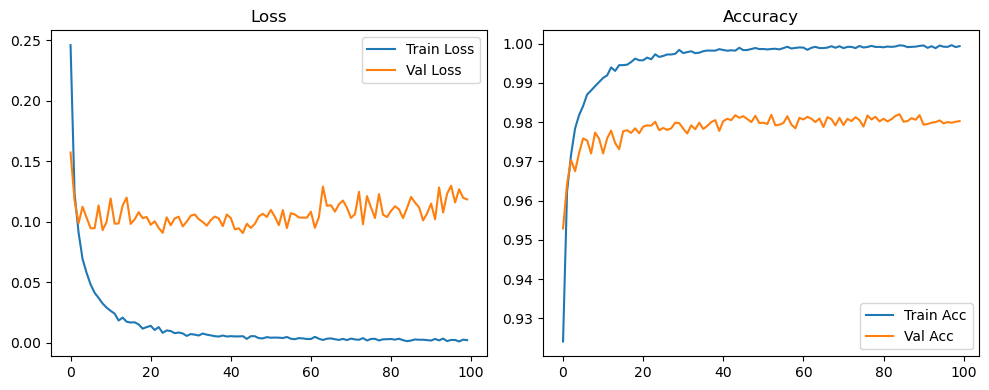

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2632, Acc: 0.9187 | Val Loss: 0.1636, Acc: 0.9529


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1390, Acc: 0.9563 | Val Loss: 0.1142, Acc: 0.9643


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1074, Acc: 0.9665 | Val Loss: 0.1048, Acc: 0.9692


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0883, Acc: 0.9720 | Val Loss: 0.1135, Acc: 0.9676


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0719, Acc: 0.9764 | Val Loss: 0.0993, Acc: 0.9713


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0669, Acc: 0.9784 | Val Loss: 0.0946, Acc: 0.9740


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9817 | Val Loss: 0.0874, Acc: 0.9758


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0491, Acc: 0.9838 | Val Loss: 0.0950, Acc: 0.9748


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9852 | Val Loss: 0.0902, Acc: 0.9764


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0434, Acc: 0.9866 | Val Loss: 0.1007, Acc: 0.9723


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9876 | Val Loss: 0.1043, Acc: 0.9742


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9885 | Val Loss: 0.0891, Acc: 0.9785


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.0911, Acc: 0.9788


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.1017, Acc: 0.9762


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.1092, Acc: 0.9752


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0895, Acc: 0.9791


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9925 | Val Loss: 0.0948, Acc: 0.9762


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0911, Acc: 0.9778


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9940 | Val Loss: 0.0916, Acc: 0.9785


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0801, Acc: 0.9782


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0867, Acc: 0.9782


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0832, Acc: 0.9798


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9943 | Val Loss: 0.0851, Acc: 0.9793


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0906, Acc: 0.9808


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0946, Acc: 0.9792


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0890, Acc: 0.9788


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0981, Acc: 0.9771


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1006, Acc: 0.9774


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0945, Acc: 0.9786


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0909, Acc: 0.9795


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0906, Acc: 0.9793


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0997, Acc: 0.9784


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0895, Acc: 0.9812


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0907, Acc: 0.9791


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0888, Acc: 0.9810


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0934, Acc: 0.9818


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0957, Acc: 0.9806


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0951, Acc: 0.9810


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0944, Acc: 0.9798


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0851, Acc: 0.9815


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0976, Acc: 0.9802


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0872, Acc: 0.9812


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1027, Acc: 0.9799


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1090, Acc: 0.9792


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0949, Acc: 0.9804


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0972, Acc: 0.9795


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0979, Acc: 0.9811


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0983, Acc: 0.9810


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1187, Acc: 0.9791


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0920, Acc: 0.9797


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0918, Acc: 0.9796


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1018, Acc: 0.9800


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0948, Acc: 0.9801


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0901, Acc: 0.9810


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0834, Acc: 0.9820


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0913, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0928, Acc: 0.9826


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0902, Acc: 0.9826


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0901, Acc: 0.9795


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0967, Acc: 0.9804


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1078, Acc: 0.9807


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0921, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0892, Acc: 0.9812


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1018, Acc: 0.9798


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0936, Acc: 0.9803


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0940, Acc: 0.9799


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0960, Acc: 0.9794


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0962, Acc: 0.9793


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0983, Acc: 0.9806


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1090, Acc: 0.9802


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1009, Acc: 0.9806


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1027, Acc: 0.9810


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0994, Acc: 0.9813


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0876, Acc: 0.9811


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0980, Acc: 0.9810


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0915, Acc: 0.9799


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1032, Acc: 0.9804


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0890, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0889, Acc: 0.9821


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0936, Acc: 0.9819


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0855, Acc: 0.9832


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1025, Acc: 0.9817


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0928, Acc: 0.9815


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1052, Acc: 0.9818


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1049, Acc: 0.9823


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0984, Acc: 0.9801


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1049, Acc: 0.9801


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1065, Acc: 0.9806


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0922, Acc: 0.9813


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1055, Acc: 0.9812


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0946, Acc: 0.9794


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0997, Acc: 0.9798


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.1060, Acc: 0.9815


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1081, Acc: 0.9798


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0932, Acc: 0.9798


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1134, Acc: 0.9803


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0960, Acc: 0.9813


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1046, Acc: 0.9814


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1014, Acc: 0.9812


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1225, Acc: 0.9808


Final Test Loss: 0.1117 Accuracy: 0.9830


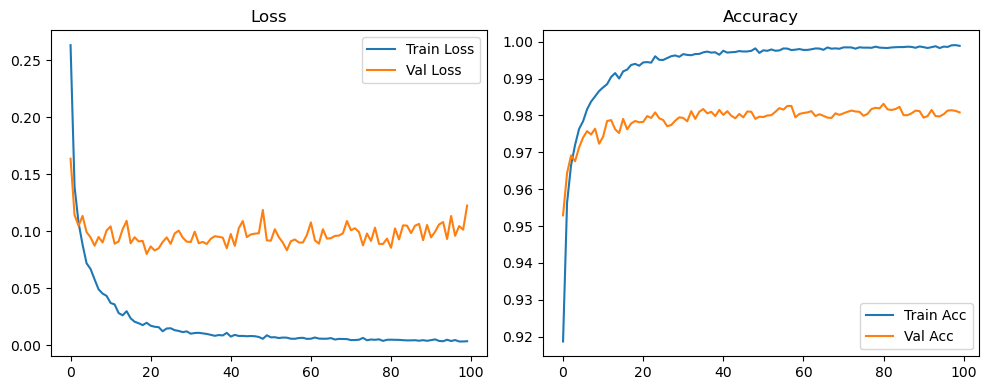

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3325, Acc: 0.8983 | Val Loss: 0.1642, Acc: 0.9505


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2033, Acc: 0.9386 | Val Loss: 0.1230, Acc: 0.9630


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1664, Acc: 0.9497 | Val Loss: 0.1154, Acc: 0.9662


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1474, Acc: 0.9545 | Val Loss: 0.1148, Acc: 0.9653


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1270, Acc: 0.9614 | Val Loss: 0.0967, Acc: 0.9720


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1168, Acc: 0.9633 | Val Loss: 0.0933, Acc: 0.9715


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.1088, Acc: 0.9661 | Val Loss: 0.0893, Acc: 0.9746


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0943, Acc: 0.9709 | Val Loss: 0.0948, Acc: 0.9727


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0895, Acc: 0.9716 | Val Loss: 0.0842, Acc: 0.9768


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0859, Acc: 0.9723 | Val Loss: 0.0885, Acc: 0.9756


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0794, Acc: 0.9752 | Val Loss: 0.0872, Acc: 0.9762


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0743, Acc: 0.9764 | Val Loss: 0.0861, Acc: 0.9752


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9794 | Val Loss: 0.0853, Acc: 0.9769


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9805 | Val Loss: 0.0783, Acc: 0.9778


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9824 | Val Loss: 0.0717, Acc: 0.9801


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0527, Acc: 0.9824 | Val Loss: 0.0784, Acc: 0.9782


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9834 | Val Loss: 0.0729, Acc: 0.9802


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0473, Acc: 0.9844 | Val Loss: 0.0717, Acc: 0.9797


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0453, Acc: 0.9849 | Val Loss: 0.0762, Acc: 0.9800


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9861 | Val Loss: 0.0735, Acc: 0.9788


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0424, Acc: 0.9856 | Val Loss: 0.0770, Acc: 0.9785


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9859 | Val Loss: 0.0758, Acc: 0.9793


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9877 | Val Loss: 0.0775, Acc: 0.9800


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9874 | Val Loss: 0.0719, Acc: 0.9812


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9877 | Val Loss: 0.0715, Acc: 0.9812


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0342, Acc: 0.9886 | Val Loss: 0.0718, Acc: 0.9817


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9881 | Val Loss: 0.0707, Acc: 0.9798


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9882 | Val Loss: 0.0767, Acc: 0.9808


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9896 | Val Loss: 0.0732, Acc: 0.9814


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0311, Acc: 0.9898 | Val Loss: 0.0738, Acc: 0.9800


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9900 | Val Loss: 0.0785, Acc: 0.9807


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9900 | Val Loss: 0.0783, Acc: 0.9806


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0733, Acc: 0.9806


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.0806, Acc: 0.9810


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.0781, Acc: 0.9815


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0774, Acc: 0.9812


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9919 | Val Loss: 0.0891, Acc: 0.9797


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.0750, Acc: 0.9803


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9920 | Val Loss: 0.0720, Acc: 0.9821


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.0764, Acc: 0.9823


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.0790, Acc: 0.9816


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.0772, Acc: 0.9805


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0745, Acc: 0.9808


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0743, Acc: 0.9824


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9925 | Val Loss: 0.0853, Acc: 0.9813


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0803, Acc: 0.9820


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0831, Acc: 0.9815


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9926 | Val Loss: 0.0737, Acc: 0.9821


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0847, Acc: 0.9818


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.0791, Acc: 0.9819


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.0769, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0856, Acc: 0.9812


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9932 | Val Loss: 0.0865, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9933 | Val Loss: 0.0858, Acc: 0.9808


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0905, Acc: 0.9817


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9931 | Val Loss: 0.0839, Acc: 0.9818


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0901, Acc: 0.9817


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9935 | Val Loss: 0.0727, Acc: 0.9828


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.0891, Acc: 0.9816


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9939 | Val Loss: 0.0714, Acc: 0.9829


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0858, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0808, Acc: 0.9836


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0839, Acc: 0.9814


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0779, Acc: 0.9833


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0813, Acc: 0.9829


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0796, Acc: 0.9832


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.0885, Acc: 0.9823


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0772, Acc: 0.9833


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0780, Acc: 0.9818


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9942 | Val Loss: 0.0757, Acc: 0.9821


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.0763, Acc: 0.9819


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9943 | Val Loss: 0.0941, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0764, Acc: 0.9822


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0914, Acc: 0.9809


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0866, Acc: 0.9818


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0769, Acc: 0.9824


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0793, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0788, Acc: 0.9828


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.0776, Acc: 0.9823


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0827, Acc: 0.9825


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0832, Acc: 0.9829


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0836, Acc: 0.9822


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0826, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0814, Acc: 0.9822


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0903, Acc: 0.9810


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0868, Acc: 0.9823


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0899, Acc: 0.9828


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0800, Acc: 0.9832


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0813, Acc: 0.9820


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9944 | Val Loss: 0.0839, Acc: 0.9818


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0859, Acc: 0.9819


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0864, Acc: 0.9818


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0813, Acc: 0.9818


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0783, Acc: 0.9814


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0834, Acc: 0.9816


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0764, Acc: 0.9824


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.0837, Acc: 0.9813


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0778, Acc: 0.9812


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.0811, Acc: 0.9808


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9954 | Val Loss: 0.0872, Acc: 0.9819


Final Test Loss: 0.0748 Accuracy: 0.9826


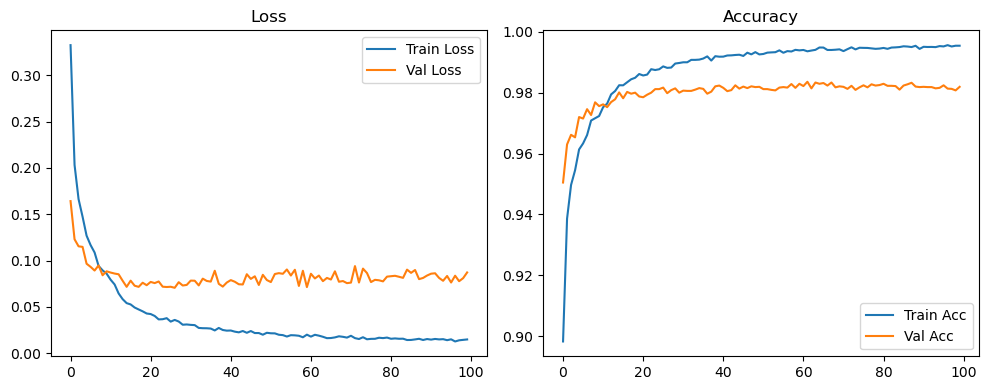

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2233, Acc: 0.9310 | Val Loss: 0.1385, Acc: 0.9577


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1095, Acc: 0.9653 | Val Loss: 0.1079, Acc: 0.9668


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0789, Acc: 0.9753 | Val Loss: 0.0910, Acc: 0.9714


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0623, Acc: 0.9801 | Val Loss: 0.1102, Acc: 0.9692


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0520, Acc: 0.9824 | Val Loss: 0.0980, Acc: 0.9726


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9859 | Val Loss: 0.0961, Acc: 0.9731


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.1042, Acc: 0.9732


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0331, Acc: 0.9894 | Val Loss: 0.1108, Acc: 0.9719


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.1057, Acc: 0.9748


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0286, Acc: 0.9904 | Val Loss: 0.0939, Acc: 0.9767


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.1154, Acc: 0.9728


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0924, Acc: 0.9779


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.1091, Acc: 0.9749


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.1127, Acc: 0.9763


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1048, Acc: 0.9759


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.1100, Acc: 0.9764


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1161, Acc: 0.9745


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1033, Acc: 0.9775


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1177, Acc: 0.9768


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.1124, Acc: 0.9745


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1066, Acc: 0.9780


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1058, Acc: 0.9778


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1135, Acc: 0.9764


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1030, Acc: 0.9791


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1029, Acc: 0.9792


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1128, Acc: 0.9794


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1070, Acc: 0.9782


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1174, Acc: 0.9768


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1141, Acc: 0.9775


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1173, Acc: 0.9772


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.1218, Acc: 0.9772


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1064, Acc: 0.9796


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1161, Acc: 0.9782


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1062, Acc: 0.9796


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1124, Acc: 0.9784


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1283, Acc: 0.9775


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1142, Acc: 0.9802


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1060, Acc: 0.9816


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1116, Acc: 0.9788


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1128, Acc: 0.9793


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1066, Acc: 0.9805


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1081, Acc: 0.9814


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1113, Acc: 0.9793


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1131, Acc: 0.9802


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1293, Acc: 0.9778


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1204, Acc: 0.9782


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1264, Acc: 0.9788


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1245, Acc: 0.9794


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1197, Acc: 0.9808


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1210, Acc: 0.9802


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1229, Acc: 0.9787


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1206, Acc: 0.9802


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1232, Acc: 0.9792


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1154, Acc: 0.9822


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1210, Acc: 0.9801


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1180, Acc: 0.9812


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1476, Acc: 0.9770


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1142, Acc: 0.9808


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1157, Acc: 0.9811


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1235, Acc: 0.9794


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1174, Acc: 0.9813


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1115, Acc: 0.9808


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1143, Acc: 0.9803


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1219, Acc: 0.9802


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1222, Acc: 0.9796


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1191, Acc: 0.9795


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1148, Acc: 0.9822


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1087, Acc: 0.9826


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1342, Acc: 0.9785


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1180, Acc: 0.9801


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1168, Acc: 0.9820


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1231, Acc: 0.9791


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1198, Acc: 0.9805


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1137, Acc: 0.9808


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1227, Acc: 0.9803


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1105, Acc: 0.9826


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1166, Acc: 0.9827


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1175, Acc: 0.9801


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1045, Acc: 0.9828


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1087, Acc: 0.9830


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1041, Acc: 0.9820


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1157, Acc: 0.9805


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1085, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1070, Acc: 0.9820


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1178, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1174, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1178, Acc: 0.9801


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1230, Acc: 0.9811


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1169, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1147, Acc: 0.9815


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1151, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1096, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1059, Acc: 0.9821


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1161, Acc: 0.9809


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1198, Acc: 0.9799


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1171, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9991 | Val Loss: 0.1296, Acc: 0.9782


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1094, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1065, Acc: 0.9811


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1280, Acc: 0.9790


Final Test Loss: 0.1168 Accuracy: 0.9810


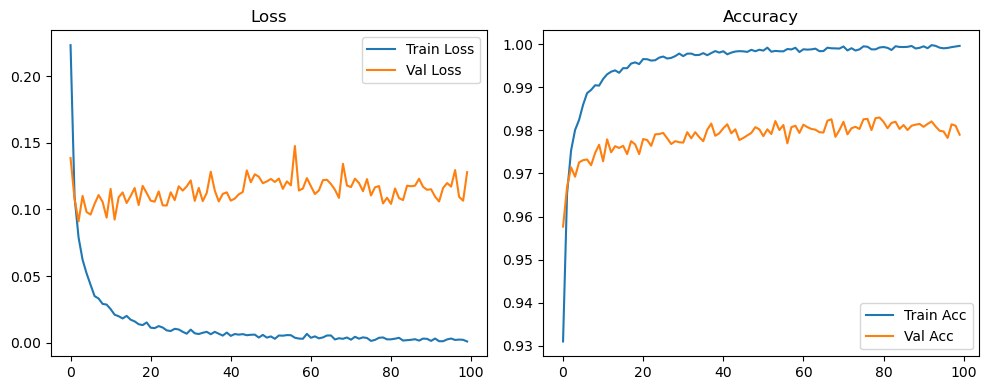

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2442, Acc: 0.9236 | Val Loss: 0.1392, Acc: 0.9583


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1279, Acc: 0.9603 | Val Loss: 0.1070, Acc: 0.9648


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0986, Acc: 0.9685 | Val Loss: 0.0959, Acc: 0.9700


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0780, Acc: 0.9746 | Val Loss: 0.1031, Acc: 0.9697


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0687, Acc: 0.9778 | Val Loss: 0.0881, Acc: 0.9739


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0563, Acc: 0.9815 | Val Loss: 0.0873, Acc: 0.9742


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0554, Acc: 0.9816 | Val Loss: 0.0920, Acc: 0.9748


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9858 | Val Loss: 0.0994, Acc: 0.9728


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9862 | Val Loss: 0.0897, Acc: 0.9763


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9869 | Val Loss: 0.0965, Acc: 0.9756


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9888 | Val Loss: 0.1051, Acc: 0.9752


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.0927, Acc: 0.9759


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.1055, Acc: 0.9752


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.0997, Acc: 0.9765


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9920 | Val Loss: 0.1096, Acc: 0.9758


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0915, Acc: 0.9782


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9930 | Val Loss: 0.1030, Acc: 0.9770


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.0974, Acc: 0.9772


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9935 | Val Loss: 0.0941, Acc: 0.9789


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0991, Acc: 0.9784


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0938, Acc: 0.9793


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0886, Acc: 0.9815


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1000, Acc: 0.9788


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0948, Acc: 0.9798


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0965, Acc: 0.9798


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1011, Acc: 0.9792


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.1001, Acc: 0.9788


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1058, Acc: 0.9785


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0926, Acc: 0.9808


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.1192, Acc: 0.9777


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0931, Acc: 0.9810


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0965, Acc: 0.9789


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9963 | Val Loss: 0.0943, Acc: 0.9795


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1065, Acc: 0.9788


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.0994, Acc: 0.9807


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1064, Acc: 0.9782


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9967 | Val Loss: 0.1000, Acc: 0.9807


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9970 | Val Loss: 0.1029, Acc: 0.9789


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1000, Acc: 0.9798


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1106, Acc: 0.9797


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1119, Acc: 0.9786


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0958, Acc: 0.9828


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.0998, Acc: 0.9808


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1110, Acc: 0.9793


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1134, Acc: 0.9802


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.1040, Acc: 0.9801


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1098, Acc: 0.9792


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0974, Acc: 0.9808


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1016, Acc: 0.9802


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1064, Acc: 0.9807


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1013, Acc: 0.9806


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0990, Acc: 0.9816


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1021, Acc: 0.9818


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1177, Acc: 0.9813


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1051, Acc: 0.9828


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1022, Acc: 0.9823


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1158, Acc: 0.9804


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1032, Acc: 0.9826


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1153, Acc: 0.9799


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1224, Acc: 0.9790


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1157, Acc: 0.9816


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1061, Acc: 0.9810


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1098, Acc: 0.9802


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9974 | Val Loss: 0.1070, Acc: 0.9808


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1166, Acc: 0.9806


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1168, Acc: 0.9789


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1157, Acc: 0.9816


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1099, Acc: 0.9807


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1138, Acc: 0.9811


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1093, Acc: 0.9812


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0992, Acc: 0.9825


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1088, Acc: 0.9808


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1049, Acc: 0.9813


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1037, Acc: 0.9812


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1043, Acc: 0.9801


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1138, Acc: 0.9792


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1027, Acc: 0.9818


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1070, Acc: 0.9813


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1122, Acc: 0.9810


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0958, Acc: 0.9811


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0980, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1046, Acc: 0.9809


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1036, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0947, Acc: 0.9820


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0978, Acc: 0.9824


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1016, Acc: 0.9820


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1058, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0910, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0947, Acc: 0.9819


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1054, Acc: 0.9817


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1049, Acc: 0.9808


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1062, Acc: 0.9811


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1031, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1066, Acc: 0.9816


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1044, Acc: 0.9811


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0977, Acc: 0.9833


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1011, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0919, Acc: 0.9819


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1113, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1089, Acc: 0.9817


Final Test Loss: 0.0898 Accuracy: 0.9831


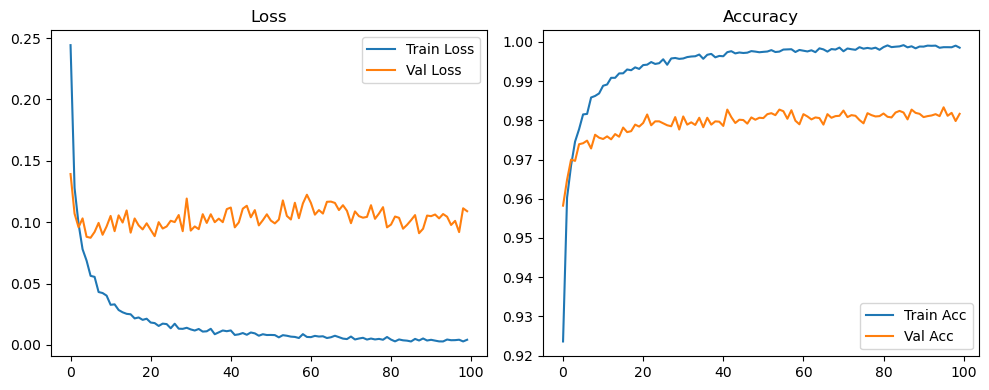

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3246, Acc: 0.8994 | Val Loss: 0.1513, Acc: 0.9546


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1899, Acc: 0.9407 | Val Loss: 0.1183, Acc: 0.9631


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1566, Acc: 0.9516 | Val Loss: 0.1088, Acc: 0.9673


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1342, Acc: 0.9580 | Val Loss: 0.1032, Acc: 0.9688


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1222, Acc: 0.9616 | Val Loss: 0.0928, Acc: 0.9721


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1108, Acc: 0.9656 | Val Loss: 0.0926, Acc: 0.9725


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1015, Acc: 0.9680 | Val Loss: 0.0844, Acc: 0.9739


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0970, Acc: 0.9704 | Val Loss: 0.0942, Acc: 0.9715


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0865, Acc: 0.9726 | Val Loss: 0.0817, Acc: 0.9763


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0855, Acc: 0.9726 | Val Loss: 0.0894, Acc: 0.9728


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0761, Acc: 0.9756 | Val Loss: 0.0860, Acc: 0.9763


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0682, Acc: 0.9782 | Val Loss: 0.0815, Acc: 0.9760


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0670, Acc: 0.9783 | Val Loss: 0.0812, Acc: 0.9772


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0628, Acc: 0.9795 | Val Loss: 0.0818, Acc: 0.9778


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0620, Acc: 0.9796 | Val Loss: 0.0789, Acc: 0.9782


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0589, Acc: 0.9807 | Val Loss: 0.0797, Acc: 0.9776


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0561, Acc: 0.9816 | Val Loss: 0.0871, Acc: 0.9773


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0494, Acc: 0.9836 | Val Loss: 0.0802, Acc: 0.9794


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9850 | Val Loss: 0.0846, Acc: 0.9781


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0496, Acc: 0.9842 | Val Loss: 0.0782, Acc: 0.9795


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9849 | Val Loss: 0.0791, Acc: 0.9790


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9863 | Val Loss: 0.0817, Acc: 0.9791


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0405, Acc: 0.9866 | Val Loss: 0.0771, Acc: 0.9798


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 0.0821, Acc: 0.9797


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9866 | Val Loss: 0.0782, Acc: 0.9793


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9864 | Val Loss: 0.0787, Acc: 0.9798


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0389, Acc: 0.9874 | Val Loss: 0.0772, Acc: 0.9798


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.0802, Acc: 0.9800


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.0792, Acc: 0.9806


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9889 | Val Loss: 0.0817, Acc: 0.9797


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9891 | Val Loss: 0.0892, Acc: 0.9786


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9898 | Val Loss: 0.0823, Acc: 0.9796


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9907 | Val Loss: 0.0830, Acc: 0.9803


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9912 | Val Loss: 0.0872, Acc: 0.9792


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.0817, Acc: 0.9813


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0849, Acc: 0.9793


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9913 | Val Loss: 0.0856, Acc: 0.9814


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0752, Acc: 0.9816


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9912 | Val Loss: 0.0798, Acc: 0.9819


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0760, Acc: 0.9815


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.0803, Acc: 0.9819


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9931 | Val Loss: 0.0815, Acc: 0.9815


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.0802, Acc: 0.9802


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0771, Acc: 0.9811


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0789, Acc: 0.9813


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.0773, Acc: 0.9823


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9925 | Val Loss: 0.0754, Acc: 0.9816


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0812, Acc: 0.9806


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.0802, Acc: 0.9808


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9938 | Val Loss: 0.0802, Acc: 0.9824


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.0783, Acc: 0.9814


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0766, Acc: 0.9818


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0753, Acc: 0.9818


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0176, Acc: 0.9942 | Val Loss: 0.0808, Acc: 0.9812


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0781, Acc: 0.9820


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.0765, Acc: 0.9822


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0787, Acc: 0.9819


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0792, Acc: 0.9814


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.0767, Acc: 0.9822


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.0859, Acc: 0.9814


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0784, Acc: 0.9831


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0843, Acc: 0.9804


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0805, Acc: 0.9821


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0752, Acc: 0.9828


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0824, Acc: 0.9816


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0817, Acc: 0.9815


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9948 | Val Loss: 0.0863, Acc: 0.9817


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0832, Acc: 0.9806


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.0858, Acc: 0.9830


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0858, Acc: 0.9812


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0783, Acc: 0.9828


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0832, Acc: 0.9822


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9953 | Val Loss: 0.0854, Acc: 0.9815


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0818, Acc: 0.9827


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0863, Acc: 0.9808


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.0794, Acc: 0.9807


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.0826, Acc: 0.9825


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.0842, Acc: 0.9821


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0840, Acc: 0.9828


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0809, Acc: 0.9828


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0756, Acc: 0.9823


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0810, Acc: 0.9823


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0839, Acc: 0.9820


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0807, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0790, Acc: 0.9824


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.0853, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0834, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0876, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0859, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0834, Acc: 0.9819


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.0889, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0859, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0766, Acc: 0.9833


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0848, Acc: 0.9830


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0905, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0810, Acc: 0.9833


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0810, Acc: 0.9820


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0814, Acc: 0.9829


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0885, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9957 | Val Loss: 0.0911, Acc: 0.9818


Final Test Loss: 0.0792 Accuracy: 0.9844


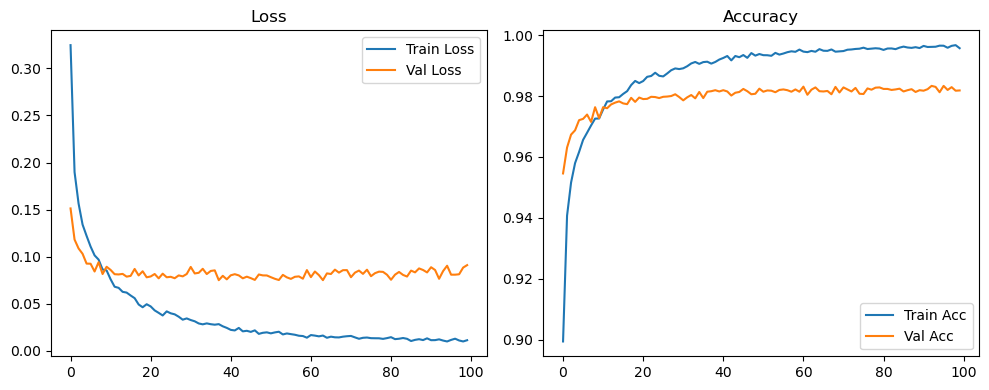

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2662, Acc: 0.9221 | Val Loss: 0.1592, Acc: 0.9555


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9638 | Val Loss: 0.1230, Acc: 0.9623


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9739 | Val Loss: 0.0999, Acc: 0.9692


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9810 | Val Loss: 0.1091, Acc: 0.9677


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9844 | Val Loss: 0.1198, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9857 | Val Loss: 0.1103, Acc: 0.9710


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9876 | Val Loss: 0.1070, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.1197, Acc: 0.9707


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.1013, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0953, Acc: 0.9738


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.1128, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1226, Acc: 0.9727


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1285, Acc: 0.9694


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.1117, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.1154, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.1116, Acc: 0.9729


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1086, Acc: 0.9752


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1168, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1123, Acc: 0.9761


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1271, Acc: 0.9706


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1191, Acc: 0.9726


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1093, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1258, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1092, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1134, Acc: 0.9747


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0973, Acc: 0.9745


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1370, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1201, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1224, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1113, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1140, Acc: 0.9787


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1301, Acc: 0.9787


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1253, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1351, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1050, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1199, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1037, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1201, Acc: 0.9760


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1123, Acc: 0.9783


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1472, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0907, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1214, Acc: 0.9752


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1467, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0949, Acc: 0.9763


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1278, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0923, Acc: 0.9798


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1730, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1288, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1351, Acc: 0.9770


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1147, Acc: 0.9776


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1001, Acc: 0.9757


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1649, Acc: 0.9747


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1442, Acc: 0.9768


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1701, Acc: 0.9763


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1512, Acc: 0.9778


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1272, Acc: 0.9763


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1042, Acc: 0.9771


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1821, Acc: 0.9772


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1323, Acc: 0.9772


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0864, Acc: 0.9767


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1313, Acc: 0.9778


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1268, Acc: 0.9782


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1650, Acc: 0.9781


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1311, Acc: 0.9762


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1934, Acc: 0.9769


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1312, Acc: 0.9779


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1491, Acc: 0.9786


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1445, Acc: 0.9777


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1062, Acc: 0.9751


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1084, Acc: 0.9769


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1614, Acc: 0.9775


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1518, Acc: 0.9788


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1346, Acc: 0.9768


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1201, Acc: 0.9802


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1499, Acc: 0.9764


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1159, Acc: 0.9772


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1064, Acc: 0.9773


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1103, Acc: 0.9768


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1187, Acc: 0.9747


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1602, Acc: 0.9762


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1405, Acc: 0.9778


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1421, Acc: 0.9775


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1189, Acc: 0.9782


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1056, Acc: 0.9802


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1397, Acc: 0.9749


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1291, Acc: 0.9768


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1537, Acc: 0.9770


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.2040, Acc: 0.9778


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1334, Acc: 0.9762


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1831, Acc: 0.9753


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1777, Acc: 0.9780


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1231, Acc: 0.9767


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1696, Acc: 0.9745


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1635, Acc: 0.9762


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1962, Acc: 0.9762


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1775, Acc: 0.9746


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1482, Acc: 0.9749


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2019, Acc: 0.9764


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1753, Acc: 0.9783


Final Test Loss: 0.1562 Accuracy: 0.9795


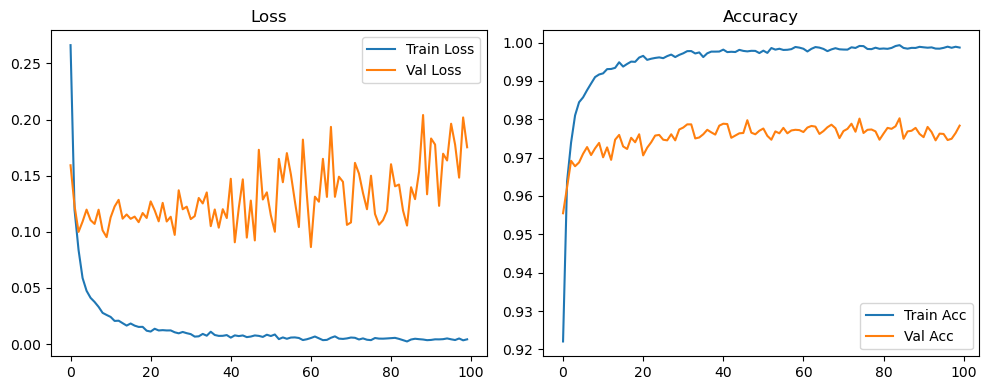

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2802, Acc: 0.9180 | Val Loss: 0.1842, Acc: 0.9464


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9582 | Val Loss: 0.1156, Acc: 0.9638


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0970, Acc: 0.9704 | Val Loss: 0.0993, Acc: 0.9701


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9753 | Val Loss: 0.1052, Acc: 0.9686


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9790 | Val Loss: 0.1004, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9816 | Val Loss: 0.0929, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9831 | Val Loss: 0.0903, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9861 | Val Loss: 0.0988, Acc: 0.9731


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9876 | Val Loss: 0.0896, Acc: 0.9767


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.1008, Acc: 0.9729


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.1128, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.0860, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9885 | Val Loss: 0.0997, Acc: 0.9757


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1030, Acc: 0.9757


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1041, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.0932, Acc: 0.9750


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.0926, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0919, Acc: 0.9766


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1121, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0896, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1167, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0938, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.1033, Acc: 0.9780


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0923, Acc: 0.9773


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1072, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0976, Acc: 0.9791


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9937 | Val Loss: 0.1065, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0959, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1127, Acc: 0.9763


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1492, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0895, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1079, Acc: 0.9766


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0990, Acc: 0.9780


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9949 | Val Loss: 0.0915, Acc: 0.9780


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0997, Acc: 0.9753


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0931, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0857, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0828, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0819, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0998, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1010, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0991, Acc: 0.9780


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0886, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1041, Acc: 0.9787


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1038, Acc: 0.9789


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.1148, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0855, Acc: 0.9790


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0989, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0774, Acc: 0.9793


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1344, Acc: 0.9798


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.1137, Acc: 0.9789


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0822, Acc: 0.9793


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1220, Acc: 0.9797


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0931, Acc: 0.9786


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1045, Acc: 0.9788


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1058, Acc: 0.9797


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.1036, Acc: 0.9777


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1287, Acc: 0.9795


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.1390, Acc: 0.9789


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0787, Acc: 0.9775


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.1049, Acc: 0.9789


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.1230, Acc: 0.9768


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.1077, Acc: 0.9789


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0731, Acc: 0.9802


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1306, Acc: 0.9787


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1109, Acc: 0.9789


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1297, Acc: 0.9767


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9963 | Val Loss: 0.0781, Acc: 0.9778


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1032, Acc: 0.9789


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1138, Acc: 0.9790


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1237, Acc: 0.9777


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0960, Acc: 0.9776


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1324, Acc: 0.9776


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1309, Acc: 0.9777


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0936, Acc: 0.9783


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1403, Acc: 0.9792


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0977, Acc: 0.9779


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0822, Acc: 0.9773


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1115, Acc: 0.9787


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1247, Acc: 0.9779


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0937, Acc: 0.9774


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1115, Acc: 0.9779


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1198, Acc: 0.9778


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1461, Acc: 0.9784


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.1071, Acc: 0.9780


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.1145, Acc: 0.9767


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1214, Acc: 0.9782


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.1011, Acc: 0.9791


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0956, Acc: 0.9769


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0887, Acc: 0.9800


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1196, Acc: 0.9786


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0946, Acc: 0.9791


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1099, Acc: 0.9789


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1130, Acc: 0.9776


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0748, Acc: 0.9781


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1267, Acc: 0.9784


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1294, Acc: 0.9778


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1285, Acc: 0.9792


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.1057, Acc: 0.9774


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1200, Acc: 0.9772


Final Test Loss: 0.1159 Accuracy: 0.9789


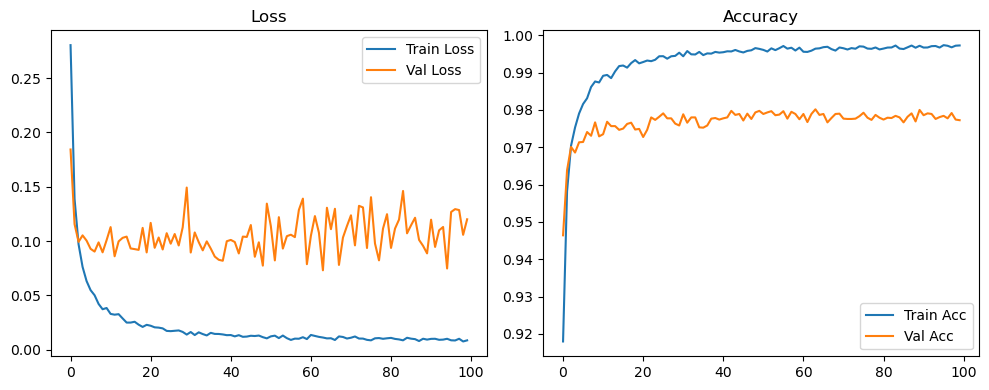

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3593, Acc: 0.8952 | Val Loss: 0.1797, Acc: 0.9487


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9406 | Val Loss: 0.1308, Acc: 0.9573


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9564 | Val Loss: 0.1103, Acc: 0.9666


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1220, Acc: 0.9625 | Val Loss: 0.1066, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1098, Acc: 0.9661 | Val Loss: 0.0946, Acc: 0.9709


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1013, Acc: 0.9685 | Val Loss: 0.0915, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9702 | Val Loss: 0.0861, Acc: 0.9740


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9721 | Val Loss: 0.0949, Acc: 0.9716


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9755


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9736 | Val Loss: 0.0890, Acc: 0.9750


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9750 | Val Loss: 0.0830, Acc: 0.9767


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9771 | Val Loss: 0.0846, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9766 | Val Loss: 0.0820, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9776 | Val Loss: 0.0841, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9790 | Val Loss: 0.0847, Acc: 0.9762


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9804 | Val Loss: 0.0846, Acc: 0.9781


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.0903, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9805 | Val Loss: 0.0819, Acc: 0.9774


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9805 | Val Loss: 0.0876, Acc: 0.9770


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9810 | Val Loss: 0.0763, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9818 | Val Loss: 0.0852, Acc: 0.9784


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9822 | Val Loss: 0.0817, Acc: 0.9774


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9822 | Val Loss: 0.0865, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.0800, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9825 | Val Loss: 0.0868, Acc: 0.9757


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9828 | Val Loss: 0.0828, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9835 | Val Loss: 0.0856, Acc: 0.9773


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9831 | Val Loss: 0.0855, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9833 | Val Loss: 0.0865, Acc: 0.9780


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0802, Acc: 0.9787


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9848 | Val Loss: 0.0853, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 0.0867, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9848 | Val Loss: 0.0891, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9858 | Val Loss: 0.0972, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0897, Acc: 0.9787


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0768, Acc: 0.9775


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9848 | Val Loss: 0.0893, Acc: 0.9775


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9854 | Val Loss: 0.0891, Acc: 0.9769


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 0.0796, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9850 | Val Loss: 0.0830, Acc: 0.9782


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.0762, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9866 | Val Loss: 0.0725, Acc: 0.9791


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 0.0881, Acc: 0.9774


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9858 | Val Loss: 0.0819, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9854 | Val Loss: 0.0945, Acc: 0.9786


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0857, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9855 | Val Loss: 0.0866, Acc: 0.9782


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.0954, Acc: 0.9787


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0809, Acc: 0.9787


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9862 | Val Loss: 0.0735, Acc: 0.9801


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9860 | Val Loss: 0.0825, Acc: 0.9798


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0425, Acc: 0.9863 | Val Loss: 0.1109, Acc: 0.9781


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.0795, Acc: 0.9791


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0833, Acc: 0.9797


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9854 | Val Loss: 0.0726, Acc: 0.9795


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9877 | Val Loss: 0.0944, Acc: 0.9788


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9860 | Val Loss: 0.0785, Acc: 0.9792


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0400, Acc: 0.9871 | Val Loss: 0.0830, Acc: 0.9782


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9871 | Val Loss: 0.0772, Acc: 0.9792


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9876 | Val Loss: 0.0907, Acc: 0.9783


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9863 | Val Loss: 0.1060, Acc: 0.9788


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9869 | Val Loss: 0.0895, Acc: 0.9785


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.0841, Acc: 0.9781


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9876 | Val Loss: 0.0974, Acc: 0.9792


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9857 | Val Loss: 0.0850, Acc: 0.9788


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0429, Acc: 0.9859 | Val Loss: 0.0728, Acc: 0.9788


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9875 | Val Loss: 0.0884, Acc: 0.9789


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9884 | Val Loss: 0.1069, Acc: 0.9789


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9864 | Val Loss: 0.0810, Acc: 0.9785


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9869 | Val Loss: 0.0891, Acc: 0.9787


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9876 | Val Loss: 0.0760, Acc: 0.9796


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0393, Acc: 0.9878 | Val Loss: 0.0847, Acc: 0.9768


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9877 | Val Loss: 0.0997, Acc: 0.9790


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0383, Acc: 0.9877 | Val Loss: 0.0960, Acc: 0.9774


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9875 | Val Loss: 0.0872, Acc: 0.9778


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9877 | Val Loss: 0.0903, Acc: 0.9777


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9876 | Val Loss: 0.0972, Acc: 0.9792


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9867 | Val Loss: 0.0872, Acc: 0.9776


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9872 | Val Loss: 0.0817, Acc: 0.9780


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.0933, Acc: 0.9789


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0360, Acc: 0.9885 | Val Loss: 0.0853, Acc: 0.9792


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 0.0954, Acc: 0.9794


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9879 | Val Loss: 0.0835, Acc: 0.9792


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9883 | Val Loss: 0.0749, Acc: 0.9800


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0849, Acc: 0.9796


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9872 | Val Loss: 0.0863, Acc: 0.9787


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0387, Acc: 0.9872 | Val Loss: 0.0831, Acc: 0.9791


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.0803, Acc: 0.9789


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.0787, Acc: 0.9802


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9884 | Val Loss: 0.0728, Acc: 0.9792


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9877 | Val Loss: 0.0865, Acc: 0.9783


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9883 | Val Loss: 0.0802, Acc: 0.9781


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.0941, Acc: 0.9798


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9887 | Val Loss: 0.0894, Acc: 0.9792


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 0.1012, Acc: 0.9792


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9884 | Val Loss: 0.1013, Acc: 0.9787


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0377, Acc: 0.9879 | Val Loss: 0.0879, Acc: 0.9787


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0358, Acc: 0.9882 | Val Loss: 0.0926, Acc: 0.9802


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9882 | Val Loss: 0.1076, Acc: 0.9808


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0351, Acc: 0.9887 | Val Loss: 0.0796, Acc: 0.9791


Final Test Loss: 0.0748 Accuracy: 0.9796


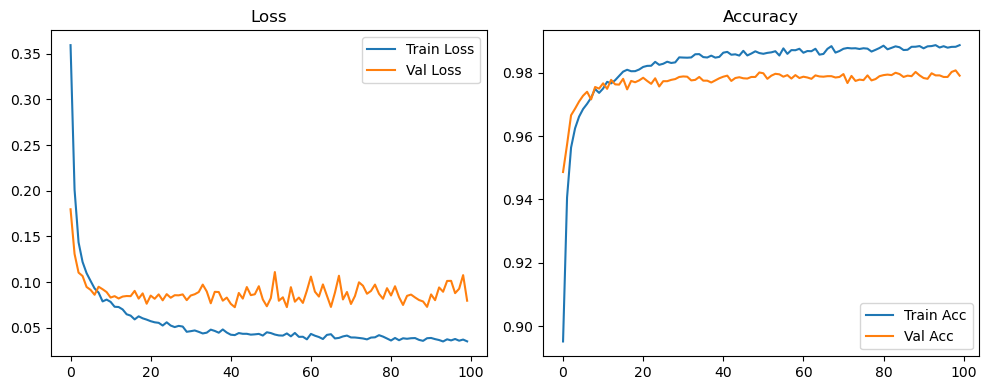

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2665, Acc: 0.9217 | Val Loss: 0.1529, Acc: 0.9573


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9629 | Val Loss: 0.1168, Acc: 0.9652


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0859, Acc: 0.9735 | Val Loss: 0.1130, Acc: 0.9665


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9813 | Val Loss: 0.1096, Acc: 0.9703


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9848 | Val Loss: 0.1199, Acc: 0.9671


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.1151, Acc: 0.9690


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9883 | Val Loss: 0.1015, Acc: 0.9745


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.1070, Acc: 0.9727


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.1009, Acc: 0.9739


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0294, Acc: 0.9898 | Val Loss: 0.1035, Acc: 0.9738


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9921 | Val Loss: 0.0968, Acc: 0.9729


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.1251, Acc: 0.9695


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9929 | Val Loss: 0.1115, Acc: 0.9704


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9937 | Val Loss: 0.1302, Acc: 0.9727


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.1145, Acc: 0.9733


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1160, Acc: 0.9726


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1136, Acc: 0.9742


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9945 | Val Loss: 0.1244, Acc: 0.9732


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1226, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9961 | Val Loss: 0.1051, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1263, Acc: 0.9743


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1203, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1167, Acc: 0.9756


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.0912, Acc: 0.9780


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1125, Acc: 0.9729


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1240, Acc: 0.9761


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0888, Acc: 0.9761


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1215, Acc: 0.9741


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1264, Acc: 0.9738


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1283, Acc: 0.9766


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1264, Acc: 0.9758


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.1116, Acc: 0.9773


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1039, Acc: 0.9781


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.0931, Acc: 0.9785


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1275, Acc: 0.9746


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.1138, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1350, Acc: 0.9774


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1232, Acc: 0.9785


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1126, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1379, Acc: 0.9787


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1219, Acc: 0.9767


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1190, Acc: 0.9769


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1458, Acc: 0.9779


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1138, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1447, Acc: 0.9772


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1396, Acc: 0.9775


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1124, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1211, Acc: 0.9775


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1360, Acc: 0.9767


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1103, Acc: 0.9739


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1045, Acc: 0.9791


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1141, Acc: 0.9778


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1843, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1721, Acc: 0.9768


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1412, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1406, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1555, Acc: 0.9786


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1595, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1281, Acc: 0.9789


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1279, Acc: 0.9794


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1209, Acc: 0.9799


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1252, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1468, Acc: 0.9788


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1854, Acc: 0.9790


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1164, Acc: 0.9791


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1412, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1643, Acc: 0.9792


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1283, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1159, Acc: 0.9782


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1289, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1473, Acc: 0.9782


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1628, Acc: 0.9780


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1350, Acc: 0.9777


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1534, Acc: 0.9790


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1117, Acc: 0.9785


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1331, Acc: 0.9784


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1624, Acc: 0.9788


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1498, Acc: 0.9784


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1633, Acc: 0.9787


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1816, Acc: 0.9788


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2025, Acc: 0.9792


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2006, Acc: 0.9792


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1995, Acc: 0.9793


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1906, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1840, Acc: 0.9792


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2151, Acc: 0.9796


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2188, Acc: 0.9797


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1428, Acc: 0.9794


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1533, Acc: 0.9800


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1868, Acc: 0.9801


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1887, Acc: 0.9786


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1811, Acc: 0.9792


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1584, Acc: 0.9790


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1528, Acc: 0.9792


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1978, Acc: 0.9785


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2074, Acc: 0.9786


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1837, Acc: 0.9795


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1803, Acc: 0.9805


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2134, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.2118, Acc: 0.9794


Final Test Loss: 0.1859 Accuracy: 0.9822


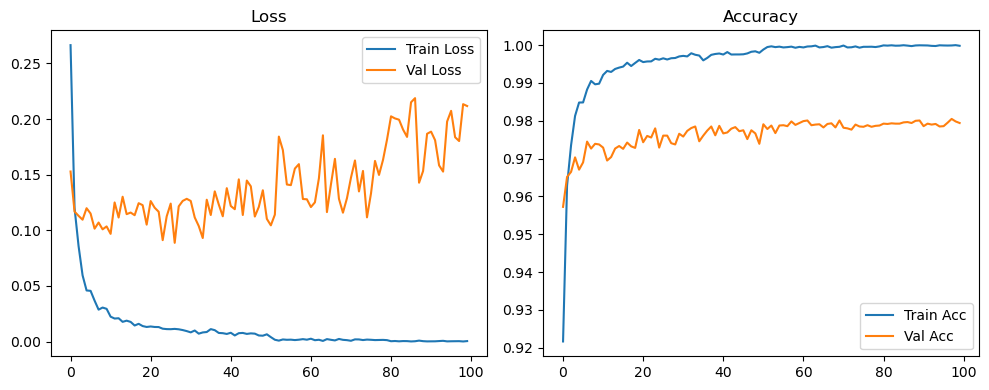

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2802, Acc: 0.9180 | Val Loss: 0.1842, Acc: 0.9464


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9582 | Val Loss: 0.1156, Acc: 0.9638


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0970, Acc: 0.9704 | Val Loss: 0.0993, Acc: 0.9701


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9753 | Val Loss: 0.1052, Acc: 0.9686


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9790 | Val Loss: 0.1004, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9816 | Val Loss: 0.0929, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9831 | Val Loss: 0.0903, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9861 | Val Loss: 0.0988, Acc: 0.9731


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9876 | Val Loss: 0.0896, Acc: 0.9767


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.1008, Acc: 0.9729


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.1128, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.0860, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9885 | Val Loss: 0.0997, Acc: 0.9757


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1030, Acc: 0.9757


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1041, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.0932, Acc: 0.9750


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.0926, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0919, Acc: 0.9766


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1121, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0896, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1167, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0938, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.1033, Acc: 0.9780


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0923, Acc: 0.9773


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1072, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0976, Acc: 0.9791


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9937 | Val Loss: 0.1065, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0959, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1127, Acc: 0.9763


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1492, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0895, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1079, Acc: 0.9766


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0990, Acc: 0.9780


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9949 | Val Loss: 0.0915, Acc: 0.9780


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0997, Acc: 0.9753


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0931, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0857, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0828, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0819, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0998, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1010, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0991, Acc: 0.9780


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0886, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1041, Acc: 0.9787


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1038, Acc: 0.9789


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.1148, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0855, Acc: 0.9790


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0989, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0774, Acc: 0.9793


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1344, Acc: 0.9798


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9972 | Val Loss: 0.0937, Acc: 0.9820


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.0969, Acc: 0.9804


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1249, Acc: 0.9801


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1058, Acc: 0.9816


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0973, Acc: 0.9806


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1346, Acc: 0.9823


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1057, Acc: 0.9807


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0963, Acc: 0.9810


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1110, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1034, Acc: 0.9803


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1242, Acc: 0.9799


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1140, Acc: 0.9799


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0991, Acc: 0.9805


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1166, Acc: 0.9804


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1091, Acc: 0.9801


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1278, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1049, Acc: 0.9813


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0936, Acc: 0.9801


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1102, Acc: 0.9792


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1213, Acc: 0.9808


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0972, Acc: 0.9803


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1231, Acc: 0.9804


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1113, Acc: 0.9812


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1347, Acc: 0.9823


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1162, Acc: 0.9817


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1440, Acc: 0.9800


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1203, Acc: 0.9800


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1104, Acc: 0.9826


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1245, Acc: 0.9803


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1236, Acc: 0.9813


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1203, Acc: 0.9814


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1101, Acc: 0.9810


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1341, Acc: 0.9812


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1154, Acc: 0.9821


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0988, Acc: 0.9819


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1449, Acc: 0.9831


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1349, Acc: 0.9828


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1313, Acc: 0.9819


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1288, Acc: 0.9815


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1613, Acc: 0.9811


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1343, Acc: 0.9820


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1217, Acc: 0.9821


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1103, Acc: 0.9814


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1133, Acc: 0.9821


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1168, Acc: 0.9822


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1134, Acc: 0.9828


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1233, Acc: 0.9826


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1039, Acc: 0.9820


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1513, Acc: 0.9821


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1517, Acc: 0.9816


Final Test Loss: 0.1426 Accuracy: 0.9837


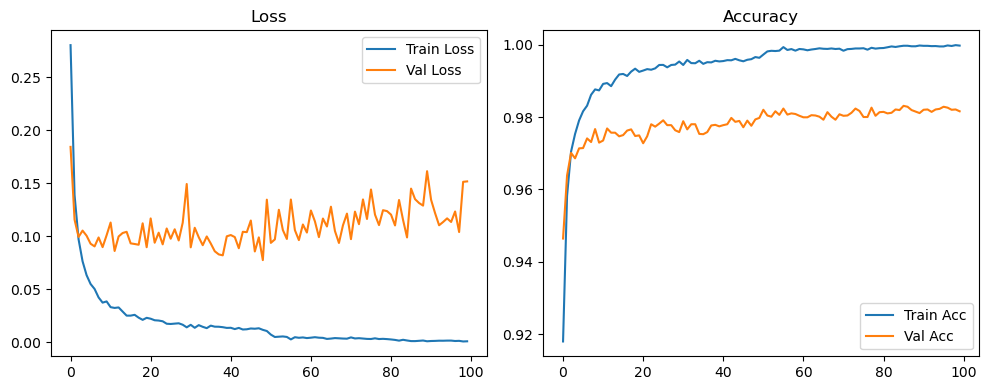

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3593, Acc: 0.8952 | Val Loss: 0.1797, Acc: 0.9487


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9406 | Val Loss: 0.1308, Acc: 0.9573


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9564 | Val Loss: 0.1103, Acc: 0.9666


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1220, Acc: 0.9625 | Val Loss: 0.1066, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1098, Acc: 0.9661 | Val Loss: 0.0946, Acc: 0.9709


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1013, Acc: 0.9685 | Val Loss: 0.0915, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9702 | Val Loss: 0.0861, Acc: 0.9740


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9721 | Val Loss: 0.0949, Acc: 0.9716


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9755


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9736 | Val Loss: 0.0890, Acc: 0.9750


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9750 | Val Loss: 0.0830, Acc: 0.9767


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9771 | Val Loss: 0.0846, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9766 | Val Loss: 0.0820, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9776 | Val Loss: 0.0841, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9790 | Val Loss: 0.0847, Acc: 0.9762


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9804 | Val Loss: 0.0846, Acc: 0.9781


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.0903, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9805 | Val Loss: 0.0819, Acc: 0.9774


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9805 | Val Loss: 0.0876, Acc: 0.9770


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9810 | Val Loss: 0.0763, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9818 | Val Loss: 0.0852, Acc: 0.9784


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9822 | Val Loss: 0.0817, Acc: 0.9774


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9822 | Val Loss: 0.0865, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.0800, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9825 | Val Loss: 0.0868, Acc: 0.9757


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9828 | Val Loss: 0.0828, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9835 | Val Loss: 0.0856, Acc: 0.9773


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9831 | Val Loss: 0.0855, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9833 | Val Loss: 0.0865, Acc: 0.9780


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0802, Acc: 0.9787


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9848 | Val Loss: 0.0853, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 0.0867, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9848 | Val Loss: 0.0891, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9858 | Val Loss: 0.0972, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0897, Acc: 0.9787


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0768, Acc: 0.9775


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9848 | Val Loss: 0.0893, Acc: 0.9775


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9854 | Val Loss: 0.0891, Acc: 0.9769


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 0.0796, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9850 | Val Loss: 0.0830, Acc: 0.9782


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.0762, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9866 | Val Loss: 0.0725, Acc: 0.9791


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 0.0881, Acc: 0.9774


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9858 | Val Loss: 0.0819, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9854 | Val Loss: 0.0945, Acc: 0.9786


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0857, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9855 | Val Loss: 0.0866, Acc: 0.9782


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.0954, Acc: 0.9787


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0809, Acc: 0.9787


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9862 | Val Loss: 0.0735, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.0831, Acc: 0.9808


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0809, Acc: 0.9795


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.0793, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0873, Acc: 0.9804


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0939, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0868, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0760, Acc: 0.9805


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.0771, Acc: 0.9804


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0820, Acc: 0.9799


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0877, Acc: 0.9808


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0817, Acc: 0.9812


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0978, Acc: 0.9812


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.1031, Acc: 0.9807


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0859, Acc: 0.9817


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0893, Acc: 0.9807


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0943, Acc: 0.9801


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0883, Acc: 0.9795


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9938 | Val Loss: 0.0734, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0808, Acc: 0.9808


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0855, Acc: 0.9821


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0781, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0997, Acc: 0.9802


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0748, Acc: 0.9813


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0892, Acc: 0.9806


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0900, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0816, Acc: 0.9809


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0982, Acc: 0.9807


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0810, Acc: 0.9822


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0884, Acc: 0.9822


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0820, Acc: 0.9814


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0858, Acc: 0.9826


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0896, Acc: 0.9823


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0800, Acc: 0.9826


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0931, Acc: 0.9812


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0999, Acc: 0.9818


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0925, Acc: 0.9825


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0937, Acc: 0.9818


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1024, Acc: 0.9814


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0790, Acc: 0.9823


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0844, Acc: 0.9833


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0965, Acc: 0.9820


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0943, Acc: 0.9825


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0875, Acc: 0.9820


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0947, Acc: 0.9821


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0929, Acc: 0.9813


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0728, Acc: 0.9815


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0933, Acc: 0.9817


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0978, Acc: 0.9822


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1043, Acc: 0.9827


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0857, Acc: 0.9811


Final Test Loss: 0.0782 Accuracy: 0.9843


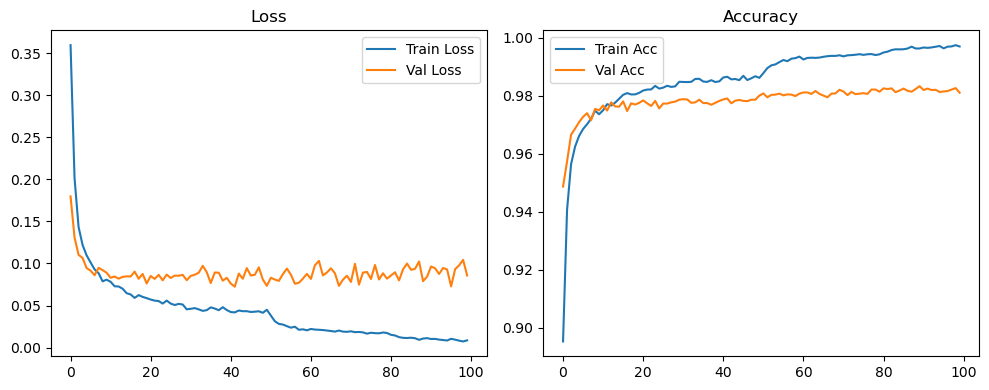

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2662, Acc: 0.9221 | Val Loss: 0.1592, Acc: 0.9555


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9638 | Val Loss: 0.1230, Acc: 0.9623


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9739 | Val Loss: 0.0999, Acc: 0.9692


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9810 | Val Loss: 0.1091, Acc: 0.9677


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9844 | Val Loss: 0.1198, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9857 | Val Loss: 0.1103, Acc: 0.9710


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9876 | Val Loss: 0.1070, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.1197, Acc: 0.9707


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.1013, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0953, Acc: 0.9738


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.1128, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1226, Acc: 0.9727


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1285, Acc: 0.9694


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.1117, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.1154, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.1116, Acc: 0.9729


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1086, Acc: 0.9752


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1168, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1123, Acc: 0.9761


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1271, Acc: 0.9706


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1191, Acc: 0.9726


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1093, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1258, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1092, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1134, Acc: 0.9747


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0973, Acc: 0.9745


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1370, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1201, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1224, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1113, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1140, Acc: 0.9787


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1301, Acc: 0.9787


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1253, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1351, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1050, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1199, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1037, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1201, Acc: 0.9760


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1123, Acc: 0.9783


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1472, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0907, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1214, Acc: 0.9752


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1467, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0949, Acc: 0.9763


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1278, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0923, Acc: 0.9798


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1730, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1288, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1351, Acc: 0.9770


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1149, Acc: 0.9797


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1432, Acc: 0.9804


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1426, Acc: 0.9798


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1819, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1494, Acc: 0.9794


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1589, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1357, Acc: 0.9801


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1336, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1576, Acc: 0.9801


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1597, Acc: 0.9802


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1474, Acc: 0.9805


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1198, Acc: 0.9794


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1409, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1512, Acc: 0.9788


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1435, Acc: 0.9805


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1671, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1311, Acc: 0.9781


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1521, Acc: 0.9798


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1182, Acc: 0.9785


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1531, Acc: 0.9784


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1216, Acc: 0.9794


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1386, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1393, Acc: 0.9785


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1187, Acc: 0.9788


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1501, Acc: 0.9782


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1831, Acc: 0.9773


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1539, Acc: 0.9795


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1604, Acc: 0.9776


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1816, Acc: 0.9773


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1642, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1592, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1584, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1689, Acc: 0.9791


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1724, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1809, Acc: 0.9800


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1906, Acc: 0.9796


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2013, Acc: 0.9803


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2039, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2004, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2126, Acc: 0.9810


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1939, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2065, Acc: 0.9795


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2075, Acc: 0.9798


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2019, Acc: 0.9797


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2057, Acc: 0.9806


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2257, Acc: 0.9803


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2358, Acc: 0.9799


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2364, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2200, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1982, Acc: 0.9802


Final Test Loss: 0.1580 Accuracy: 0.9826


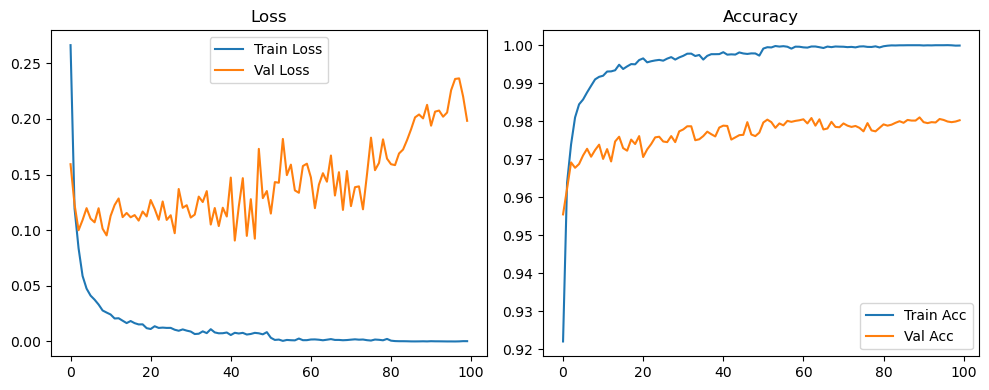

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2802, Acc: 0.9180 | Val Loss: 0.1842, Acc: 0.9464


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9582 | Val Loss: 0.1156, Acc: 0.9638


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0970, Acc: 0.9704 | Val Loss: 0.0993, Acc: 0.9701


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9753 | Val Loss: 0.1052, Acc: 0.9686


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9790 | Val Loss: 0.1004, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9816 | Val Loss: 0.0929, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9831 | Val Loss: 0.0903, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9861 | Val Loss: 0.0988, Acc: 0.9731


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9876 | Val Loss: 0.0896, Acc: 0.9767


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.1008, Acc: 0.9729


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.1128, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.0860, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9885 | Val Loss: 0.0997, Acc: 0.9757


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1030, Acc: 0.9757


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1041, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.0932, Acc: 0.9750


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.0926, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0919, Acc: 0.9766


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1121, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0896, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1167, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0938, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.1033, Acc: 0.9780


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0923, Acc: 0.9773


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1072, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0976, Acc: 0.9791


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9937 | Val Loss: 0.1065, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0959, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1127, Acc: 0.9763


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1492, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0895, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1079, Acc: 0.9766


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0990, Acc: 0.9780


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9949 | Val Loss: 0.0915, Acc: 0.9780


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0997, Acc: 0.9753


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0931, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0857, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0828, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0819, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0998, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1010, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0991, Acc: 0.9780


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0886, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1041, Acc: 0.9787


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1038, Acc: 0.9789


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.1148, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0855, Acc: 0.9790


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0989, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0774, Acc: 0.9793


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1344, Acc: 0.9798


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9972 | Val Loss: 0.0937, Acc: 0.9820


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.0969, Acc: 0.9804


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1249, Acc: 0.9801


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1058, Acc: 0.9816


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0973, Acc: 0.9806


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1346, Acc: 0.9823


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1057, Acc: 0.9807


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0963, Acc: 0.9810


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1110, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1034, Acc: 0.9803


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1242, Acc: 0.9799


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1140, Acc: 0.9799


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0991, Acc: 0.9805


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1166, Acc: 0.9804


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1091, Acc: 0.9801


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1278, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1049, Acc: 0.9813


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0936, Acc: 0.9801


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1102, Acc: 0.9792


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1213, Acc: 0.9808


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0972, Acc: 0.9803


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1231, Acc: 0.9804


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1113, Acc: 0.9812


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1347, Acc: 0.9823


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1162, Acc: 0.9817


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1440, Acc: 0.9800


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1203, Acc: 0.9800


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1104, Acc: 0.9826


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1245, Acc: 0.9803


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1236, Acc: 0.9813


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1111, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1135, Acc: 0.9818


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1248, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1181, Acc: 0.9825


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1111, Acc: 0.9822


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.1186, Acc: 0.9820


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1213, Acc: 0.9826


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1265, Acc: 0.9826


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1373, Acc: 0.9822


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1387, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1233, Acc: 0.9821


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1314, Acc: 0.9817


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1269, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1154, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9995 | Val Loss: 0.1209, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1192, Acc: 0.9823


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1262, Acc: 0.9815


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1280, Acc: 0.9817


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1410, Acc: 0.9819


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1396, Acc: 0.9816


Final Test Loss: 0.1281 Accuracy: 0.9835


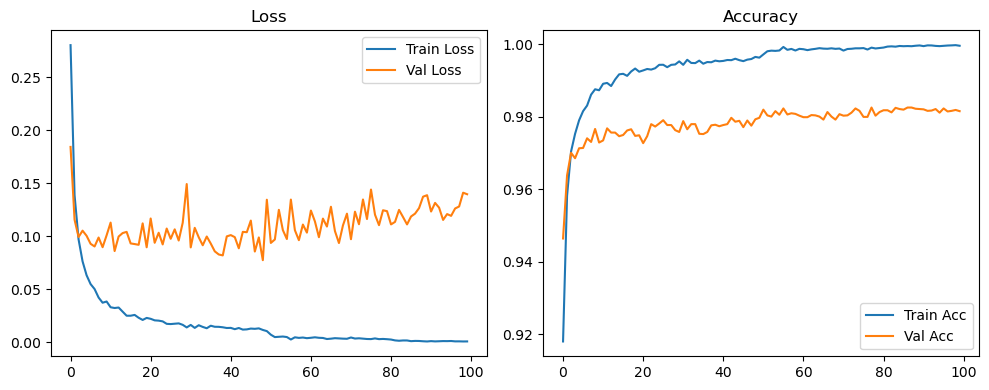

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3593, Acc: 0.8952 | Val Loss: 0.1797, Acc: 0.9487


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9406 | Val Loss: 0.1308, Acc: 0.9573


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9564 | Val Loss: 0.1103, Acc: 0.9666


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1220, Acc: 0.9625 | Val Loss: 0.1066, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1098, Acc: 0.9661 | Val Loss: 0.0946, Acc: 0.9709


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1013, Acc: 0.9685 | Val Loss: 0.0915, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9702 | Val Loss: 0.0861, Acc: 0.9740


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9721 | Val Loss: 0.0949, Acc: 0.9716


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9755


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9736 | Val Loss: 0.0890, Acc: 0.9750


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9750 | Val Loss: 0.0830, Acc: 0.9767


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9771 | Val Loss: 0.0846, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9766 | Val Loss: 0.0820, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9776 | Val Loss: 0.0841, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9790 | Val Loss: 0.0847, Acc: 0.9762


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9804 | Val Loss: 0.0846, Acc: 0.9781


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.0903, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9805 | Val Loss: 0.0819, Acc: 0.9774


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9805 | Val Loss: 0.0876, Acc: 0.9770


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9810 | Val Loss: 0.0763, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9818 | Val Loss: 0.0852, Acc: 0.9784


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9822 | Val Loss: 0.0817, Acc: 0.9774


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9822 | Val Loss: 0.0865, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.0800, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9825 | Val Loss: 0.0868, Acc: 0.9757


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9828 | Val Loss: 0.0828, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9835 | Val Loss: 0.0856, Acc: 0.9773


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9831 | Val Loss: 0.0855, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9833 | Val Loss: 0.0865, Acc: 0.9780


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0802, Acc: 0.9787


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9848 | Val Loss: 0.0853, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 0.0867, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9848 | Val Loss: 0.0891, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9858 | Val Loss: 0.0972, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0897, Acc: 0.9787


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0768, Acc: 0.9775


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9848 | Val Loss: 0.0893, Acc: 0.9775


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9854 | Val Loss: 0.0891, Acc: 0.9769


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 0.0796, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9850 | Val Loss: 0.0830, Acc: 0.9782


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.0762, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9866 | Val Loss: 0.0725, Acc: 0.9791


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 0.0881, Acc: 0.9774


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9858 | Val Loss: 0.0819, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9854 | Val Loss: 0.0945, Acc: 0.9786


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0857, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9855 | Val Loss: 0.0866, Acc: 0.9782


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.0954, Acc: 0.9787


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0809, Acc: 0.9787


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9862 | Val Loss: 0.0735, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0382, Acc: 0.9878 | Val Loss: 0.0831, Acc: 0.9808


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0809, Acc: 0.9795


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9905 | Val Loss: 0.0793, Acc: 0.9803


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.0873, Acc: 0.9804


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0939, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9924 | Val Loss: 0.0868, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0760, Acc: 0.9805


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.0771, Acc: 0.9804


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0820, Acc: 0.9799


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0877, Acc: 0.9808


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0817, Acc: 0.9812


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.0978, Acc: 0.9812


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.1031, Acc: 0.9807


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0859, Acc: 0.9817


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9932 | Val Loss: 0.0893, Acc: 0.9807


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0943, Acc: 0.9801


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0883, Acc: 0.9795


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9938 | Val Loss: 0.0734, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0808, Acc: 0.9808


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0855, Acc: 0.9821


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.0781, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9940 | Val Loss: 0.0997, Acc: 0.9802


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.0748, Acc: 0.9813


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0892, Acc: 0.9806


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0900, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.0816, Acc: 0.9809


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0982, Acc: 0.9807


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0810, Acc: 0.9822


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0884, Acc: 0.9822


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0820, Acc: 0.9814


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0852, Acc: 0.9820


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0898, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0862, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0891, Acc: 0.9814


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0904, Acc: 0.9805


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0954, Acc: 0.9818


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.0879, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0864, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0855, Acc: 0.9825


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0874, Acc: 0.9825


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0843, Acc: 0.9820


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0878, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0940, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0918, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0842, Acc: 0.9820


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0748, Acc: 0.9825


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0879, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0887, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0888, Acc: 0.9827


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0849, Acc: 0.9825


Final Test Loss: 0.0791 Accuracy: 0.9840


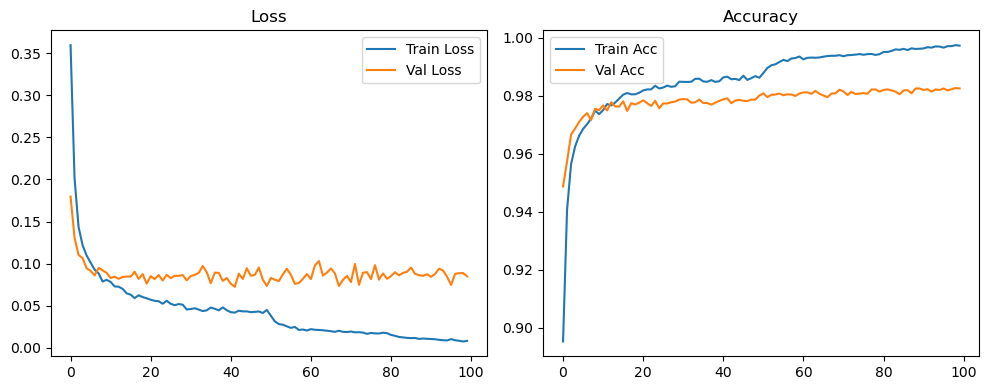

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2662, Acc: 0.9221 | Val Loss: 0.1592, Acc: 0.9555


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1194, Acc: 0.9638 | Val Loss: 0.1230, Acc: 0.9623


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0838, Acc: 0.9739 | Val Loss: 0.0999, Acc: 0.9692


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9810 | Val Loss: 0.1091, Acc: 0.9677


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0475, Acc: 0.9844 | Val Loss: 0.1198, Acc: 0.9688


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9857 | Val Loss: 0.1103, Acc: 0.9710


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9876 | Val Loss: 0.1070, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9893 | Val Loss: 0.1197, Acc: 0.9707


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9910 | Val Loss: 0.1013, Acc: 0.9724


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9917 | Val Loss: 0.0953, Acc: 0.9738


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.1128, Acc: 0.9701


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9931 | Val Loss: 0.1226, Acc: 0.9727


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1285, Acc: 0.9694


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.1117, Acc: 0.9747


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.1154, Acc: 0.9759


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.1116, Acc: 0.9729


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9722


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1086, Acc: 0.9752


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1168, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1123, Acc: 0.9761


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.1271, Acc: 0.9706


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1191, Acc: 0.9726


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1093, Acc: 0.9740


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1258, Acc: 0.9758


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1092, Acc: 0.9759


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1134, Acc: 0.9747


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0973, Acc: 0.9745


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1370, Acc: 0.9761


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.1201, Acc: 0.9745


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1224, Acc: 0.9773


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1113, Acc: 0.9778


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1140, Acc: 0.9787


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1301, Acc: 0.9787


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1253, Acc: 0.9750


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1351, Acc: 0.9752


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1050, Acc: 0.9761


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1199, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1037, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1201, Acc: 0.9760


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1123, Acc: 0.9783


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1472, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.0907, Acc: 0.9788


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1214, Acc: 0.9752


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1467, Acc: 0.9758


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0949, Acc: 0.9763


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1278, Acc: 0.9764


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.0923, Acc: 0.9798


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1730, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1288, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1351, Acc: 0.9770


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1217, Acc: 0.9797


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1393, Acc: 0.9803


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1570, Acc: 0.9802


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1653, Acc: 0.9801


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1568, Acc: 0.9801


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1569, Acc: 0.9809


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1543, Acc: 0.9804


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1562, Acc: 0.9812


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1634, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1724, Acc: 0.9804


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1635, Acc: 0.9800


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1781, Acc: 0.9804


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1807, Acc: 0.9802


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1752, Acc: 0.9799


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1772, Acc: 0.9806


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1849, Acc: 0.9807


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1986, Acc: 0.9810


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1668, Acc: 0.9804


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1984, Acc: 0.9801


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2189, Acc: 0.9803


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1848, Acc: 0.9807


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2012, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1701, Acc: 0.9819


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1812, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1676, Acc: 0.9816


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1598, Acc: 0.9818


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1640, Acc: 0.9807


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1772, Acc: 0.9816


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1596, Acc: 0.9817


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1791, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1874, Acc: 0.9824


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1721, Acc: 0.9811


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1822, Acc: 0.9813


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1917, Acc: 0.9807


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1974, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1814, Acc: 0.9804


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1846, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1815, Acc: 0.9798


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1849, Acc: 0.9807


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1950, Acc: 0.9809


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1690, Acc: 0.9814


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1860, Acc: 0.9810


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1971, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2022, Acc: 0.9811


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2185, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2284, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2304, Acc: 0.9804


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2203, Acc: 0.9807


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2522, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.2189, Acc: 0.9810


Final Test Loss: 0.1905 Accuracy: 0.9815


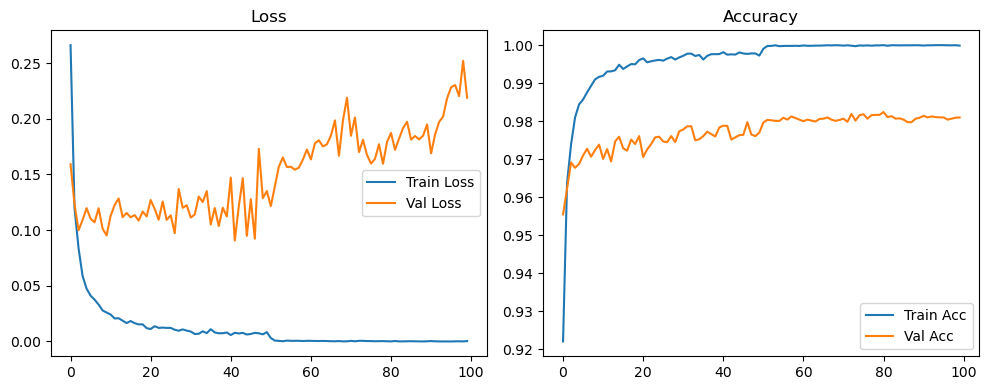

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2802, Acc: 0.9180 | Val Loss: 0.1842, Acc: 0.9464


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1388, Acc: 0.9582 | Val Loss: 0.1156, Acc: 0.9638


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0970, Acc: 0.9704 | Val Loss: 0.0993, Acc: 0.9701


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9753 | Val Loss: 0.1052, Acc: 0.9686


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9790 | Val Loss: 0.1004, Acc: 0.9713


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0549, Acc: 0.9816 | Val Loss: 0.0929, Acc: 0.9714


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9831 | Val Loss: 0.0903, Acc: 0.9741


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9861 | Val Loss: 0.0988, Acc: 0.9731


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9876 | Val Loss: 0.0896, Acc: 0.9767


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.1008, Acc: 0.9729


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9891 | Val Loss: 0.1128, Acc: 0.9735


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9894 | Val Loss: 0.0860, Acc: 0.9768


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9885 | Val Loss: 0.0997, Acc: 0.9757


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1030, Acc: 0.9757


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9918 | Val Loss: 0.1041, Acc: 0.9747


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.0932, Acc: 0.9750


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.0926, Acc: 0.9762


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.0919, Acc: 0.9766


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0210, Acc: 0.9934 | Val Loss: 0.1121, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9925 | Val Loss: 0.0896, Acc: 0.9749


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1167, Acc: 0.9728


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0938, Acc: 0.9747


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9931 | Val Loss: 0.1033, Acc: 0.9780


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0923, Acc: 0.9773


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1072, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0976, Acc: 0.9791


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9937 | Val Loss: 0.1065, Acc: 0.9778


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0959, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1127, Acc: 0.9763


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1492, Acc: 0.9758


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0895, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.1079, Acc: 0.9766


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0990, Acc: 0.9780


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9949 | Val Loss: 0.0915, Acc: 0.9780


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0997, Acc: 0.9753


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9947 | Val Loss: 0.0931, Acc: 0.9752


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0857, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0828, Acc: 0.9777


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.0819, Acc: 0.9778


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0998, Acc: 0.9774


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.1010, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0991, Acc: 0.9780


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.0886, Acc: 0.9798


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1041, Acc: 0.9787


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9957 | Val Loss: 0.1038, Acc: 0.9789


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.1148, Acc: 0.9772


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0855, Acc: 0.9790


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0989, Acc: 0.9776


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0774, Acc: 0.9793


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1344, Acc: 0.9798


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0949, Acc: 0.9810


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.1017, Acc: 0.9803


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1057, Acc: 0.9817


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1020, Acc: 0.9824


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0913, Acc: 0.9810


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1138, Acc: 0.9819


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0884, Acc: 0.9831


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0939, Acc: 0.9822


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1100, Acc: 0.9819


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1112, Acc: 0.9819


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1245, Acc: 0.9814


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1313, Acc: 0.9818


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0863, Acc: 0.9822


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1015, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0954, Acc: 0.9819


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0998, Acc: 0.9819


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1162, Acc: 0.9827


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1124, Acc: 0.9817


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1253, Acc: 0.9825


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1018, Acc: 0.9825


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0985, Acc: 0.9818


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1289, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1210, Acc: 0.9817


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1202, Acc: 0.9825


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1109, Acc: 0.9817


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1060, Acc: 0.9819


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1158, Acc: 0.9828


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1036, Acc: 0.9833


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1068, Acc: 0.9834


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1134, Acc: 0.9819


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1177, Acc: 0.9823


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1085, Acc: 0.9828


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1216, Acc: 0.9827


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1051, Acc: 0.9827


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1260, Acc: 0.9825


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1051, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1162, Acc: 0.9823


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1366, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1526, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1280, Acc: 0.9828


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1262, Acc: 0.9828


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1393, Acc: 0.9826


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1094, Acc: 0.9833


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1302, Acc: 0.9828


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1180, Acc: 0.9827


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1233, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1294, Acc: 0.9825


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1157, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1368, Acc: 0.9828


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1183, Acc: 0.9822


Final Test Loss: 0.1078 Accuracy: 0.9846


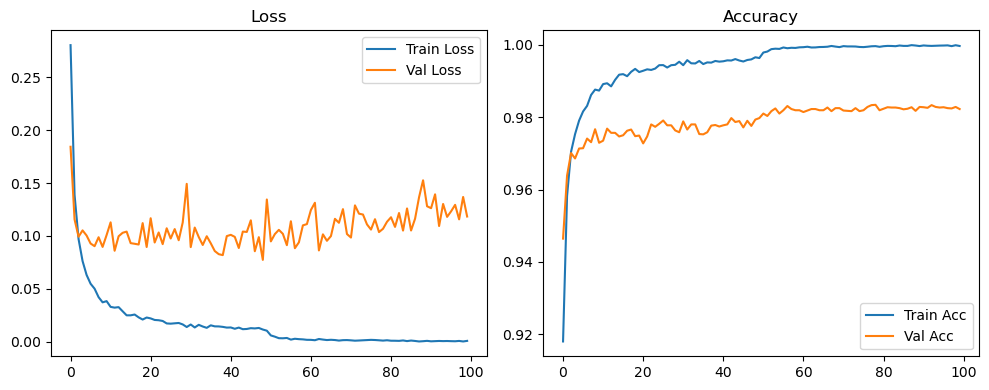

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3593, Acc: 0.8952 | Val Loss: 0.1797, Acc: 0.9487


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9406 | Val Loss: 0.1308, Acc: 0.9573


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1435, Acc: 0.9564 | Val Loss: 0.1103, Acc: 0.9666


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1220, Acc: 0.9625 | Val Loss: 0.1066, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1098, Acc: 0.9661 | Val Loss: 0.0946, Acc: 0.9709


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1013, Acc: 0.9685 | Val Loss: 0.0915, Acc: 0.9728


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0930, Acc: 0.9702 | Val Loss: 0.0861, Acc: 0.9740


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9721 | Val Loss: 0.0949, Acc: 0.9716


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0788, Acc: 0.9749 | Val Loss: 0.0921, Acc: 0.9755


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0808, Acc: 0.9736 | Val Loss: 0.0890, Acc: 0.9750


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0783, Acc: 0.9750 | Val Loss: 0.0830, Acc: 0.9767


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0730, Acc: 0.9771 | Val Loss: 0.0846, Acc: 0.9749


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0727, Acc: 0.9766 | Val Loss: 0.0820, Acc: 0.9778


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0700, Acc: 0.9776 | Val Loss: 0.0841, Acc: 0.9763


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9790 | Val Loss: 0.0847, Acc: 0.9762


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0632, Acc: 0.9804 | Val Loss: 0.0846, Acc: 0.9781


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.0903, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9805 | Val Loss: 0.0819, Acc: 0.9774


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0603, Acc: 0.9805 | Val Loss: 0.0876, Acc: 0.9770


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0589, Acc: 0.9810 | Val Loss: 0.0763, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9818 | Val Loss: 0.0852, Acc: 0.9784


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9822 | Val Loss: 0.0817, Acc: 0.9774


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9822 | Val Loss: 0.0865, Acc: 0.9765


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.0800, Acc: 0.9782


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0559, Acc: 0.9825 | Val Loss: 0.0868, Acc: 0.9757


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9828 | Val Loss: 0.0828, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9835 | Val Loss: 0.0856, Acc: 0.9773


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9831 | Val Loss: 0.0855, Acc: 0.9778


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0513, Acc: 0.9833 | Val Loss: 0.0865, Acc: 0.9780


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0802, Acc: 0.9787


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0462, Acc: 0.9848 | Val Loss: 0.0853, Acc: 0.9788


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9848 | Val Loss: 0.0867, Acc: 0.9788


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9848 | Val Loss: 0.0891, Acc: 0.9776


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9858 | Val Loss: 0.0972, Acc: 0.9778


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0897, Acc: 0.9787


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0479, Acc: 0.9849 | Val Loss: 0.0768, Acc: 0.9775


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9848 | Val Loss: 0.0893, Acc: 0.9775


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9854 | Val Loss: 0.0891, Acc: 0.9769


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9848 | Val Loss: 0.0796, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9850 | Val Loss: 0.0830, Acc: 0.9782


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9863 | Val Loss: 0.0762, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9866 | Val Loss: 0.0725, Acc: 0.9791


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 0.0881, Acc: 0.9774


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9858 | Val Loss: 0.0819, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9854 | Val Loss: 0.0945, Acc: 0.9786


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9869 | Val Loss: 0.0857, Acc: 0.9782


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9855 | Val Loss: 0.0866, Acc: 0.9782


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9861 | Val Loss: 0.0954, Acc: 0.9787


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9868 | Val Loss: 0.0809, Acc: 0.9787


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9862 | Val Loss: 0.0735, Acc: 0.9801


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9882 | Val Loss: 0.0713, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9894 | Val Loss: 0.0762, Acc: 0.9802


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9911 | Val Loss: 0.0784, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9913 | Val Loss: 0.0787, Acc: 0.9803


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0248, Acc: 0.9919 | Val Loss: 0.0860, Acc: 0.9809


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.0778, Acc: 0.9818


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9927 | Val Loss: 0.0771, Acc: 0.9814


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0819, Acc: 0.9818


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.0770, Acc: 0.9822


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0837, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0864, Acc: 0.9819


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0772, Acc: 0.9823


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9945 | Val Loss: 0.0805, Acc: 0.9819


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0806, Acc: 0.9828


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0787, Acc: 0.9820


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9944 | Val Loss: 0.0877, Acc: 0.9818


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0860, Acc: 0.9813


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9953 | Val Loss: 0.0791, Acc: 0.9823


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.0809, Acc: 0.9824


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.0862, Acc: 0.9824


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.0817, Acc: 0.9830


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.0816, Acc: 0.9823


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0841, Acc: 0.9824


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0825, Acc: 0.9828


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0797, Acc: 0.9821


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0847, Acc: 0.9822


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0876, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0777, Acc: 0.9826


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9957 | Val Loss: 0.0971, Acc: 0.9828


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9962 | Val Loss: 0.0920, Acc: 0.9821


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0912, Acc: 0.9820


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0874, Acc: 0.9821


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0858, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0869, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9964 | Val Loss: 0.0812, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.0924, Acc: 0.9819


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0813, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0950, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0846, Acc: 0.9827


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0944, Acc: 0.9828


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0819, Acc: 0.9822


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.0846, Acc: 0.9832


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9968 | Val Loss: 0.0819, Acc: 0.9821


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.0967, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0860, Acc: 0.9819


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0857, Acc: 0.9824


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0890, Acc: 0.9823


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0865, Acc: 0.9825


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0875, Acc: 0.9825


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0826, Acc: 0.9825


Final Test Loss: 0.0750 Accuracy: 0.9844


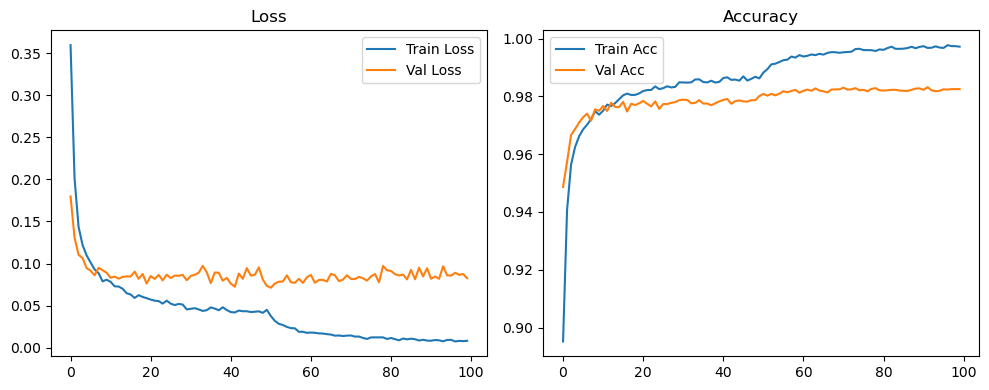

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2431, Acc: 0.9261 | Val Loss: 0.1577, Acc: 0.9568


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1143, Acc: 0.9656 | Val Loss: 0.1230, Acc: 0.9630


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0827, Acc: 0.9747 | Val Loss: 0.1049, Acc: 0.9701


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9821 | Val Loss: 0.1031, Acc: 0.9712


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9838 | Val Loss: 0.1151, Acc: 0.9683


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9869 | Val Loss: 0.1097, Acc: 0.9718


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9885 | Val Loss: 0.1025, Acc: 0.9761


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.1037, Acc: 0.9737


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.1088, Acc: 0.9743


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.1147, Acc: 0.9747


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9938 | Val Loss: 0.1094, Acc: 0.9737


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1111, Acc: 0.9738


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9943 | Val Loss: 0.1078, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0994, Acc: 0.9753


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0941, Acc: 0.9777


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1084, Acc: 0.9768


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1162, Acc: 0.9736


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1159, Acc: 0.9762


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1129, Acc: 0.9756


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0978, Acc: 0.9766


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0995, Acc: 0.9766


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1005, Acc: 0.9768


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1296, Acc: 0.9745


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1149, Acc: 0.9762


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0976, Acc: 0.9788


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0941, Acc: 0.9778


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1159, Acc: 0.9752


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1046, Acc: 0.9784


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1011, Acc: 0.9775


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1209, Acc: 0.9768


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1063, Acc: 0.9775


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1156, Acc: 0.9750


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1206, Acc: 0.9780


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0911, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1058, Acc: 0.9774


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1038, Acc: 0.9797


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1091, Acc: 0.9797


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0991, Acc: 0.9785


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1073, Acc: 0.9788


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1245, Acc: 0.9750


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1418, Acc: 0.9764


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1116, Acc: 0.9777


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1089, Acc: 0.9766


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1080, Acc: 0.9761


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1217, Acc: 0.9775


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1064, Acc: 0.9790


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1097, Acc: 0.9768


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1017, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0989, Acc: 0.9765


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1158, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1191, Acc: 0.9782


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0967, Acc: 0.9768


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0984, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1238, Acc: 0.9778


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1187, Acc: 0.9799


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1193, Acc: 0.9781


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9984 | Val Loss: 0.1190, Acc: 0.9783


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1032, Acc: 0.9765


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1127, Acc: 0.9787


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1161, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1126, Acc: 0.9786


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1128, Acc: 0.9779


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1325, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1278, Acc: 0.9788


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1256, Acc: 0.9777


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1269, Acc: 0.9792


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1269, Acc: 0.9789


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1127, Acc: 0.9798


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1296, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1233, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1192, Acc: 0.9786


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1072, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1403, Acc: 0.9751


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1163, Acc: 0.9798


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1263, Acc: 0.9797


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1253, Acc: 0.9783


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1064, Acc: 0.9775


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1449, Acc: 0.9794


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1188, Acc: 0.9799


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1119, Acc: 0.9783


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1202, Acc: 0.9798


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1170, Acc: 0.9784


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1249, Acc: 0.9789


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1234, Acc: 0.9808


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1247, Acc: 0.9791


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1362, Acc: 0.9788


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1182, Acc: 0.9784


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1404, Acc: 0.9798


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1681, Acc: 0.9798


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1446, Acc: 0.9775


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1525, Acc: 0.9793


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1608, Acc: 0.9788


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1372, Acc: 0.9795


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1154, Acc: 0.9793


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1341, Acc: 0.9792


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1264, Acc: 0.9790


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1029, Acc: 0.9769


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1410, Acc: 0.9778


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1258, Acc: 0.9782


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1399, Acc: 0.9768


Final Test Loss: 0.1230 Accuracy: 0.9786


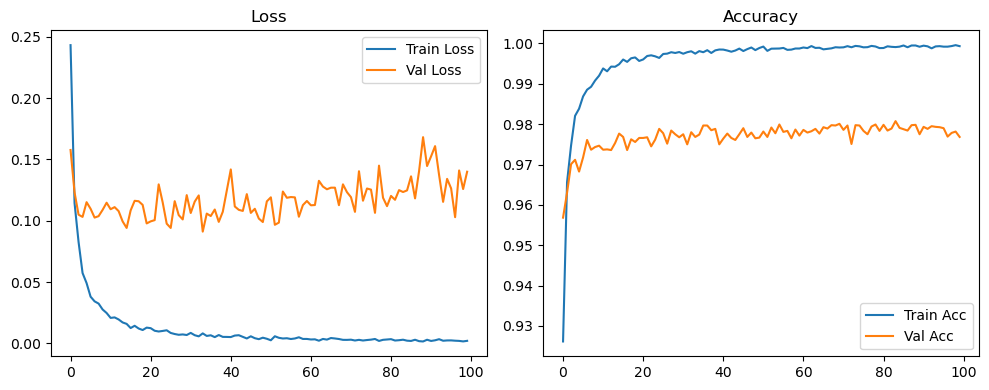

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2567, Acc: 0.9215 | Val Loss: 0.1520, Acc: 0.9550


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1346, Acc: 0.9598 | Val Loss: 0.1159, Acc: 0.9633


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0989, Acc: 0.9701 | Val Loss: 0.1087, Acc: 0.9677


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0758, Acc: 0.9758 | Val Loss: 0.1183, Acc: 0.9668


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9801 | Val Loss: 0.1050, Acc: 0.9683


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9833 | Val Loss: 0.1044, Acc: 0.9742


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9836 | Val Loss: 0.0986, Acc: 0.9728


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9863 | Val Loss: 0.1057, Acc: 0.9723


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.0993, Acc: 0.9738


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.1015, Acc: 0.9743


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0920, Acc: 0.9772


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.0933, Acc: 0.9749


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.1005, Acc: 0.9750


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.0987, Acc: 0.9753


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.0961, Acc: 0.9771


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0885, Acc: 0.9776


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.1003, Acc: 0.9758


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1004, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.1111, Acc: 0.9751


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0956, Acc: 0.9767


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0836, Acc: 0.9784


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0977, Acc: 0.9774


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.1033, Acc: 0.9782


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0893, Acc: 0.9774


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0980, Acc: 0.9791


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0967, Acc: 0.9795


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0922, Acc: 0.9769


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0833, Acc: 0.9787


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0979, Acc: 0.9779


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1005, Acc: 0.9784


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0924, Acc: 0.9790


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0984, Acc: 0.9781


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1039, Acc: 0.9792


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0940, Acc: 0.9778


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0934, Acc: 0.9792


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1036, Acc: 0.9780


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1141, Acc: 0.9766


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1147, Acc: 0.9796


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0931, Acc: 0.9803


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0955, Acc: 0.9797


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0862, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0905, Acc: 0.9812


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1043, Acc: 0.9799


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0868, Acc: 0.9787


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1030, Acc: 0.9808


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0862, Acc: 0.9799


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0901, Acc: 0.9807


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0856, Acc: 0.9793


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0997, Acc: 0.9785


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1030, Acc: 0.9787


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0950, Acc: 0.9806


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0977, Acc: 0.9807


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.0904, Acc: 0.9793


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1139, Acc: 0.9809


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1064, Acc: 0.9780


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1198, Acc: 0.9794


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0957, Acc: 0.9774


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1004, Acc: 0.9797


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1141, Acc: 0.9791


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.1216, Acc: 0.9774


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1117, Acc: 0.9779


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0888, Acc: 0.9818


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1116, Acc: 0.9801


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1041, Acc: 0.9814


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1233, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1073, Acc: 0.9806


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1046, Acc: 0.9806


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1071, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1198, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1094, Acc: 0.9810


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1062, Acc: 0.9813


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1167, Acc: 0.9795


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0911, Acc: 0.9816


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1003, Acc: 0.9808


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0875, Acc: 0.9808


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0972, Acc: 0.9790


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.1108, Acc: 0.9811


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1187, Acc: 0.9808


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1225, Acc: 0.9803


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1307, Acc: 0.9804


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1066, Acc: 0.9800


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1059, Acc: 0.9794


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0983, Acc: 0.9803


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0868, Acc: 0.9813


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1211, Acc: 0.9785


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1127, Acc: 0.9797


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1036, Acc: 0.9792


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1394, Acc: 0.9798


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1080, Acc: 0.9802


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1273, Acc: 0.9801


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1076, Acc: 0.9782


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1030, Acc: 0.9800


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1196, Acc: 0.9790


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1192, Acc: 0.9807


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1089, Acc: 0.9802


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1281, Acc: 0.9805


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1018, Acc: 0.9801


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1064, Acc: 0.9797


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1229, Acc: 0.9798


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1096, Acc: 0.9797


Final Test Loss: 0.0991 Accuracy: 0.9817


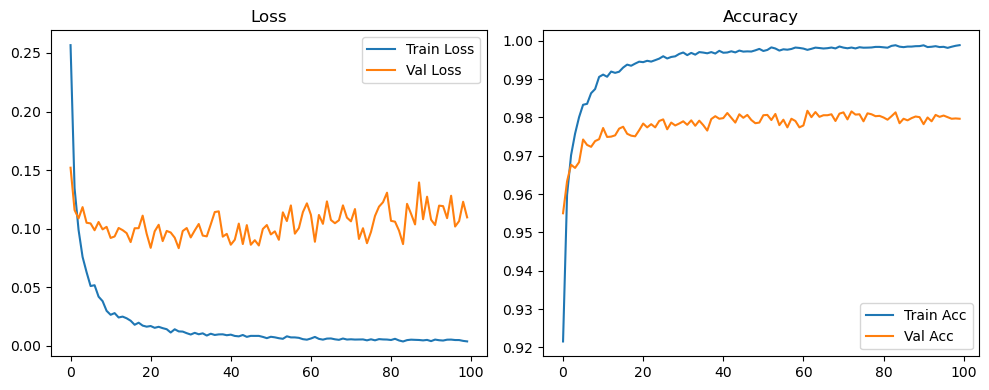

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3291, Acc: 0.9023 | Val Loss: 0.1657, Acc: 0.9514


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1924, Acc: 0.9429 | Val Loss: 0.1278, Acc: 0.9617


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1551, Acc: 0.9529 | Val Loss: 0.1169, Acc: 0.9649


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1288, Acc: 0.9616 | Val Loss: 0.1063, Acc: 0.9689


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1101, Acc: 0.9659 | Val Loss: 0.0912, Acc: 0.9728


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0967, Acc: 0.9696 | Val Loss: 0.0850, Acc: 0.9741


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0833, Acc: 0.9732 | Val Loss: 0.0859, Acc: 0.9751


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9757 | Val Loss: 0.0901, Acc: 0.9736


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9767 | Val Loss: 0.0839, Acc: 0.9762


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9778 | Val Loss: 0.0815, Acc: 0.9772


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9795 | Val Loss: 0.0873, Acc: 0.9748


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9815 | Val Loss: 0.0819, Acc: 0.9772


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9815 | Val Loss: 0.0824, Acc: 0.9762


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9831 | Val Loss: 0.0734, Acc: 0.9799


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9820 | Val Loss: 0.0787, Acc: 0.9777


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9837 | Val Loss: 0.0772, Acc: 0.9780


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.0753, Acc: 0.9781


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.0770, Acc: 0.9796


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9858 | Val Loss: 0.0778, Acc: 0.9791


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0809, Acc: 0.9768


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.0794, Acc: 0.9791


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9873 | Val Loss: 0.0740, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9880 | Val Loss: 0.0807, Acc: 0.9802


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.0745, Acc: 0.9805


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9883 | Val Loss: 0.0776, Acc: 0.9788


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9889 | Val Loss: 0.0762, Acc: 0.9798


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9882 | Val Loss: 0.0768, Acc: 0.9790


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0734, Acc: 0.9796


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9898 | Val Loss: 0.0791, Acc: 0.9798


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.0815, Acc: 0.9798


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9886 | Val Loss: 0.0785, Acc: 0.9793


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9901 | Val Loss: 0.0782, Acc: 0.9803


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0771, Acc: 0.9808


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.0816, Acc: 0.9791


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0839, Acc: 0.9803


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.0791, Acc: 0.9797


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.0820, Acc: 0.9811


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0794, Acc: 0.9807


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0828, Acc: 0.9798


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.0742, Acc: 0.9806


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0785, Acc: 0.9795


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0909, Acc: 0.9806


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.0825, Acc: 0.9798


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.0960, Acc: 0.9795


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0783, Acc: 0.9815


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0765, Acc: 0.9803


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0691, Acc: 0.9810


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0822, Acc: 0.9813


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0680, Acc: 0.9818


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.0743, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9925 | Val Loss: 0.0759, Acc: 0.9812


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9929 | Val Loss: 0.0821, Acc: 0.9808


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.0820, Acc: 0.9812


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0691, Acc: 0.9818


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0873, Acc: 0.9814


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.0745, Acc: 0.9818


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9929 | Val Loss: 0.0798, Acc: 0.9810


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.0761, Acc: 0.9811


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9936 | Val Loss: 0.0731, Acc: 0.9806


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9935 | Val Loss: 0.0826, Acc: 0.9807


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0737, Acc: 0.9804


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0835, Acc: 0.9811


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0819, Acc: 0.9817


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.0831, Acc: 0.9799


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0852, Acc: 0.9812


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1019, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0969, Acc: 0.9796


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.0816, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9937 | Val Loss: 0.0687, Acc: 0.9811


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9937 | Val Loss: 0.0776, Acc: 0.9822


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0890, Acc: 0.9808


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0975, Acc: 0.9819


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0888, Acc: 0.9806


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0764, Acc: 0.9809


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.0799, Acc: 0.9818


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0802, Acc: 0.9809


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0815, Acc: 0.9806


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0710, Acc: 0.9806


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9952 | Val Loss: 0.0865, Acc: 0.9809


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9941 | Val Loss: 0.0965, Acc: 0.9807


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0712, Acc: 0.9808


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0769, Acc: 0.9825


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.1011, Acc: 0.9815


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9937 | Val Loss: 0.0675, Acc: 0.9818


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0727, Acc: 0.9818


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0866, Acc: 0.9819


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.0833, Acc: 0.9813


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0807, Acc: 0.9811


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.0871, Acc: 0.9812


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0866, Acc: 0.9809


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0984, Acc: 0.9800


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0843, Acc: 0.9812


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0865, Acc: 0.9810


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9949 | Val Loss: 0.0849, Acc: 0.9803


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.0833, Acc: 0.9816


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0906, Acc: 0.9795


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.0940, Acc: 0.9798


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0741, Acc: 0.9802


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1080, Acc: 0.9803


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9956 | Val Loss: 0.1054, Acc: 0.9816


Final Test Loss: 0.0896 Accuracy: 0.9828


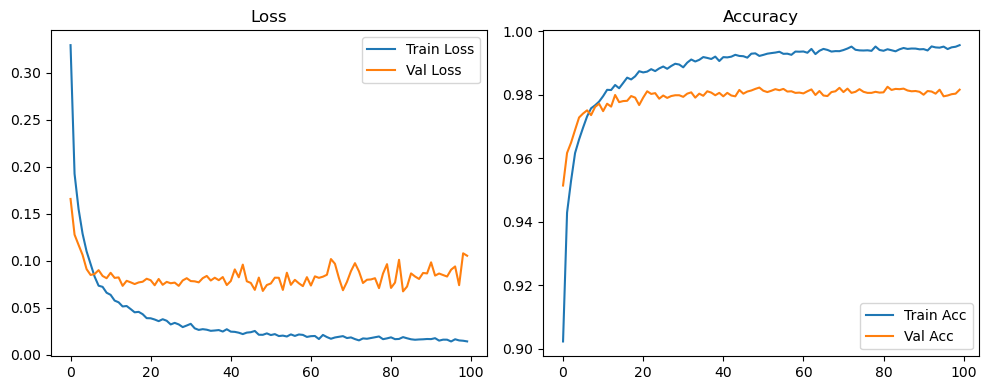

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2431, Acc: 0.9261 | Val Loss: 0.1577, Acc: 0.9568


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1143, Acc: 0.9656 | Val Loss: 0.1230, Acc: 0.9630


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0827, Acc: 0.9747 | Val Loss: 0.1049, Acc: 0.9701


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0573, Acc: 0.9821 | Val Loss: 0.1031, Acc: 0.9712


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9838 | Val Loss: 0.1151, Acc: 0.9683


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0381, Acc: 0.9869 | Val Loss: 0.1097, Acc: 0.9718


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0343, Acc: 0.9885 | Val Loss: 0.1025, Acc: 0.9761


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9893 | Val Loss: 0.1037, Acc: 0.9737


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.1088, Acc: 0.9743


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.1147, Acc: 0.9747


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9938 | Val Loss: 0.1094, Acc: 0.9737


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9931 | Val Loss: 0.1111, Acc: 0.9738


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0195, Acc: 0.9943 | Val Loss: 0.1078, Acc: 0.9736


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0994, Acc: 0.9753


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0941, Acc: 0.9777


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1084, Acc: 0.9768


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1162, Acc: 0.9736


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1159, Acc: 0.9762


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1129, Acc: 0.9756


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0978, Acc: 0.9766


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0995, Acc: 0.9766


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1005, Acc: 0.9768


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1296, Acc: 0.9745


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1149, Acc: 0.9762


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0976, Acc: 0.9788


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0941, Acc: 0.9778


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1159, Acc: 0.9752


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1046, Acc: 0.9784


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1011, Acc: 0.9775


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1209, Acc: 0.9768


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1063, Acc: 0.9775


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1156, Acc: 0.9750


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1206, Acc: 0.9780


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0911, Acc: 0.9768


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1058, Acc: 0.9774


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1038, Acc: 0.9797


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1091, Acc: 0.9797


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0991, Acc: 0.9785


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1073, Acc: 0.9788


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1245, Acc: 0.9750


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1418, Acc: 0.9764


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1116, Acc: 0.9777


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1089, Acc: 0.9766


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1080, Acc: 0.9761


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1217, Acc: 0.9775


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1064, Acc: 0.9790


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1097, Acc: 0.9768


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1017, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0989, Acc: 0.9765


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1158, Acc: 0.9767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1206, Acc: 0.9798


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1312, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1291, Acc: 0.9818


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1305, Acc: 0.9807


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1290, Acc: 0.9804


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1183, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1240, Acc: 0.9803


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1232, Acc: 0.9809


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1158, Acc: 0.9818


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1276, Acc: 0.9810


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1129, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1254, Acc: 0.9800


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1225, Acc: 0.9807


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1246, Acc: 0.9819


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1311, Acc: 0.9812


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1447, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1296, Acc: 0.9816


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1090, Acc: 0.9815


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1139, Acc: 0.9813


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1275, Acc: 0.9821


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1306, Acc: 0.9809


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1257, Acc: 0.9820


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1296, Acc: 0.9818


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1346, Acc: 0.9823


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1404, Acc: 0.9817


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1297, Acc: 0.9809


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1365, Acc: 0.9809


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1353, Acc: 0.9810


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1179, Acc: 0.9812


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1231, Acc: 0.9818


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1303, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1335, Acc: 0.9818


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1343, Acc: 0.9816


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1283, Acc: 0.9827


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1284, Acc: 0.9828


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1360, Acc: 0.9821


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1407, Acc: 0.9827


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1441, Acc: 0.9822


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1487, Acc: 0.9820


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1554, Acc: 0.9818


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1654, Acc: 0.9813


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1700, Acc: 0.9816


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1574, Acc: 0.9821


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1615, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1614, Acc: 0.9817


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1558, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1614, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1643, Acc: 0.9821


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1787, Acc: 0.9813


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1622, Acc: 0.9812


Final Test Loss: 0.1445 Accuracy: 0.9834


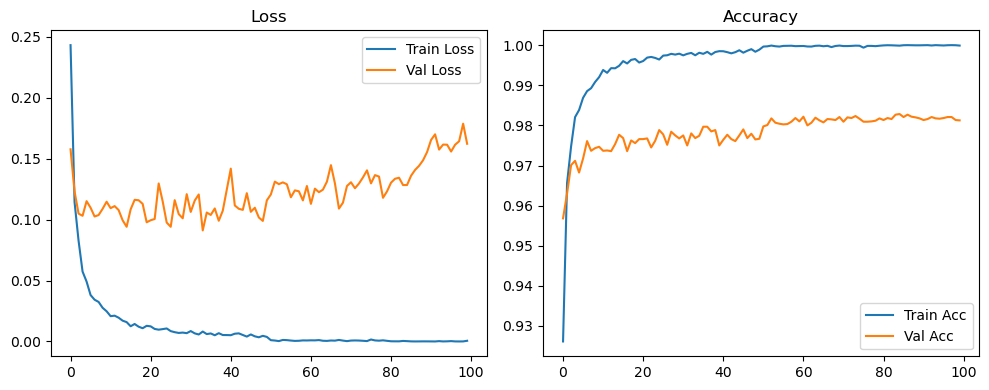

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2567, Acc: 0.9215 | Val Loss: 0.1520, Acc: 0.9550


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1346, Acc: 0.9598 | Val Loss: 0.1159, Acc: 0.9633


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0989, Acc: 0.9701 | Val Loss: 0.1087, Acc: 0.9677


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0758, Acc: 0.9758 | Val Loss: 0.1183, Acc: 0.9668


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0628, Acc: 0.9801 | Val Loss: 0.1050, Acc: 0.9683


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0509, Acc: 0.9833 | Val Loss: 0.1044, Acc: 0.9742


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0516, Acc: 0.9836 | Val Loss: 0.0986, Acc: 0.9728


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0419, Acc: 0.9863 | Val Loss: 0.1057, Acc: 0.9723


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.0993, Acc: 0.9738


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.1015, Acc: 0.9743


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0920, Acc: 0.9772


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.0933, Acc: 0.9749


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9920 | Val Loss: 0.1005, Acc: 0.9750


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9916 | Val Loss: 0.0987, Acc: 0.9753


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.0961, Acc: 0.9771


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0885, Acc: 0.9776


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.1003, Acc: 0.9758


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.1004, Acc: 0.9752


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.1111, Acc: 0.9751


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.0956, Acc: 0.9767


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0836, Acc: 0.9784


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0977, Acc: 0.9774


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.1033, Acc: 0.9782


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0893, Acc: 0.9774


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0980, Acc: 0.9791


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0967, Acc: 0.9795


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0922, Acc: 0.9769


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0833, Acc: 0.9787


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0979, Acc: 0.9779


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1005, Acc: 0.9784


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0924, Acc: 0.9790


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0984, Acc: 0.9781


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1039, Acc: 0.9792


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0940, Acc: 0.9778


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0934, Acc: 0.9792


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1036, Acc: 0.9780


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1141, Acc: 0.9766


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1147, Acc: 0.9796


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0931, Acc: 0.9803


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0955, Acc: 0.9797


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0862, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0905, Acc: 0.9812


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1043, Acc: 0.9799


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0868, Acc: 0.9787


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1030, Acc: 0.9808


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0862, Acc: 0.9799


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0901, Acc: 0.9807


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0856, Acc: 0.9793


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0997, Acc: 0.9785


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1030, Acc: 0.9787


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.0946, Acc: 0.9822


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1022, Acc: 0.9835


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1001, Acc: 0.9835


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0959, Acc: 0.9830


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1011, Acc: 0.9820


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1000, Acc: 0.9832


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1105, Acc: 0.9825


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1114, Acc: 0.9821


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1065, Acc: 0.9820


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1063, Acc: 0.9818


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0925, Acc: 0.9827


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0972, Acc: 0.9818


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1243, Acc: 0.9818


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1035, Acc: 0.9817


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1100, Acc: 0.9838


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1063, Acc: 0.9821


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1158, Acc: 0.9822


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1045, Acc: 0.9835


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1022, Acc: 0.9827


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1063, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1129, Acc: 0.9830


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1133, Acc: 0.9824


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1124, Acc: 0.9830


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1157, Acc: 0.9832


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1197, Acc: 0.9826


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1105, Acc: 0.9820


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1137, Acc: 0.9822


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1286, Acc: 0.9822


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1004, Acc: 0.9828


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1181, Acc: 0.9827


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1114, Acc: 0.9834


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1096, Acc: 0.9832


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1093, Acc: 0.9837


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1073, Acc: 0.9845


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1099, Acc: 0.9836


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1147, Acc: 0.9832


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1230, Acc: 0.9835


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1213, Acc: 0.9829


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1115, Acc: 0.9835


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1247, Acc: 0.9836


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1333, Acc: 0.9838


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1165, Acc: 0.9838


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1206, Acc: 0.9838


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1261, Acc: 0.9832


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1212, Acc: 0.9831


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1221, Acc: 0.9838


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1246, Acc: 0.9828


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1234, Acc: 0.9834


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1287, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1288, Acc: 0.9828


Final Test Loss: 0.1232 Accuracy: 0.9847


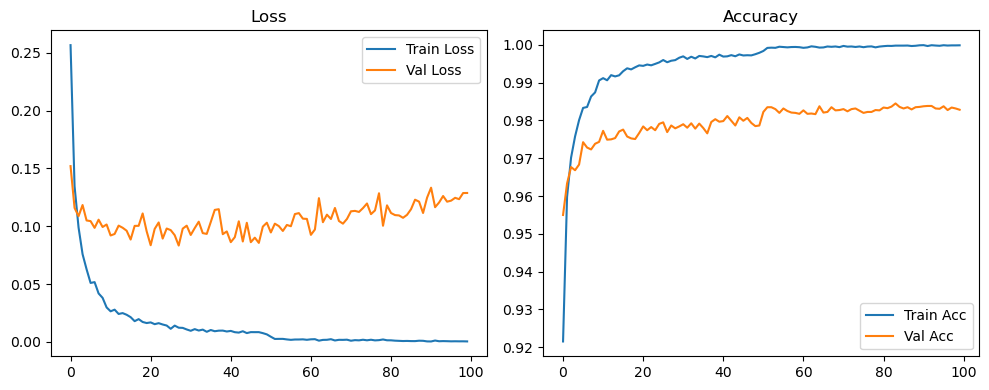

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3291, Acc: 0.9023 | Val Loss: 0.1657, Acc: 0.9514


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1924, Acc: 0.9429 | Val Loss: 0.1278, Acc: 0.9617


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1551, Acc: 0.9529 | Val Loss: 0.1169, Acc: 0.9649


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1288, Acc: 0.9616 | Val Loss: 0.1063, Acc: 0.9689


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1101, Acc: 0.9659 | Val Loss: 0.0912, Acc: 0.9728


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0967, Acc: 0.9696 | Val Loss: 0.0850, Acc: 0.9741


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0833, Acc: 0.9732 | Val Loss: 0.0859, Acc: 0.9751


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0735, Acc: 0.9757 | Val Loss: 0.0901, Acc: 0.9736


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0723, Acc: 0.9767 | Val Loss: 0.0839, Acc: 0.9762


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0661, Acc: 0.9778 | Val Loss: 0.0815, Acc: 0.9772


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9795 | Val Loss: 0.0873, Acc: 0.9748


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9815 | Val Loss: 0.0819, Acc: 0.9772


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9815 | Val Loss: 0.0824, Acc: 0.9762


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0515, Acc: 0.9831 | Val Loss: 0.0734, Acc: 0.9799


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9820 | Val Loss: 0.0787, Acc: 0.9777


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9837 | Val Loss: 0.0772, Acc: 0.9780


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0453, Acc: 0.9854 | Val Loss: 0.0753, Acc: 0.9781


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9848 | Val Loss: 0.0770, Acc: 0.9796


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0433, Acc: 0.9858 | Val Loss: 0.0778, Acc: 0.9791


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9874 | Val Loss: 0.0809, Acc: 0.9768


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.0794, Acc: 0.9791


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9873 | Val Loss: 0.0740, Acc: 0.9811


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9880 | Val Loss: 0.0807, Acc: 0.9802


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.0745, Acc: 0.9805


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9883 | Val Loss: 0.0776, Acc: 0.9788


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9889 | Val Loss: 0.0762, Acc: 0.9798


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9882 | Val Loss: 0.0768, Acc: 0.9790


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0734, Acc: 0.9796


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9898 | Val Loss: 0.0791, Acc: 0.9798


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.0815, Acc: 0.9798


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0331, Acc: 0.9886 | Val Loss: 0.0785, Acc: 0.9793


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9901 | Val Loss: 0.0782, Acc: 0.9803


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9911 | Val Loss: 0.0771, Acc: 0.9808


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9905 | Val Loss: 0.0816, Acc: 0.9791


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.0839, Acc: 0.9803


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.0791, Acc: 0.9797


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9916 | Val Loss: 0.0820, Acc: 0.9811


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.0794, Acc: 0.9807


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9920 | Val Loss: 0.0828, Acc: 0.9798


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.0742, Acc: 0.9806


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.0785, Acc: 0.9795


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0909, Acc: 0.9806


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9920 | Val Loss: 0.0825, Acc: 0.9798


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.0960, Acc: 0.9795


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9922 | Val Loss: 0.0783, Acc: 0.9815


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9921 | Val Loss: 0.0765, Acc: 0.9803


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9917 | Val Loss: 0.0691, Acc: 0.9810


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0822, Acc: 0.9813


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9930 | Val Loss: 0.0680, Acc: 0.9818


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9922 | Val Loss: 0.0743, Acc: 0.9822


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9943 | Val Loss: 0.0827, Acc: 0.9825


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0746, Acc: 0.9835


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0851, Acc: 0.9838


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0763, Acc: 0.9838


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0832, Acc: 0.9832


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0822, Acc: 0.9834


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.0770, Acc: 0.9831


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0744, Acc: 0.9822


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0794, Acc: 0.9830


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0795, Acc: 0.9819


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0812, Acc: 0.9830


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.0804, Acc: 0.9829


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0906, Acc: 0.9838


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0860, Acc: 0.9828


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0839, Acc: 0.9836


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0907, Acc: 0.9831


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0866, Acc: 0.9825


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0789, Acc: 0.9829


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0871, Acc: 0.9823


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0859, Acc: 0.9832


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0881, Acc: 0.9828


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0938, Acc: 0.9840


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0947, Acc: 0.9843


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0792, Acc: 0.9831


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0945, Acc: 0.9830


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1014, Acc: 0.9832


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0816, Acc: 0.9838


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0838, Acc: 0.9828


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0924, Acc: 0.9828


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0806, Acc: 0.9846


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0865, Acc: 0.9844


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0892, Acc: 0.9840


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0850, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0875, Acc: 0.9833


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0890, Acc: 0.9837


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0920, Acc: 0.9830


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1033, Acc: 0.9824


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0964, Acc: 0.9834


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0962, Acc: 0.9829


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9985 | Val Loss: 0.0995, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1028, Acc: 0.9832


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0914, Acc: 0.9834


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0975, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1001, Acc: 0.9835


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0921, Acc: 0.9836


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1049, Acc: 0.9841


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1125, Acc: 0.9842


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1029, Acc: 0.9837


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0930, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1051, Acc: 0.9832


Final Test Loss: 0.0920 Accuracy: 0.9846


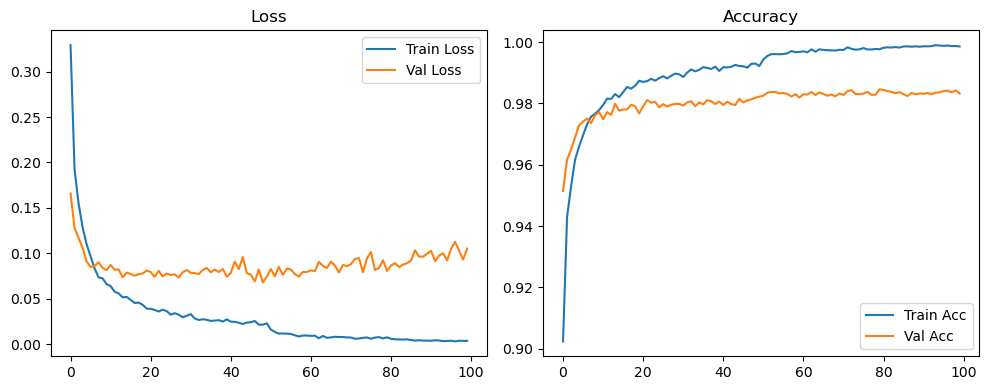

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2136, Acc: 0.9343 | Val Loss: 0.1391, Acc: 0.9600


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1033, Acc: 0.9674 | Val Loss: 0.1090, Acc: 0.9664


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0723, Acc: 0.9773 | Val Loss: 0.1094, Acc: 0.9688


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9838 | Val Loss: 0.1067, Acc: 0.9700


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0412, Acc: 0.9860 | Val Loss: 0.1239, Acc: 0.9653


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9891 | Val Loss: 0.1234, Acc: 0.9697


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9879 | Val Loss: 0.1031, Acc: 0.9734


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9916 | Val Loss: 0.1222, Acc: 0.9701


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.1053, Acc: 0.9762


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9924 | Val Loss: 0.1213, Acc: 0.9722


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.1234, Acc: 0.9731


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9749


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9932 | Val Loss: 0.1266, Acc: 0.9742


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9951 | Val Loss: 0.1106, Acc: 0.9765


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9941 | Val Loss: 0.1129, Acc: 0.9769


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9946 | Val Loss: 0.1106, Acc: 0.9777


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1134, Acc: 0.9744


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.1288, Acc: 0.9756


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1148, Acc: 0.9755


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1124, Acc: 0.9789


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1175, Acc: 0.9775


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1161, Acc: 0.9773


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1204, Acc: 0.9775


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1106, Acc: 0.9792


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.1331, Acc: 0.9742


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1310, Acc: 0.9771


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1150, Acc: 0.9788


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1348, Acc: 0.9755


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1188, Acc: 0.9773


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1278, Acc: 0.9777


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1381, Acc: 0.9760


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9974 | Val Loss: 0.1131, Acc: 0.9784


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1163, Acc: 0.9783


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1184, Acc: 0.9774


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1184, Acc: 0.9782


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1353, Acc: 0.9770


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1322, Acc: 0.9766


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1160, Acc: 0.9790


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1217, Acc: 0.9771


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1203, Acc: 0.9778


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1172, Acc: 0.9797


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1153, Acc: 0.9798


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1177, Acc: 0.9798


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1205, Acc: 0.9775


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1034, Acc: 0.9801


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1184, Acc: 0.9792


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1376, Acc: 0.9762


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1155, Acc: 0.9790


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.1135, Acc: 0.9808


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9986 | Val Loss: 0.1514, Acc: 0.9760


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1180, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1061, Acc: 0.9808


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1096, Acc: 0.9814


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1252, Acc: 0.9767


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1185, Acc: 0.9789


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1135, Acc: 0.9789


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1074, Acc: 0.9799


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1140, Acc: 0.9805


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1196, Acc: 0.9793


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1153, Acc: 0.9794


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1077, Acc: 0.9804


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1118, Acc: 0.9790


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1044, Acc: 0.9791


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1029, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1100, Acc: 0.9802


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1204, Acc: 0.9790


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1270, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1406, Acc: 0.9759


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1192, Acc: 0.9785


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1194, Acc: 0.9782


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0967, Acc: 0.9811


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1125, Acc: 0.9806


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1121, Acc: 0.9800


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1159, Acc: 0.9787


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1053, Acc: 0.9802


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0998, Acc: 0.9805


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1025, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1068, Acc: 0.9817


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1058, Acc: 0.9803


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0981, Acc: 0.9809


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1125, Acc: 0.9803


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1140, Acc: 0.9800


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1070, Acc: 0.9812


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1018, Acc: 0.9800


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1043, Acc: 0.9809


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1054, Acc: 0.9818


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1168, Acc: 0.9814


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1081, Acc: 0.9807


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1115, Acc: 0.9811


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1134, Acc: 0.9799


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1050, Acc: 0.9781


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1072, Acc: 0.9790


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1019, Acc: 0.9810


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1079, Acc: 0.9809


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1023, Acc: 0.9809


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1145, Acc: 0.9802


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1115, Acc: 0.9807


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1083, Acc: 0.9802


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1054, Acc: 0.9795


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1168, Acc: 0.9802


Final Test Loss: 0.1179 Accuracy: 0.9811


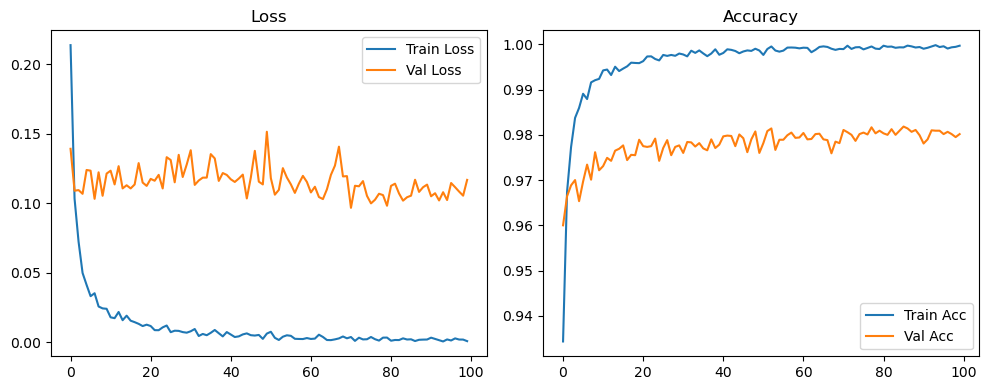

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2299, Acc: 0.9297 | Val Loss: 0.1528, Acc: 0.9541


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1219, Acc: 0.9629 | Val Loss: 0.1167, Acc: 0.9650


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0884, Acc: 0.9723 | Val Loss: 0.1007, Acc: 0.9699


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0715, Acc: 0.9770 | Val Loss: 0.1057, Acc: 0.9699


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9828 | Val Loss: 0.0984, Acc: 0.9722


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9838 | Val Loss: 0.1026, Acc: 0.9727


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9845 | Val Loss: 0.0991, Acc: 0.9734


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9871 | Val Loss: 0.1084, Acc: 0.9732


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0378, Acc: 0.9872 | Val Loss: 0.0913, Acc: 0.9760


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9892 | Val Loss: 0.1000, Acc: 0.9756


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.1076, Acc: 0.9752


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9916 | Val Loss: 0.0964, Acc: 0.9772


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1116, Acc: 0.9747


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9906 | Val Loss: 0.1053, Acc: 0.9736


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1004, Acc: 0.9762


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9926 | Val Loss: 0.1041, Acc: 0.9756


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1177, Acc: 0.9742


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.1228, Acc: 0.9759


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9932 | Val Loss: 0.1163, Acc: 0.9750


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1062, Acc: 0.9772


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1183, Acc: 0.9760


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1101, Acc: 0.9778


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0978, Acc: 0.9798


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1181, Acc: 0.9743


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1163, Acc: 0.9747


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1130, Acc: 0.9782


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.1019, Acc: 0.9788


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1099, Acc: 0.9772


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1085, Acc: 0.9773


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1107, Acc: 0.9792


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1075, Acc: 0.9779


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1099, Acc: 0.9792


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9970 | Val Loss: 0.1036, Acc: 0.9802


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1128, Acc: 0.9792


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1167, Acc: 0.9787


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1145, Acc: 0.9782


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1184, Acc: 0.9765


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9969 | Val Loss: 0.1061, Acc: 0.9803


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1070, Acc: 0.9795


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1061, Acc: 0.9798


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1061, Acc: 0.9799


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1133, Acc: 0.9791


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1070, Acc: 0.9791


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1083, Acc: 0.9778


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1043, Acc: 0.9795


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1022, Acc: 0.9791


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1068, Acc: 0.9772


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1103, Acc: 0.9791


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0985, Acc: 0.9804


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0980, Acc: 0.9795


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1007, Acc: 0.9803


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1065, Acc: 0.9796


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0914, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1130, Acc: 0.9797


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0935, Acc: 0.9816


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0929, Acc: 0.9808


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0951, Acc: 0.9808


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1035, Acc: 0.9803


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1039, Acc: 0.9806


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0979, Acc: 0.9814


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0944, Acc: 0.9817


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0953, Acc: 0.9808


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1120, Acc: 0.9796


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1014, Acc: 0.9811


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0996, Acc: 0.9796


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1046, Acc: 0.9786


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1113, Acc: 0.9804


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1040, Acc: 0.9820


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1091, Acc: 0.9791


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1017, Acc: 0.9806


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0977, Acc: 0.9811


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1054, Acc: 0.9799


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0956, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1023, Acc: 0.9799


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1084, Acc: 0.9791


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1072, Acc: 0.9807


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0998, Acc: 0.9796


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0989, Acc: 0.9805


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0986, Acc: 0.9819


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1118, Acc: 0.9798


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0988, Acc: 0.9813


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1087, Acc: 0.9804


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0996, Acc: 0.9810


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1045, Acc: 0.9818


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0895, Acc: 0.9824


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1030, Acc: 0.9812


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1043, Acc: 0.9800


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0997, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1103, Acc: 0.9809


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1020, Acc: 0.9802


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1099, Acc: 0.9804


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1018, Acc: 0.9804


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0994, Acc: 0.9825


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1008, Acc: 0.9812


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1006, Acc: 0.9804


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1038, Acc: 0.9808


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1124, Acc: 0.9805


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1118, Acc: 0.9808


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1094, Acc: 0.9809


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1132, Acc: 0.9804


Final Test Loss: 0.1074 Accuracy: 0.9822


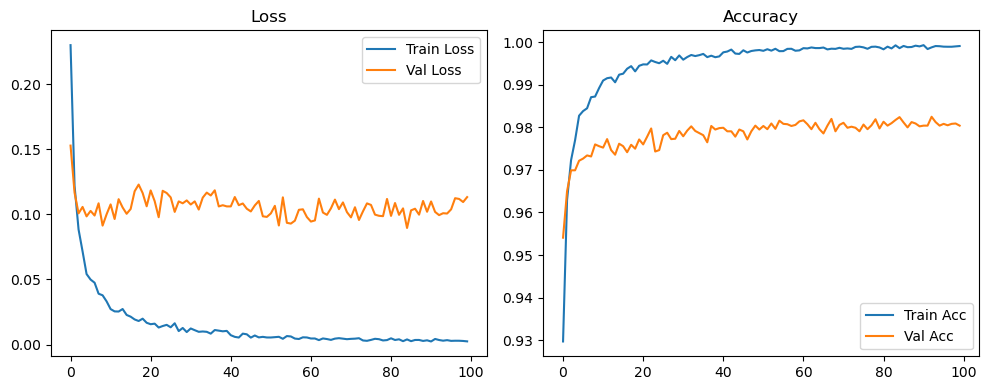

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3024, Acc: 0.9070 | Val Loss: 0.1503, Acc: 0.9546


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1770, Acc: 0.9462 | Val Loss: 0.1271, Acc: 0.9608


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1422, Acc: 0.9562 | Val Loss: 0.1083, Acc: 0.9662


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1203, Acc: 0.9626 | Val Loss: 0.1060, Acc: 0.9684


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1077, Acc: 0.9659 | Val Loss: 0.0944, Acc: 0.9722


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0934, Acc: 0.9702 | Val Loss: 0.0954, Acc: 0.9720


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0885, Acc: 0.9720 | Val Loss: 0.0941, Acc: 0.9729


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0771, Acc: 0.9757 | Val Loss: 0.0965, Acc: 0.9734


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0742, Acc: 0.9762 | Val Loss: 0.0848, Acc: 0.9768


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0685, Acc: 0.9787 | Val Loss: 0.0869, Acc: 0.9746


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9787 | Val Loss: 0.0874, Acc: 0.9755


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9814 | Val Loss: 0.0876, Acc: 0.9770


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0573, Acc: 0.9809 | Val Loss: 0.0871, Acc: 0.9774


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0552, Acc: 0.9829 | Val Loss: 0.0854, Acc: 0.9763


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0525, Acc: 0.9830 | Val Loss: 0.0804, Acc: 0.9791


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9844 | Val Loss: 0.0848, Acc: 0.9778


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.0836, Acc: 0.9800


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9862 | Val Loss: 0.0850, Acc: 0.9781


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9863 | Val Loss: 0.0918, Acc: 0.9782


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0394, Acc: 0.9879 | Val Loss: 0.0848, Acc: 0.9781


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0375, Acc: 0.9881 | Val Loss: 0.0884, Acc: 0.9785


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9875 | Val Loss: 0.0884, Acc: 0.9797


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0381, Acc: 0.9879 | Val Loss: 0.0827, Acc: 0.9799


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9884 | Val Loss: 0.0808, Acc: 0.9801


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9897 | Val Loss: 0.0850, Acc: 0.9797


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.0845, Acc: 0.9803


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9906 | Val Loss: 0.0796, Acc: 0.9808


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0268, Acc: 0.9915 | Val Loss: 0.0804, Acc: 0.9807


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9917 | Val Loss: 0.0782, Acc: 0.9808


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0799, Acc: 0.9806


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9926 | Val Loss: 0.0768, Acc: 0.9815


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0218, Acc: 0.9925 | Val Loss: 0.0810, Acc: 0.9809


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0865, Acc: 0.9797


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9929 | Val Loss: 0.0856, Acc: 0.9805


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0855, Acc: 0.9802


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9920 | Val Loss: 0.0767, Acc: 0.9818


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0846, Acc: 0.9800


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0774, Acc: 0.9812


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.0772, Acc: 0.9823


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0770, Acc: 0.9811


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.0822, Acc: 0.9805


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0861, Acc: 0.9812


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9938 | Val Loss: 0.0826, Acc: 0.9815


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.0786, Acc: 0.9812


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.0811, Acc: 0.9823


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0813, Acc: 0.9816


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9938 | Val Loss: 0.0841, Acc: 0.9816


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9943 | Val Loss: 0.0825, Acc: 0.9805


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0871, Acc: 0.9814


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0891, Acc: 0.9810


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0818, Acc: 0.9819


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0819, Acc: 0.9814


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9949 | Val Loss: 0.0882, Acc: 0.9807


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.0863, Acc: 0.9817


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0810, Acc: 0.9823


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.0912, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0799, Acc: 0.9819


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.0886, Acc: 0.9812


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0835, Acc: 0.9824


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.0842, Acc: 0.9818


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0955, Acc: 0.9811


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0836, Acc: 0.9813


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0897, Acc: 0.9831


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0851, Acc: 0.9819


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.0808, Acc: 0.9842


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0811, Acc: 0.9824


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0853, Acc: 0.9817


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0849, Acc: 0.9818


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0762, Acc: 0.9819


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0806, Acc: 0.9822


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9960 | Val Loss: 0.0955, Acc: 0.9824


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0941, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0911, Acc: 0.9812


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0918, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0903, Acc: 0.9807


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0855, Acc: 0.9825


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.0945, Acc: 0.9816


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0862, Acc: 0.9812


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0930, Acc: 0.9810


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.0876, Acc: 0.9814


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0921, Acc: 0.9805


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0931, Acc: 0.9812


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0896, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0907, Acc: 0.9817


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0786, Acc: 0.9822


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0989, Acc: 0.9819


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0789, Acc: 0.9827


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0897, Acc: 0.9822


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0861, Acc: 0.9828


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0916, Acc: 0.9830


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0937, Acc: 0.9810


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9964 | Val Loss: 0.0946, Acc: 0.9824


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0904, Acc: 0.9823


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0863, Acc: 0.9824


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0828, Acc: 0.9827


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0880, Acc: 0.9816


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0906, Acc: 0.9812


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0826, Acc: 0.9817


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0945, Acc: 0.9812


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0863, Acc: 0.9814


Final Test Loss: 0.0738 Accuracy: 0.9837


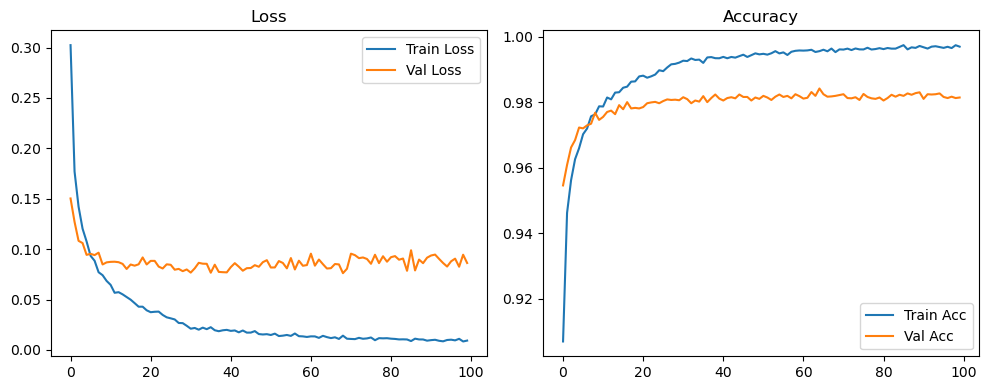

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1982, Acc: 0.9387 | Val Loss: 0.1264, Acc: 0.9624


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0916, Acc: 0.9711 | Val Loss: 0.1071, Acc: 0.9667


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0606, Acc: 0.9806 | Val Loss: 0.0952, Acc: 0.9716


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0417, Acc: 0.9868 | Val Loss: 0.1077, Acc: 0.9702


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0363, Acc: 0.9876 | Val Loss: 0.1239, Acc: 0.9662


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9906 | Val Loss: 0.1103, Acc: 0.9728


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.0985, Acc: 0.9744


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1140, Acc: 0.9722


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.1035, Acc: 0.9743


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.1020, Acc: 0.9752


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1138, Acc: 0.9725


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1183, Acc: 0.9729


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9948 | Val Loss: 0.1148, Acc: 0.9735


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.0973, Acc: 0.9772


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1075, Acc: 0.9778


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1132, Acc: 0.9761


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.1191, Acc: 0.9772


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.1064, Acc: 0.9768


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1027, Acc: 0.9782


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.1033, Acc: 0.9778


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1201, Acc: 0.9778


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1179, Acc: 0.9781


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1411, Acc: 0.9734


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1265, Acc: 0.9749


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1222, Acc: 0.9760


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1187, Acc: 0.9779


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1222, Acc: 0.9770


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.1386, Acc: 0.9737


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1182, Acc: 0.9784


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1203, Acc: 0.9790


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1095, Acc: 0.9799


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1132, Acc: 0.9797


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1211, Acc: 0.9795


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1198, Acc: 0.9782


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1360, Acc: 0.9783


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1226, Acc: 0.9770


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1361, Acc: 0.9792


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.1197, Acc: 0.9783


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1223, Acc: 0.9788


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1147, Acc: 0.9799


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1051, Acc: 0.9794


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1148, Acc: 0.9792


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1294, Acc: 0.9788


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1348, Acc: 0.9765


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1447, Acc: 0.9755


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.1168, Acc: 0.9782


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1157, Acc: 0.9793


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1153, Acc: 0.9802


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1239, Acc: 0.9793


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1263, Acc: 0.9791


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1187, Acc: 0.9785


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1334, Acc: 0.9781


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1244, Acc: 0.9791


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1145, Acc: 0.9808


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1174, Acc: 0.9791


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1320, Acc: 0.9788


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.1270, Acc: 0.9788


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1181, Acc: 0.9811


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1361, Acc: 0.9788


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1187, Acc: 0.9804


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1284, Acc: 0.9786


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1316, Acc: 0.9800


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1421, Acc: 0.9788


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1494, Acc: 0.9756


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1110, Acc: 0.9811


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1339, Acc: 0.9800


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1231, Acc: 0.9811


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1262, Acc: 0.9806


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1353, Acc: 0.9779


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1247, Acc: 0.9798


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1203, Acc: 0.9812


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1211, Acc: 0.9807


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1335, Acc: 0.9789


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1191, Acc: 0.9804


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1205, Acc: 0.9817


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1162, Acc: 0.9805


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1167, Acc: 0.9818


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1565, Acc: 0.9775


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1280, Acc: 0.9789


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1226, Acc: 0.9806


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1261, Acc: 0.9798


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1301, Acc: 0.9796


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1173, Acc: 0.9815


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1213, Acc: 0.9811


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1321, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1465, Acc: 0.9798


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1310, Acc: 0.9799


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1369, Acc: 0.9801


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9994 | Val Loss: 0.1404, Acc: 0.9805


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1435, Acc: 0.9793


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1293, Acc: 0.9828


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1434, Acc: 0.9780


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1303, Acc: 0.9807


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1341, Acc: 0.9794


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1435, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1360, Acc: 0.9808


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1418, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1298, Acc: 0.9782


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1279, Acc: 0.9804


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1322, Acc: 0.9798


Final Test Loss: 0.1231 Accuracy: 0.9818


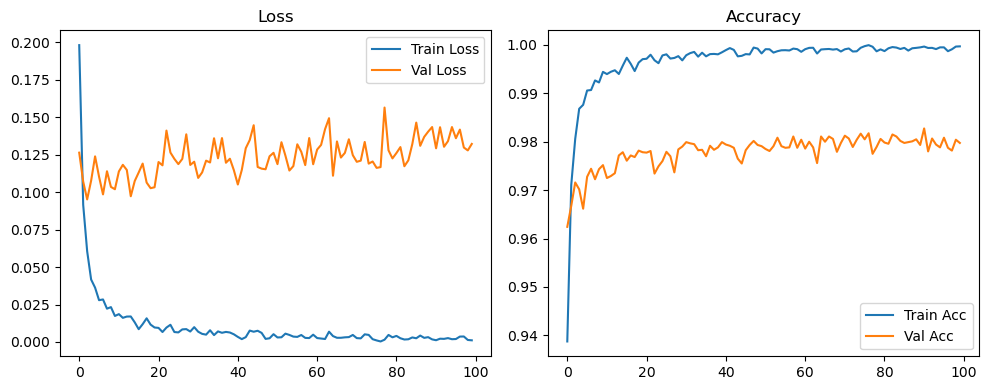

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2220, Acc: 0.9321 | Val Loss: 0.1418, Acc: 0.9560


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1091, Acc: 0.9654 | Val Loss: 0.1027, Acc: 0.9688


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9746 | Val Loss: 0.1049, Acc: 0.9676


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0611, Acc: 0.9798 | Val Loss: 0.0967, Acc: 0.9705


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9831 | Val Loss: 0.0959, Acc: 0.9725


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9859 | Val Loss: 0.1059, Acc: 0.9716


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9860 | Val Loss: 0.0972, Acc: 0.9748


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.1160, Acc: 0.9703


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0303, Acc: 0.9896 | Val Loss: 0.0953, Acc: 0.9752


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0300, Acc: 0.9894 | Val Loss: 0.1062, Acc: 0.9722


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.0976, Acc: 0.9763


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.1016, Acc: 0.9758


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.1056, Acc: 0.9763


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.1174, Acc: 0.9731


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.1082, Acc: 0.9750


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.1077, Acc: 0.9762


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9936 | Val Loss: 0.1064, Acc: 0.9775


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.1030, Acc: 0.9777


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1171, Acc: 0.9741


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9936 | Val Loss: 0.1204, Acc: 0.9753


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0996, Acc: 0.9793


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0992, Acc: 0.9789


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1198, Acc: 0.9768


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1028, Acc: 0.9797


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.1099, Acc: 0.9786


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1118, Acc: 0.9790


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1109, Acc: 0.9772


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1166, Acc: 0.9763


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9957 | Val Loss: 0.1126, Acc: 0.9793


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1048, Acc: 0.9793


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0989, Acc: 0.9814


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1128, Acc: 0.9770


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.1098, Acc: 0.9790


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1187, Acc: 0.9769


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1082, Acc: 0.9779


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1170, Acc: 0.9779


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1144, Acc: 0.9786


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1099, Acc: 0.9779


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1018, Acc: 0.9822


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1168, Acc: 0.9785


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1202, Acc: 0.9778


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1082, Acc: 0.9806


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1143, Acc: 0.9794


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9976 | Val Loss: 0.1018, Acc: 0.9807


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1154, Acc: 0.9782


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1147, Acc: 0.9797


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1185, Acc: 0.9797


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.1164, Acc: 0.9802


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1198, Acc: 0.9789


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1177, Acc: 0.9784


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1185, Acc: 0.9803


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1108, Acc: 0.9807


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1153, Acc: 0.9796


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.1205, Acc: 0.9800


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1099, Acc: 0.9811


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1125, Acc: 0.9812


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1193, Acc: 0.9808


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1166, Acc: 0.9811


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1233, Acc: 0.9802


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1325, Acc: 0.9785


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1256, Acc: 0.9794


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1155, Acc: 0.9802


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1192, Acc: 0.9802


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1117, Acc: 0.9810


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1142, Acc: 0.9810


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1263, Acc: 0.9804


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1274, Acc: 0.9788


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1215, Acc: 0.9796


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1251, Acc: 0.9798


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1311, Acc: 0.9796


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1180, Acc: 0.9799


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1342, Acc: 0.9800


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1280, Acc: 0.9803


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1223, Acc: 0.9808


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1231, Acc: 0.9805


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1195, Acc: 0.9813


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1212, Acc: 0.9807


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1225, Acc: 0.9809


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1231, Acc: 0.9809


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1142, Acc: 0.9822


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1155, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1198, Acc: 0.9813


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1180, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1246, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1364, Acc: 0.9795


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1284, Acc: 0.9814


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1334, Acc: 0.9803


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1343, Acc: 0.9799


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1378, Acc: 0.9812


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1353, Acc: 0.9798


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1327, Acc: 0.9805


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1342, Acc: 0.9804


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1359, Acc: 0.9793


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1366, Acc: 0.9798


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1256, Acc: 0.9808


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1322, Acc: 0.9798


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1281, Acc: 0.9801


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1296, Acc: 0.9805


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1315, Acc: 0.9806


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1426, Acc: 0.9788


Final Test Loss: 0.1222 Accuracy: 0.9826


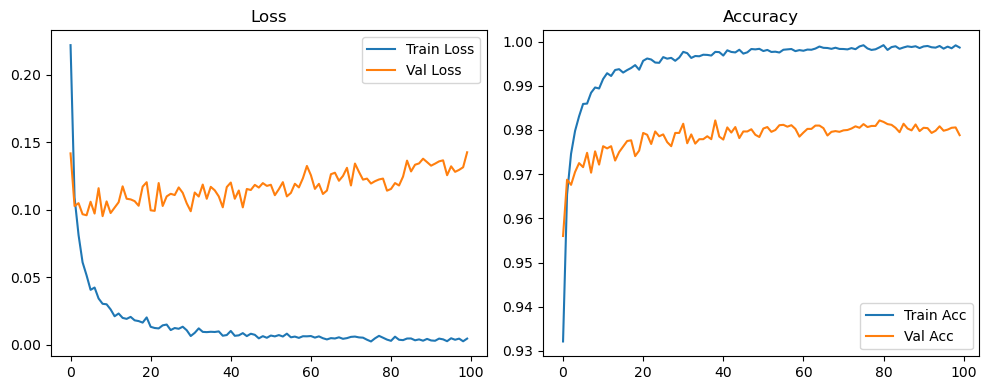

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3134, Acc: 0.9028 | Val Loss: 0.1433, Acc: 0.9570


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1687, Acc: 0.9477 | Val Loss: 0.1154, Acc: 0.9633


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1338, Acc: 0.9580 | Val Loss: 0.1081, Acc: 0.9668


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1134, Acc: 0.9633 | Val Loss: 0.0972, Acc: 0.9698


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1012, Acc: 0.9684 | Val Loss: 0.0886, Acc: 0.9720


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9712 | Val Loss: 0.0900, Acc: 0.9748


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0847, Acc: 0.9724 | Val Loss: 0.0865, Acc: 0.9744


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0762, Acc: 0.9757 | Val Loss: 0.0974, Acc: 0.9707


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0714, Acc: 0.9765 | Val Loss: 0.0833, Acc: 0.9755


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0671, Acc: 0.9779 | Val Loss: 0.0806, Acc: 0.9758


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0609, Acc: 0.9799 | Val Loss: 0.0869, Acc: 0.9750


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0590, Acc: 0.9807 | Val Loss: 0.0798, Acc: 0.9770


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9815 | Val Loss: 0.0835, Acc: 0.9768


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9830 | Val Loss: 0.0794, Acc: 0.9774


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9842 | Val Loss: 0.0799, Acc: 0.9784


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9841 | Val Loss: 0.0809, Acc: 0.9788


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0410, Acc: 0.9859 | Val Loss: 0.0837, Acc: 0.9766


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9856 | Val Loss: 0.0803, Acc: 0.9787


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9862 | Val Loss: 0.0832, Acc: 0.9775


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.0794, Acc: 0.9794


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9873 | Val Loss: 0.0857, Acc: 0.9770


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9885 | Val Loss: 0.0811, Acc: 0.9795


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9888 | Val Loss: 0.0855, Acc: 0.9776


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.0777, Acc: 0.9811


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9903 | Val Loss: 0.0862, Acc: 0.9789


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.0827, Acc: 0.9795


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0896, Acc: 0.9792


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.0937, Acc: 0.9769


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.0914, Acc: 0.9796


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9915 | Val Loss: 0.0891, Acc: 0.9800


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0927, Acc: 0.9778


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0844, Acc: 0.9789


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9920 | Val Loss: 0.0913, Acc: 0.9787


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9927 | Val Loss: 0.0881, Acc: 0.9789


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.0869, Acc: 0.9791


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0226, Acc: 0.9925 | Val Loss: 0.0895, Acc: 0.9805


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.0946, Acc: 0.9788


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9921 | Val Loss: 0.0971, Acc: 0.9779


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.0950, Acc: 0.9795


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0895, Acc: 0.9802


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0928, Acc: 0.9794


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.0925, Acc: 0.9798


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.0880, Acc: 0.9808


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0927, Acc: 0.9798


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.0891, Acc: 0.9808


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9935 | Val Loss: 0.0863, Acc: 0.9807


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9938 | Val Loss: 0.0911, Acc: 0.9812


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0890, Acc: 0.9809


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0956, Acc: 0.9807


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0960, Acc: 0.9798


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9944 | Val Loss: 0.0881, Acc: 0.9811


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0897, Acc: 0.9821


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0907, Acc: 0.9818


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.0990, Acc: 0.9805


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.0970, Acc: 0.9810


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.0962, Acc: 0.9811


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0955, Acc: 0.9808


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9953 | Val Loss: 0.1012, Acc: 0.9798


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0976, Acc: 0.9802


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1013, Acc: 0.9805


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.0926, Acc: 0.9821


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0983, Acc: 0.9814


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0958, Acc: 0.9804


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0915, Acc: 0.9808


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0907, Acc: 0.9808


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0927, Acc: 0.9808


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9958 | Val Loss: 0.0924, Acc: 0.9801


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0857, Acc: 0.9817


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0863, Acc: 0.9823


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.0879, Acc: 0.9819


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0867, Acc: 0.9817


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.0883, Acc: 0.9815


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0871, Acc: 0.9821


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0845, Acc: 0.9811


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0911, Acc: 0.9824


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0908, Acc: 0.9820


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0864, Acc: 0.9822


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0900, Acc: 0.9821


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0937, Acc: 0.9813


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0838, Acc: 0.9820


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0818, Acc: 0.9827


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.0854, Acc: 0.9828


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0862, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0906, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9965 | Val Loss: 0.0905, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0972, Acc: 0.9821


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.0957, Acc: 0.9812


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0858, Acc: 0.9825


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.0925, Acc: 0.9822


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0899, Acc: 0.9821


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0897, Acc: 0.9821


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0902, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0866, Acc: 0.9814


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0926, Acc: 0.9810


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0891, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0985, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0928, Acc: 0.9826


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0947, Acc: 0.9828


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.0981, Acc: 0.9806


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1004, Acc: 0.9810


Final Test Loss: 0.0827 Accuracy: 0.9842


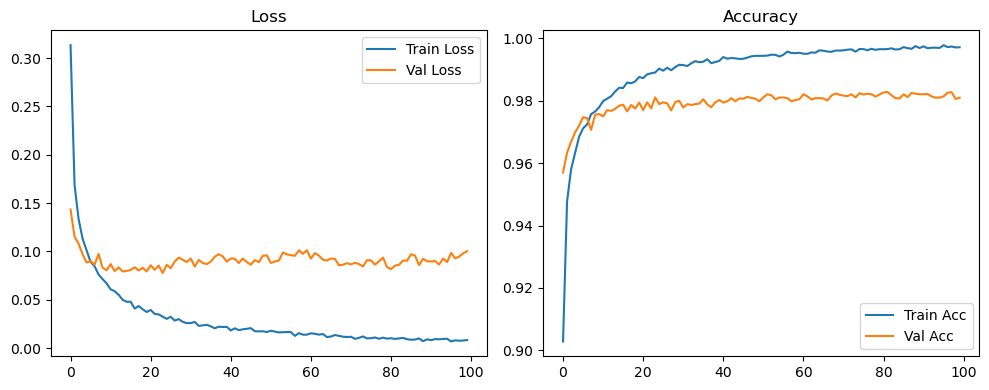

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2713, Acc: 0.9194 | Val Loss: 0.1604, Acc: 0.9523


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9658 | Val Loss: 0.1441, Acc: 0.9585


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9770 | Val Loss: 0.1134, Acc: 0.9666


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.1096, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1344, Acc: 0.9681


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9877 | Val Loss: 0.1156, Acc: 0.9709


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.1170, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.1127, Acc: 0.9709


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1297, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1071, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0989, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1137, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1500, Acc: 0.9671


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1050, Acc: 0.9734


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1072, Acc: 0.9750


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1025, Acc: 0.9754


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1153, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1050, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1247, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1195, Acc: 0.9753


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1113, Acc: 0.9744


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1026, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1205, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1277, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1246, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1144, Acc: 0.9768


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1180, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1100, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0986, Acc: 0.9765


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1163, Acc: 0.9719


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1229, Acc: 0.9746


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1110, Acc: 0.9732


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1061, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1055, Acc: 0.9767


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1281, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1070, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1272, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1199, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1196, Acc: 0.9770


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1221, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1248, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1057, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1237, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1231, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1329, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1015, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1136, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1041, Acc: 0.9774


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1293, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1216, Acc: 0.9744


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1170, Acc: 0.9762


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1225, Acc: 0.9768


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1189, Acc: 0.9744


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1344, Acc: 0.9772


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1314, Acc: 0.9749


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1040, Acc: 0.9762


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1209, Acc: 0.9720


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1328, Acc: 0.9744


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1379, Acc: 0.9754


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1355, Acc: 0.9775


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1230, Acc: 0.9764


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1263, Acc: 0.9768


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.1525, Acc: 0.9782


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1172, Acc: 0.9771


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1181, Acc: 0.9765


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1362, Acc: 0.9768


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1687, Acc: 0.9757


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1287, Acc: 0.9750


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1022, Acc: 0.9764


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1453, Acc: 0.9768


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1530, Acc: 0.9758


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1345, Acc: 0.9759


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1457, Acc: 0.9777


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1426, Acc: 0.9765


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1370, Acc: 0.9770


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1061, Acc: 0.9761


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1217, Acc: 0.9774


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1133, Acc: 0.9772


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1413, Acc: 0.9766


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1297, Acc: 0.9732


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1639, Acc: 0.9778


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1352, Acc: 0.9780


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1173, Acc: 0.9747


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1323, Acc: 0.9765


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1532, Acc: 0.9766


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1480, Acc: 0.9772


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1608, Acc: 0.9752


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1137, Acc: 0.9783


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1352, Acc: 0.9784


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1523, Acc: 0.9789


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1255, Acc: 0.9768


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1414, Acc: 0.9758


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1855, Acc: 0.9760


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1500, Acc: 0.9767


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0912, Acc: 0.9750


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1093, Acc: 0.9773


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1210, Acc: 0.9764


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1219, Acc: 0.9778


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1681, Acc: 0.9761


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9991 | Val Loss: 0.1586, Acc: 0.9764


Final Test Loss: 0.1528 Accuracy: 0.9793


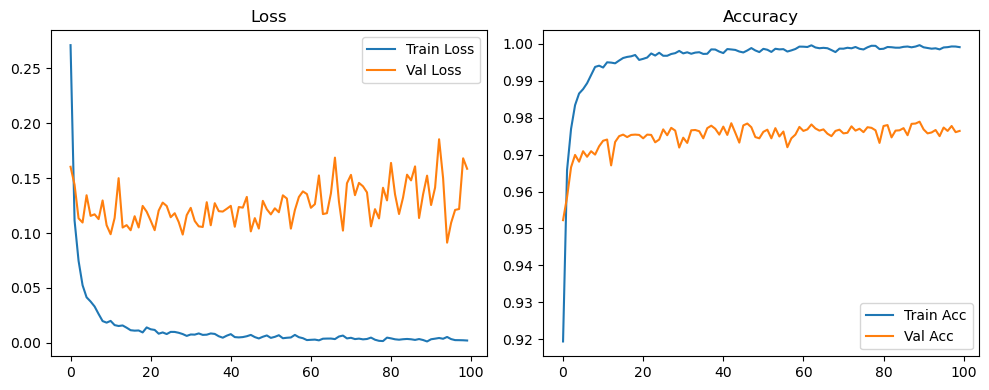

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2817, Acc: 0.9153 | Val Loss: 0.1622, Acc: 0.9525


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9607 | Val Loss: 0.1344, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0916, Acc: 0.9714 | Val Loss: 0.1206, Acc: 0.9655


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.1126, Acc: 0.9677


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9806 | Val Loss: 0.1128, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.1054, Acc: 0.9730


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9848 | Val Loss: 0.0963, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0916, Acc: 0.9747


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9903 | Val Loss: 0.1053, Acc: 0.9751


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1052, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1090, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.0931, Acc: 0.9754


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1020, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0944, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1070, Acc: 0.9768


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.0960, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0950, Acc: 0.9764


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0937, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0980, Acc: 0.9769


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0954, Acc: 0.9780


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1004, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0913, Acc: 0.9775


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1078, Acc: 0.9774


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0963, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1110, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0942, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1136, Acc: 0.9767


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1029, Acc: 0.9785


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0808, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1068, Acc: 0.9779


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1041, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0944, Acc: 0.9782


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1189, Acc: 0.9781


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1068, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1264, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0942, Acc: 0.9757


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0934, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1061, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0965, Acc: 0.9777


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1264, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1076, Acc: 0.9793


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1017, Acc: 0.9796


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1009, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0898, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1012, Acc: 0.9777


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1130, Acc: 0.9784


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1219, Acc: 0.9762


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1076, Acc: 0.9770


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1023, Acc: 0.9785


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1349, Acc: 0.9786


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1048, Acc: 0.9788


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1085, Acc: 0.9781


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.0909, Acc: 0.9782


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1181, Acc: 0.9764


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0978, Acc: 0.9790


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1306, Acc: 0.9785


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1240, Acc: 0.9785


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1167, Acc: 0.9795


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1314, Acc: 0.9768


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1095, Acc: 0.9761


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1170, Acc: 0.9775


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1063, Acc: 0.9765


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1178, Acc: 0.9770


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1228, Acc: 0.9789


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1058, Acc: 0.9782


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1079, Acc: 0.9800


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1241, Acc: 0.9782


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9974 | Val Loss: 0.0943, Acc: 0.9778


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1096, Acc: 0.9789


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1218, Acc: 0.9786


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1097, Acc: 0.9771


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1125, Acc: 0.9771


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1284, Acc: 0.9785


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1329, Acc: 0.9788


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1368, Acc: 0.9772


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0954, Acc: 0.9768


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9972 | Val Loss: 0.1612, Acc: 0.9784


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.1109, Acc: 0.9782


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1135, Acc: 0.9801


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0997, Acc: 0.9780


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1645, Acc: 0.9787


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0861, Acc: 0.9782


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0952, Acc: 0.9788


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0977, Acc: 0.9800


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0979, Acc: 0.9802


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1013, Acc: 0.9795


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1144, Acc: 0.9795


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.0936, Acc: 0.9773


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1198, Acc: 0.9780


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1174, Acc: 0.9778


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1310, Acc: 0.9777


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1312, Acc: 0.9788


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1218, Acc: 0.9781


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1535, Acc: 0.9795


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1182, Acc: 0.9791


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1101, Acc: 0.9792


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1298, Acc: 0.9768


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1157, Acc: 0.9788


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1279, Acc: 0.9802


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1524, Acc: 0.9799


Final Test Loss: 0.1429 Accuracy: 0.9808


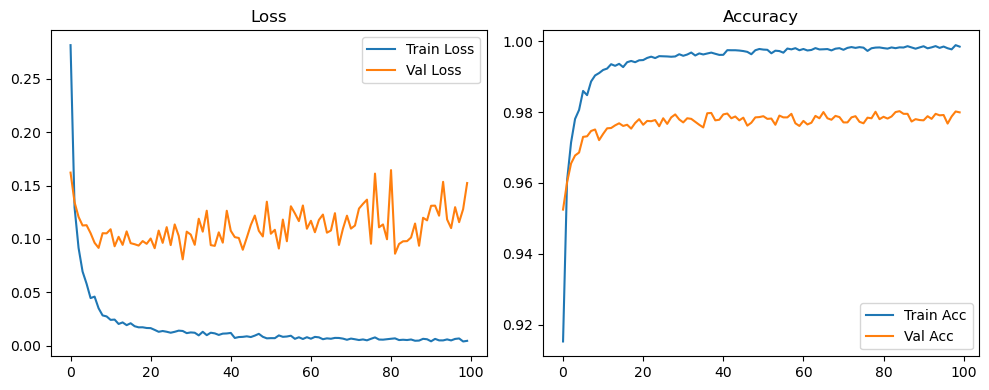

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3346, Acc: 0.9004 | Val Loss: 0.1802, Acc: 0.9484


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1830, Acc: 0.9454 | Val Loss: 0.1220, Acc: 0.9633


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1474, Acc: 0.9552 | Val Loss: 0.1163, Acc: 0.9653


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9642 | Val Loss: 0.1050, Acc: 0.9686


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9708 | Val Loss: 0.0881, Acc: 0.9733


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9738 | Val Loss: 0.0989, Acc: 0.9705


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9755 | Val Loss: 0.0907, Acc: 0.9743


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9782 | Val Loss: 0.0887, Acc: 0.9741


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9788 | Val Loss: 0.0881, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9807 | Val Loss: 0.0870, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9817 | Val Loss: 0.0826, Acc: 0.9765


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9821 | Val Loss: 0.0911, Acc: 0.9753


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.0869, Acc: 0.9771


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9837 | Val Loss: 0.0930, Acc: 0.9776


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9839 | Val Loss: 0.0786, Acc: 0.9780


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9846 | Val Loss: 0.0820, Acc: 0.9778


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.0941, Acc: 0.9749


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.0838, Acc: 0.9768


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0842, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9876 | Val Loss: 0.0861, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0884, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9874 | Val Loss: 0.0916, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0918, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.0898, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0879, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9890 | Val Loss: 0.0850, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0967, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0910, Acc: 0.9786


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0909, Acc: 0.9783


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.0838, Acc: 0.9768


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0869, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0868, Acc: 0.9780


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.0935, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0907, Acc: 0.9776


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.0886, Acc: 0.9791


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0818, Acc: 0.9790


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0981, Acc: 0.9782


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.0888, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.0972, Acc: 0.9802


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.0777, Acc: 0.9799


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0921, Acc: 0.9789


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0779, Acc: 0.9801


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0972, Acc: 0.9786


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.0840, Acc: 0.9797


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0834, Acc: 0.9788


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0834, Acc: 0.9795


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0768, Acc: 0.9797


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0790, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0817, Acc: 0.9811


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0801, Acc: 0.9811


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.0794, Acc: 0.9802


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.0917, Acc: 0.9792


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0899, Acc: 0.9801


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0813, Acc: 0.9801


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9921 | Val Loss: 0.0848, Acc: 0.9798


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.0909, Acc: 0.9791


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0927, Acc: 0.9792


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9928 | Val Loss: 0.1060, Acc: 0.9798


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9927 | Val Loss: 0.0934, Acc: 0.9804


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9931 | Val Loss: 0.0811, Acc: 0.9802


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0888, Acc: 0.9806


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9924 | Val Loss: 0.0901, Acc: 0.9797


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0805, Acc: 0.9810


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9932 | Val Loss: 0.1076, Acc: 0.9793


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.1043, Acc: 0.9802


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0229, Acc: 0.9924 | Val Loss: 0.0911, Acc: 0.9802


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9920 | Val Loss: 0.0855, Acc: 0.9789


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.0841, Acc: 0.9802


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.0973, Acc: 0.9814


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0896, Acc: 0.9807


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9935 | Val Loss: 0.1037, Acc: 0.9804


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0876, Acc: 0.9804


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9939 | Val Loss: 0.0925, Acc: 0.9794


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.0837, Acc: 0.9802


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9935 | Val Loss: 0.0859, Acc: 0.9808


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0926, Acc: 0.9801


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.0858, Acc: 0.9796


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0838, Acc: 0.9799


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9940 | Val Loss: 0.0944, Acc: 0.9815


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9937 | Val Loss: 0.0990, Acc: 0.9817


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0785, Acc: 0.9807


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0947, Acc: 0.9805


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9933 | Val Loss: 0.0843, Acc: 0.9803


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1070, Acc: 0.9798


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0795, Acc: 0.9802


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.0842, Acc: 0.9802


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1121, Acc: 0.9809


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9937 | Val Loss: 0.0875, Acc: 0.9811


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.0827, Acc: 0.9805


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1274, Acc: 0.9798


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.1235, Acc: 0.9792


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.0896, Acc: 0.9794


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0905, Acc: 0.9802


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0794, Acc: 0.9802


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9940 | Val Loss: 0.0836, Acc: 0.9802


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.0991, Acc: 0.9792


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.0842, Acc: 0.9806


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9938 | Val Loss: 0.0839, Acc: 0.9793


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.0794, Acc: 0.9811


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.0860, Acc: 0.9808


Final Test Loss: 0.0742 Accuracy: 0.9822


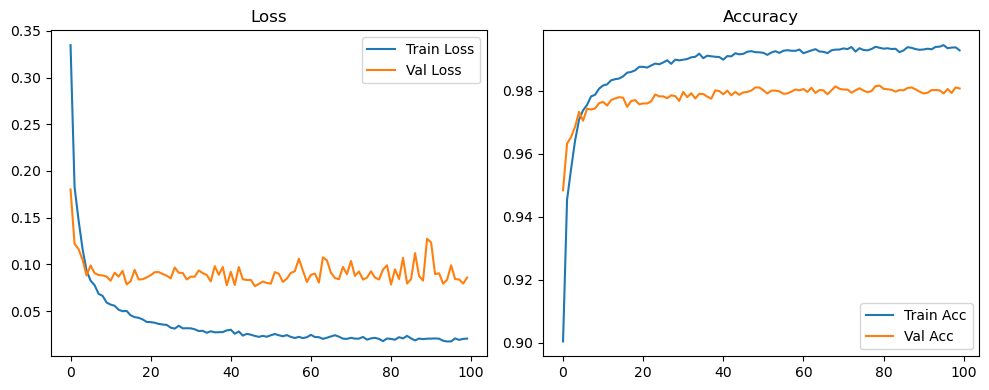

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2713, Acc: 0.9194 | Val Loss: 0.1604, Acc: 0.9523


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9658 | Val Loss: 0.1441, Acc: 0.9585


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9770 | Val Loss: 0.1134, Acc: 0.9666


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.1096, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1344, Acc: 0.9681


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9877 | Val Loss: 0.1156, Acc: 0.9709


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.1170, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.1127, Acc: 0.9709


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1297, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1071, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0989, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1137, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1500, Acc: 0.9671


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1050, Acc: 0.9734


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1072, Acc: 0.9750


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1025, Acc: 0.9754


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1153, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1050, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1247, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1195, Acc: 0.9753


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1113, Acc: 0.9744


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1026, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1205, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1277, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1246, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1144, Acc: 0.9768


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1180, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1100, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0986, Acc: 0.9765


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1163, Acc: 0.9719


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1229, Acc: 0.9746


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1110, Acc: 0.9732


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1061, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1055, Acc: 0.9767


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1281, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1070, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1272, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1199, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1196, Acc: 0.9770


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1221, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1248, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1057, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1237, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1231, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1329, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1015, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1136, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1041, Acc: 0.9774


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1293, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1216, Acc: 0.9744


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1303, Acc: 0.9780


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1315, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1301, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1323, Acc: 0.9796


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1414, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1434, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1446, Acc: 0.9799


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1336, Acc: 0.9797


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1431, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1136, Acc: 0.9785


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1208, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1468, Acc: 0.9785


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1212, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1293, Acc: 0.9794


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1388, Acc: 0.9781


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1562, Acc: 0.9790


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1102, Acc: 0.9779


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1578, Acc: 0.9773


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1302, Acc: 0.9783


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.1286, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1418, Acc: 0.9790


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1485, Acc: 0.9796


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1369, Acc: 0.9787


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1433, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1424, Acc: 0.9778


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1388, Acc: 0.9769


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1438, Acc: 0.9786


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1285, Acc: 0.9794


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1269, Acc: 0.9786


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1284, Acc: 0.9779


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1300, Acc: 0.9798


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1370, Acc: 0.9796


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1423, Acc: 0.9802


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1460, Acc: 0.9808


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1510, Acc: 0.9807


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1535, Acc: 0.9804


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1563, Acc: 0.9795


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1592, Acc: 0.9803


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1590, Acc: 0.9801


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1590, Acc: 0.9802


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1630, Acc: 0.9798


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1555, Acc: 0.9796


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1586, Acc: 0.9793


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1618, Acc: 0.9796


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1692, Acc: 0.9803


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1683, Acc: 0.9794


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1466, Acc: 0.9796


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1608, Acc: 0.9791


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1643, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1613, Acc: 0.9782


Final Test Loss: 0.1378 Accuracy: 0.9823


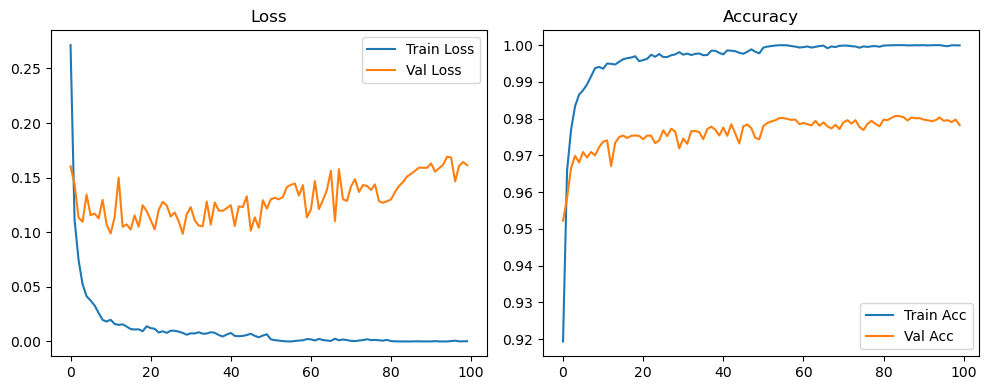

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2817, Acc: 0.9153 | Val Loss: 0.1622, Acc: 0.9525


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9607 | Val Loss: 0.1344, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0916, Acc: 0.9714 | Val Loss: 0.1206, Acc: 0.9655


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.1126, Acc: 0.9677


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9806 | Val Loss: 0.1128, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.1054, Acc: 0.9730


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9848 | Val Loss: 0.0963, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0916, Acc: 0.9747


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9903 | Val Loss: 0.1053, Acc: 0.9751


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1052, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1090, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.0931, Acc: 0.9754


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1020, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0944, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1070, Acc: 0.9768


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.0960, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0950, Acc: 0.9764


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0937, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0980, Acc: 0.9769


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0954, Acc: 0.9780


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1004, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0913, Acc: 0.9775


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1078, Acc: 0.9774


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0963, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1110, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0942, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1136, Acc: 0.9767


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1029, Acc: 0.9785


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0808, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1068, Acc: 0.9779


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1041, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0944, Acc: 0.9782


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1189, Acc: 0.9781


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1068, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1264, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0942, Acc: 0.9757


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0934, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1061, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0965, Acc: 0.9777


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1264, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1076, Acc: 0.9793


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1017, Acc: 0.9796


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1009, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0898, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1012, Acc: 0.9777


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1130, Acc: 0.9784


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1219, Acc: 0.9762


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1076, Acc: 0.9770


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1023, Acc: 0.9785


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1349, Acc: 0.9786


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1122, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1179, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1302, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1060, Acc: 0.9805


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1072, Acc: 0.9815


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1204, Acc: 0.9797


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1392, Acc: 0.9806


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1068, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1067, Acc: 0.9802


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1250, Acc: 0.9816


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1209, Acc: 0.9814


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1064, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0980, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1077, Acc: 0.9808


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1359, Acc: 0.9800


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1153, Acc: 0.9805


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1243, Acc: 0.9812


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1158, Acc: 0.9806


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1160, Acc: 0.9812


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1194, Acc: 0.9808


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1065, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1487, Acc: 0.9805


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1114, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1120, Acc: 0.9799


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1111, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1126, Acc: 0.9807


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1097, Acc: 0.9804


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1183, Acc: 0.9803


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1167, Acc: 0.9799


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1244, Acc: 0.9813


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1172, Acc: 0.9814


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1371, Acc: 0.9818


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1504, Acc: 0.9819


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1379, Acc: 0.9816


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1434, Acc: 0.9815


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1399, Acc: 0.9814


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1429, Acc: 0.9816


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1368, Acc: 0.9815


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1243, Acc: 0.9822


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1247, Acc: 0.9805


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1223, Acc: 0.9819


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1290, Acc: 0.9824


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1241, Acc: 0.9817


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1289, Acc: 0.9812


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1440, Acc: 0.9823


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1540, Acc: 0.9821


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1320, Acc: 0.9813


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1136, Acc: 0.9814


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1183, Acc: 0.9816


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1333, Acc: 0.9818


Final Test Loss: 0.1224 Accuracy: 0.9838


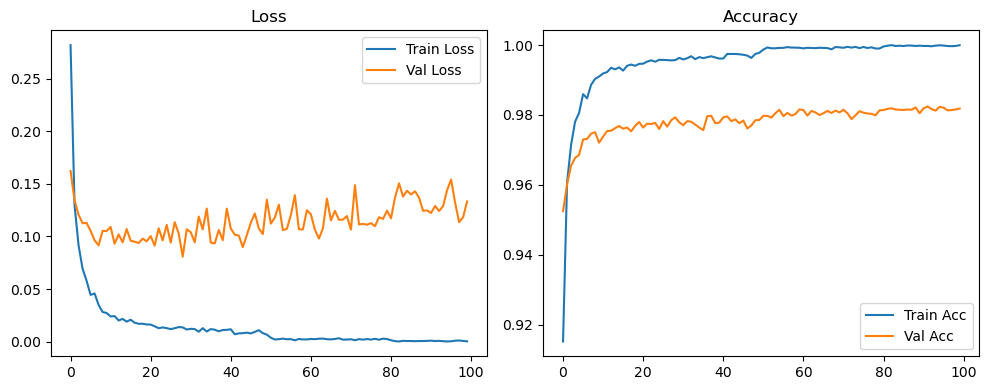

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3346, Acc: 0.9004 | Val Loss: 0.1802, Acc: 0.9484


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1830, Acc: 0.9454 | Val Loss: 0.1220, Acc: 0.9633


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1474, Acc: 0.9552 | Val Loss: 0.1163, Acc: 0.9653


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9642 | Val Loss: 0.1050, Acc: 0.9686


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9708 | Val Loss: 0.0881, Acc: 0.9733


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9738 | Val Loss: 0.0989, Acc: 0.9705


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9755 | Val Loss: 0.0907, Acc: 0.9743


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9782 | Val Loss: 0.0887, Acc: 0.9741


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9788 | Val Loss: 0.0881, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9807 | Val Loss: 0.0870, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9817 | Val Loss: 0.0826, Acc: 0.9765


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9821 | Val Loss: 0.0911, Acc: 0.9753


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.0869, Acc: 0.9771


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9837 | Val Loss: 0.0930, Acc: 0.9776


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9839 | Val Loss: 0.0786, Acc: 0.9780


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9846 | Val Loss: 0.0820, Acc: 0.9778


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.0941, Acc: 0.9749


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.0838, Acc: 0.9768


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0842, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9876 | Val Loss: 0.0861, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0884, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9874 | Val Loss: 0.0916, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0918, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.0898, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0879, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9890 | Val Loss: 0.0850, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0967, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0910, Acc: 0.9786


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0909, Acc: 0.9783


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.0838, Acc: 0.9768


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0869, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0868, Acc: 0.9780


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.0935, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0907, Acc: 0.9776


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.0886, Acc: 0.9791


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0818, Acc: 0.9790


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0981, Acc: 0.9782


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.0888, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.0972, Acc: 0.9802


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.0777, Acc: 0.9799


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0921, Acc: 0.9789


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0779, Acc: 0.9801


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0972, Acc: 0.9786


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.0840, Acc: 0.9797


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0834, Acc: 0.9788


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0834, Acc: 0.9795


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0768, Acc: 0.9797


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0790, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0817, Acc: 0.9811


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0801, Acc: 0.9811


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.0749, Acc: 0.9816


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0863, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0855, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0854, Acc: 0.9817


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0922, Acc: 0.9826


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0840, Acc: 0.9820


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0795, Acc: 0.9823


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0917, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0837, Acc: 0.9815


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0840, Acc: 0.9831


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0945, Acc: 0.9822


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0779, Acc: 0.9816


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0970, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.0877, Acc: 0.9815


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0971, Acc: 0.9809


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0875, Acc: 0.9810


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0976, Acc: 0.9805


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0990, Acc: 0.9815


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0833, Acc: 0.9817


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0997, Acc: 0.9817


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0974, Acc: 0.9819


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0851, Acc: 0.9815


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0920, Acc: 0.9812


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1057, Acc: 0.9813


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0955, Acc: 0.9804


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0836, Acc: 0.9808


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.0983, Acc: 0.9814


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1026, Acc: 0.9817


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0978, Acc: 0.9819


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0917, Acc: 0.9814


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0935, Acc: 0.9818


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0957, Acc: 0.9818


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0991, Acc: 0.9823


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.0938, Acc: 0.9827


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0961, Acc: 0.9822


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9983 | Val Loss: 0.0998, Acc: 0.9829


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1026, Acc: 0.9819


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1011, Acc: 0.9817


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0890, Acc: 0.9823


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1057, Acc: 0.9822


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1085, Acc: 0.9821


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1004, Acc: 0.9824


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1013, Acc: 0.9820


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1031, Acc: 0.9828


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0948, Acc: 0.9829


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0978, Acc: 0.9828


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9833


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0805, Acc: 0.9830


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0950, Acc: 0.9823


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.1028, Acc: 0.9824


Final Test Loss: 0.0951 Accuracy: 0.9844


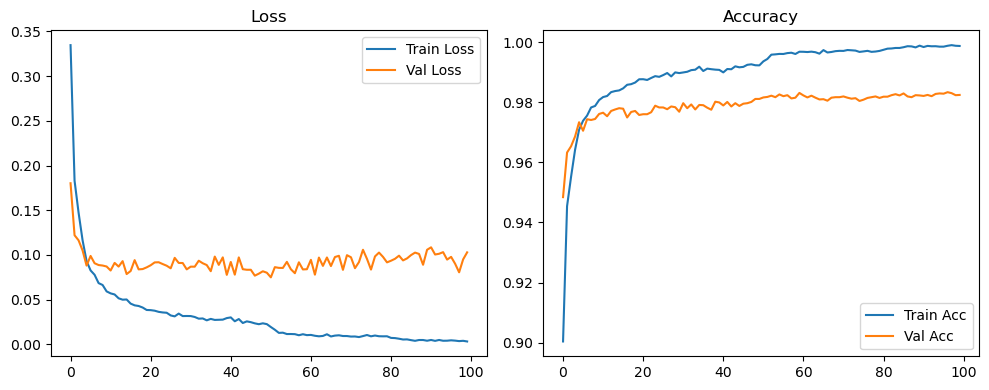

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2713, Acc: 0.9194 | Val Loss: 0.1604, Acc: 0.9523


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9658 | Val Loss: 0.1441, Acc: 0.9585


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9770 | Val Loss: 0.1134, Acc: 0.9666


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.1096, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1344, Acc: 0.9681


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9877 | Val Loss: 0.1156, Acc: 0.9709


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.1170, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.1127, Acc: 0.9709


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1297, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1071, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0989, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1137, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1500, Acc: 0.9671


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1050, Acc: 0.9734


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1072, Acc: 0.9750


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1025, Acc: 0.9754


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1153, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1050, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1247, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1195, Acc: 0.9753


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1113, Acc: 0.9744


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1026, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1205, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1277, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1246, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1144, Acc: 0.9768


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1180, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1100, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0986, Acc: 0.9765


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1163, Acc: 0.9719


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1229, Acc: 0.9746


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1110, Acc: 0.9732


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1061, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1055, Acc: 0.9767


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1281, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1070, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1272, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1199, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1196, Acc: 0.9770


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1221, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1248, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1057, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1237, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1231, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1329, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1015, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1136, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1041, Acc: 0.9774


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1293, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1216, Acc: 0.9744


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1303, Acc: 0.9780


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1315, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1301, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1323, Acc: 0.9796


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1414, Acc: 0.9802


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1434, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1446, Acc: 0.9799


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1336, Acc: 0.9797


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1431, Acc: 0.9798


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1136, Acc: 0.9785


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1208, Acc: 0.9788


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1468, Acc: 0.9785


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1212, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1293, Acc: 0.9794


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1388, Acc: 0.9781


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1562, Acc: 0.9790


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1102, Acc: 0.9779


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1578, Acc: 0.9773


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1302, Acc: 0.9783


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.1286, Acc: 0.9772


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1418, Acc: 0.9790


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1485, Acc: 0.9796


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1369, Acc: 0.9787


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1433, Acc: 0.9796


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1424, Acc: 0.9778


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1388, Acc: 0.9769


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1438, Acc: 0.9786


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1285, Acc: 0.9794


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1269, Acc: 0.9786


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1284, Acc: 0.9779


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1253, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1277, Acc: 0.9793


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1320, Acc: 0.9800


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1349, Acc: 0.9800


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1385, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1408, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1440, Acc: 0.9798


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1453, Acc: 0.9790


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1467, Acc: 0.9796


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1489, Acc: 0.9801


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1501, Acc: 0.9801


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1479, Acc: 0.9802


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1485, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1506, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1502, Acc: 0.9805


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1558, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1624, Acc: 0.9803


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1674, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1709, Acc: 0.9803


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1744, Acc: 0.9794


Final Test Loss: 0.1602 Accuracy: 0.9812


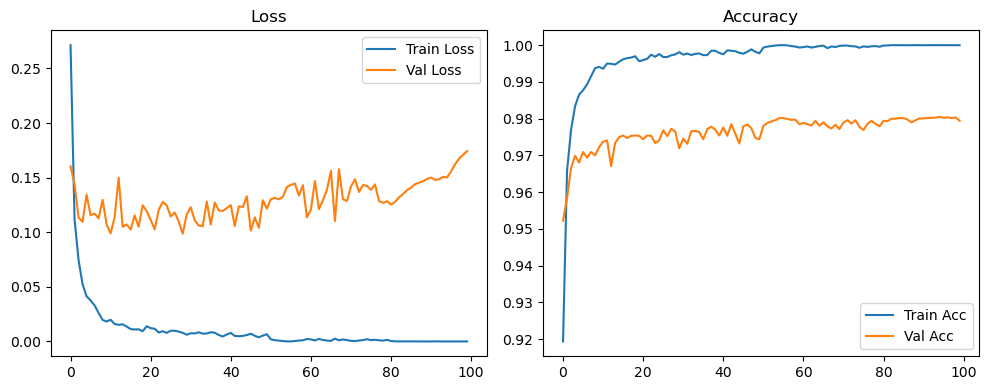

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2817, Acc: 0.9153 | Val Loss: 0.1622, Acc: 0.9525


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9607 | Val Loss: 0.1344, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0916, Acc: 0.9714 | Val Loss: 0.1206, Acc: 0.9655


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.1126, Acc: 0.9677


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9806 | Val Loss: 0.1128, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.1054, Acc: 0.9730


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9848 | Val Loss: 0.0963, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0916, Acc: 0.9747


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9903 | Val Loss: 0.1053, Acc: 0.9751


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1052, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1090, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.0931, Acc: 0.9754


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1020, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0944, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1070, Acc: 0.9768


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.0960, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0950, Acc: 0.9764


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0937, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0980, Acc: 0.9769


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0954, Acc: 0.9780


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1004, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0913, Acc: 0.9775


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1078, Acc: 0.9774


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0963, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1110, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0942, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1136, Acc: 0.9767


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1029, Acc: 0.9785


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0808, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1068, Acc: 0.9779


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1041, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0944, Acc: 0.9782


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1189, Acc: 0.9781


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1068, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1264, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0942, Acc: 0.9757


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0934, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1061, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0965, Acc: 0.9777


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1264, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1076, Acc: 0.9793


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1017, Acc: 0.9796


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1009, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0898, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1012, Acc: 0.9777


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1130, Acc: 0.9784


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1219, Acc: 0.9762


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1076, Acc: 0.9770


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1023, Acc: 0.9785


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1349, Acc: 0.9786


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1122, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1179, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1302, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1060, Acc: 0.9805


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1072, Acc: 0.9815


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1204, Acc: 0.9797


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1392, Acc: 0.9806


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1068, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1067, Acc: 0.9802


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1250, Acc: 0.9816


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1209, Acc: 0.9814


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1064, Acc: 0.9798


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0980, Acc: 0.9812


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1077, Acc: 0.9808


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1359, Acc: 0.9800


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1153, Acc: 0.9805


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1243, Acc: 0.9812


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1158, Acc: 0.9806


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1160, Acc: 0.9812


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1194, Acc: 0.9808


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1065, Acc: 0.9815


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1487, Acc: 0.9805


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1114, Acc: 0.9788


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1120, Acc: 0.9799


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1111, Acc: 0.9811


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1126, Acc: 0.9807


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1097, Acc: 0.9804


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1183, Acc: 0.9803


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1167, Acc: 0.9799


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1244, Acc: 0.9813


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1168, Acc: 0.9816


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1293, Acc: 0.9818


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1369, Acc: 0.9824


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1357, Acc: 0.9817


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1385, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1413, Acc: 0.9820


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1491, Acc: 0.9819


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1487, Acc: 0.9823


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1472, Acc: 0.9826


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1520, Acc: 0.9813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1490, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1536, Acc: 0.9811


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1384, Acc: 0.9813


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1401, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1454, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1485, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1377, Acc: 0.9818


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1400, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1379, Acc: 0.9823


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1344, Acc: 0.9822


Final Test Loss: 0.1228 Accuracy: 0.9841


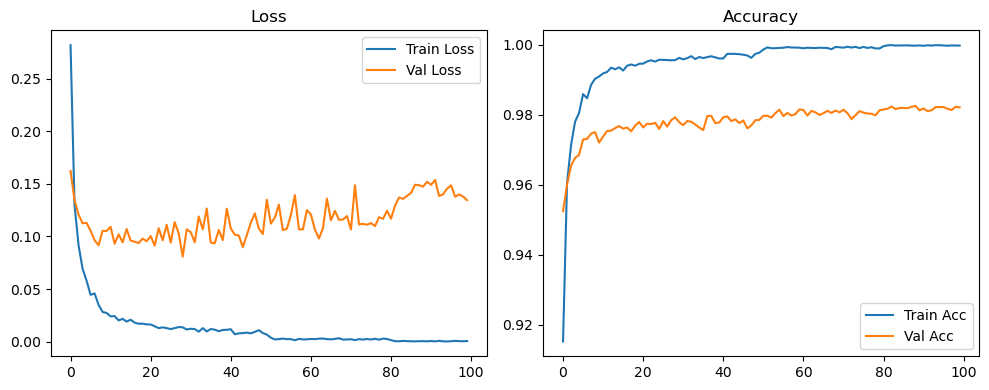

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3346, Acc: 0.9004 | Val Loss: 0.1802, Acc: 0.9484


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1830, Acc: 0.9454 | Val Loss: 0.1220, Acc: 0.9633


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1474, Acc: 0.9552 | Val Loss: 0.1163, Acc: 0.9653


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9642 | Val Loss: 0.1050, Acc: 0.9686


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9708 | Val Loss: 0.0881, Acc: 0.9733


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9738 | Val Loss: 0.0989, Acc: 0.9705


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9755 | Val Loss: 0.0907, Acc: 0.9743


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9782 | Val Loss: 0.0887, Acc: 0.9741


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9788 | Val Loss: 0.0881, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9807 | Val Loss: 0.0870, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9817 | Val Loss: 0.0826, Acc: 0.9765


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9821 | Val Loss: 0.0911, Acc: 0.9753


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.0869, Acc: 0.9771


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9837 | Val Loss: 0.0930, Acc: 0.9776


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9839 | Val Loss: 0.0786, Acc: 0.9780


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9846 | Val Loss: 0.0820, Acc: 0.9778


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.0941, Acc: 0.9749


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.0838, Acc: 0.9768


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0842, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9876 | Val Loss: 0.0861, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0884, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9874 | Val Loss: 0.0916, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0918, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.0898, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0879, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9890 | Val Loss: 0.0850, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0967, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0910, Acc: 0.9786


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0909, Acc: 0.9783


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.0838, Acc: 0.9768


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0869, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0868, Acc: 0.9780


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.0935, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0907, Acc: 0.9776


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.0886, Acc: 0.9791


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0818, Acc: 0.9790


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0981, Acc: 0.9782


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.0888, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.0972, Acc: 0.9802


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.0777, Acc: 0.9799


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0921, Acc: 0.9789


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0779, Acc: 0.9801


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0972, Acc: 0.9786


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.0840, Acc: 0.9797


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0834, Acc: 0.9788


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0834, Acc: 0.9795


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0768, Acc: 0.9797


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0790, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0817, Acc: 0.9811


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0801, Acc: 0.9811


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9936 | Val Loss: 0.0749, Acc: 0.9816


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.0863, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0855, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0854, Acc: 0.9817


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0922, Acc: 0.9826


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.0840, Acc: 0.9820


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0795, Acc: 0.9823


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0917, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0837, Acc: 0.9815


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0840, Acc: 0.9831


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0945, Acc: 0.9822


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.0779, Acc: 0.9816


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.0970, Acc: 0.9822


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.0877, Acc: 0.9815


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0971, Acc: 0.9809


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.0875, Acc: 0.9810


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0976, Acc: 0.9805


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0990, Acc: 0.9815


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0833, Acc: 0.9817


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0997, Acc: 0.9817


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0974, Acc: 0.9819


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0851, Acc: 0.9815


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0920, Acc: 0.9812


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1057, Acc: 0.9813


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0955, Acc: 0.9804


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0836, Acc: 0.9808


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9971 | Val Loss: 0.0983, Acc: 0.9814


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1026, Acc: 0.9817


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0978, Acc: 0.9819


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0917, Acc: 0.9814


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.0959, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0910, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0947, Acc: 0.9826


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0951, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0975, Acc: 0.9828


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9981 | Val Loss: 0.0987, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0970, Acc: 0.9821


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0946, Acc: 0.9825


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0990, Acc: 0.9823


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1018, Acc: 0.9824


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0950, Acc: 0.9822


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1003, Acc: 0.9822


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0928, Acc: 0.9832


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1013, Acc: 0.9827


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9985 | Val Loss: 0.0999, Acc: 0.9819


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0972, Acc: 0.9823


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0957, Acc: 0.9830


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0945, Acc: 0.9821


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0919, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1065, Acc: 0.9824


Final Test Loss: 0.0955 Accuracy: 0.9841


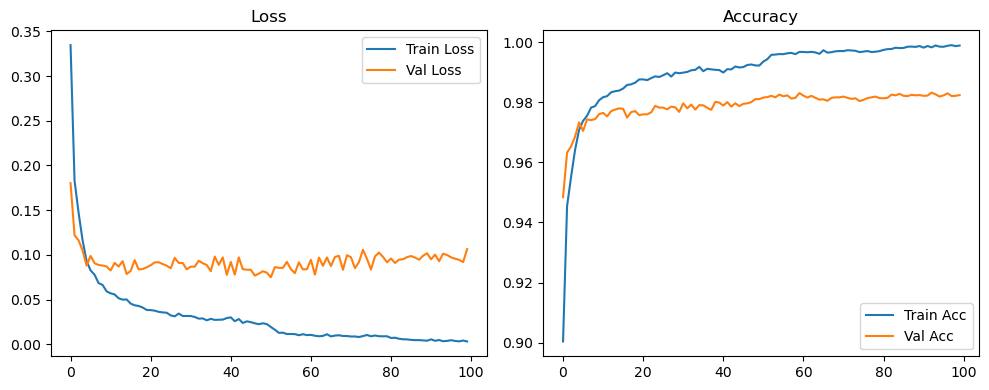

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2713, Acc: 0.9194 | Val Loss: 0.1604, Acc: 0.9523


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1114, Acc: 0.9658 | Val Loss: 0.1441, Acc: 0.9585


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0746, Acc: 0.9770 | Val Loss: 0.1134, Acc: 0.9666


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0524, Acc: 0.9834 | Val Loss: 0.1096, Acc: 0.9699


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9865 | Val Loss: 0.1344, Acc: 0.9681


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9877 | Val Loss: 0.1156, Acc: 0.9709


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9893 | Val Loss: 0.1170, Acc: 0.9694


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9915 | Val Loss: 0.1127, Acc: 0.9709


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.1297, Acc: 0.9700


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1071, Acc: 0.9722


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9936 | Val Loss: 0.0989, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.1137, Acc: 0.9741


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.1500, Acc: 0.9671


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.1050, Acc: 0.9734


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1072, Acc: 0.9750


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1025, Acc: 0.9754


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1153, Acc: 0.9748


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1050, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1247, Acc: 0.9754


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.1195, Acc: 0.9753


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1113, Acc: 0.9744


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1026, Acc: 0.9754


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1205, Acc: 0.9753


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1277, Acc: 0.9733


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1246, Acc: 0.9741


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1144, Acc: 0.9768


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1180, Acc: 0.9752


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1100, Acc: 0.9772


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0986, Acc: 0.9765


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1163, Acc: 0.9719


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1229, Acc: 0.9746


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1110, Acc: 0.9732


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1061, Acc: 0.9766


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1055, Acc: 0.9767


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1281, Acc: 0.9763


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1070, Acc: 0.9744


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1272, Acc: 0.9772


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1199, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1196, Acc: 0.9770


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1221, Acc: 0.9754


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1248, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1057, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1237, Acc: 0.9785


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1231, Acc: 0.9759


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1329, Acc: 0.9732


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1015, Acc: 0.9779


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1136, Acc: 0.9784


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1041, Acc: 0.9774


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1293, Acc: 0.9748


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1216, Acc: 0.9744


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1213, Acc: 0.9784


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1305, Acc: 0.9784


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1350, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1381, Acc: 0.9794


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1425, Acc: 0.9791


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1444, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1460, Acc: 0.9799


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1502, Acc: 0.9795


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1557, Acc: 0.9794


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1543, Acc: 0.9799


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1609, Acc: 0.9796


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1677, Acc: 0.9794


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1630, Acc: 0.9799


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1625, Acc: 0.9800


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1605, Acc: 0.9796


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1594, Acc: 0.9801


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1673, Acc: 0.9803


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1636, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1705, Acc: 0.9805


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1780, Acc: 0.9798


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1582, Acc: 0.9803


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1500, Acc: 0.9802


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1575, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1597, Acc: 0.9798


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1583, Acc: 0.9799


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1605, Acc: 0.9797


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1374, Acc: 0.9786


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1445, Acc: 0.9793


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1513, Acc: 0.9799


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1627, Acc: 0.9798


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1655, Acc: 0.9802


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1670, Acc: 0.9799


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1697, Acc: 0.9801


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1706, Acc: 0.9804


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1704, Acc: 0.9800


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1606, Acc: 0.9801


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1639, Acc: 0.9795


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1631, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1615, Acc: 0.9810


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1678, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1566, Acc: 0.9796


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1569, Acc: 0.9797


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1596, Acc: 0.9799


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1602, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1657, Acc: 0.9799


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1689, Acc: 0.9806


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1705, Acc: 0.9801


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1726, Acc: 0.9802


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1733, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1816, Acc: 0.9803


Final Test Loss: 0.1569 Accuracy: 0.9822


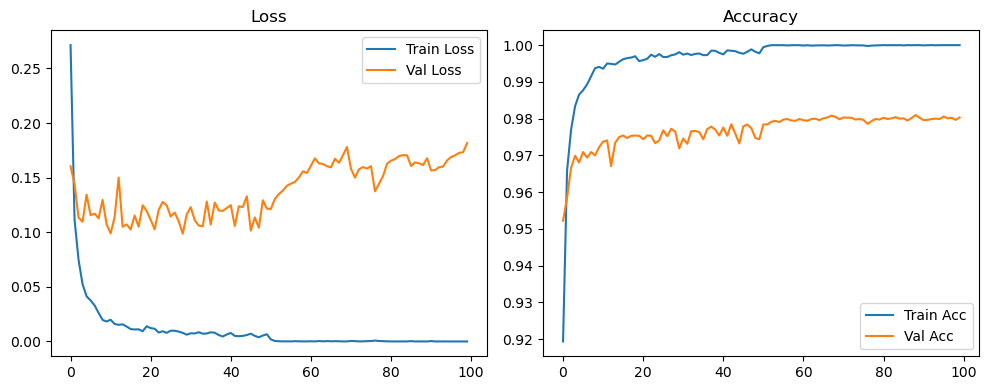

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2817, Acc: 0.9153 | Val Loss: 0.1622, Acc: 0.9525


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1296, Acc: 0.9607 | Val Loss: 0.1344, Acc: 0.9602


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0916, Acc: 0.9714 | Val Loss: 0.1206, Acc: 0.9655


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0694, Acc: 0.9781 | Val Loss: 0.1126, Acc: 0.9677


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9806 | Val Loss: 0.1128, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9860 | Val Loss: 0.1054, Acc: 0.9730


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0459, Acc: 0.9848 | Val Loss: 0.0963, Acc: 0.9732


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0349, Acc: 0.9886 | Val Loss: 0.0916, Acc: 0.9747


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9903 | Val Loss: 0.1053, Acc: 0.9751


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.1052, Acc: 0.9721


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9919 | Val Loss: 0.1090, Acc: 0.9738


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9923 | Val Loss: 0.0931, Acc: 0.9754


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1020, Acc: 0.9755


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0944, Acc: 0.9762


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1070, Acc: 0.9768


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9927 | Val Loss: 0.0960, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9941 | Val Loss: 0.0950, Acc: 0.9764


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0937, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9941 | Val Loss: 0.0980, Acc: 0.9769


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0954, Acc: 0.9780


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1004, Acc: 0.9764


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0913, Acc: 0.9775


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1078, Acc: 0.9774


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0963, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1110, Acc: 0.9760


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0942, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1136, Acc: 0.9767


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9956 | Val Loss: 0.1029, Acc: 0.9785


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0808, Acc: 0.9793


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.1068, Acc: 0.9779


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1041, Acc: 0.9771


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0944, Acc: 0.9782


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1189, Acc: 0.9781


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1068, Acc: 0.9772


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1264, Acc: 0.9764


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0942, Acc: 0.9757


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0934, Acc: 0.9797


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1061, Acc: 0.9798


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0965, Acc: 0.9777


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1264, Acc: 0.9778


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1076, Acc: 0.9793


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1017, Acc: 0.9796


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1009, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0898, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1012, Acc: 0.9777


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1130, Acc: 0.9784


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1219, Acc: 0.9762


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1076, Acc: 0.9770


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1023, Acc: 0.9785


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1349, Acc: 0.9786


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1188, Acc: 0.9802


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1336, Acc: 0.9796


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1320, Acc: 0.9805


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1282, Acc: 0.9804


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1264, Acc: 0.9804


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1224, Acc: 0.9806


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1218, Acc: 0.9815


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1292, Acc: 0.9814


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1261, Acc: 0.9807


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1330, Acc: 0.9812


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1184, Acc: 0.9807


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1183, Acc: 0.9817


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1298, Acc: 0.9812


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1223, Acc: 0.9811


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1247, Acc: 0.9814


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1363, Acc: 0.9806


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1314, Acc: 0.9809


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1263, Acc: 0.9816


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1151, Acc: 0.9816


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1193, Acc: 0.9816


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1098, Acc: 0.9828


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1302, Acc: 0.9819


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1250, Acc: 0.9821


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1161, Acc: 0.9818


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1295, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1299, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1264, Acc: 0.9808


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1367, Acc: 0.9808


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1323, Acc: 0.9812


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1245, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1292, Acc: 0.9818


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1316, Acc: 0.9828


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1355, Acc: 0.9822


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1379, Acc: 0.9823


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1359, Acc: 0.9825


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1400, Acc: 0.9828


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1424, Acc: 0.9825


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1339, Acc: 0.9830


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1282, Acc: 0.9824


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1268, Acc: 0.9821


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1281, Acc: 0.9823


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1210, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1266, Acc: 0.9826


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1374, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1435, Acc: 0.9823


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1438, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1372, Acc: 0.9823


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1314, Acc: 0.9823


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1332, Acc: 0.9827


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1431, Acc: 0.9823


Final Test Loss: 0.1299 Accuracy: 0.9829


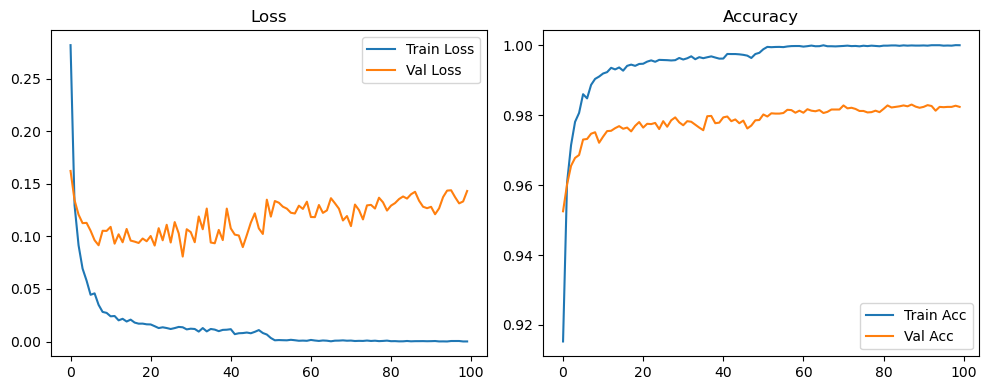

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3346, Acc: 0.9004 | Val Loss: 0.1802, Acc: 0.9484


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1830, Acc: 0.9454 | Val Loss: 0.1220, Acc: 0.9633


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1474, Acc: 0.9552 | Val Loss: 0.1163, Acc: 0.9653


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1164, Acc: 0.9642 | Val Loss: 0.1050, Acc: 0.9686


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0931, Acc: 0.9708 | Val Loss: 0.0881, Acc: 0.9733


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0826, Acc: 0.9738 | Val Loss: 0.0989, Acc: 0.9705


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0778, Acc: 0.9755 | Val Loss: 0.0907, Acc: 0.9743


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0685, Acc: 0.9782 | Val Loss: 0.0887, Acc: 0.9741


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9788 | Val Loss: 0.0881, Acc: 0.9744


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0592, Acc: 0.9807 | Val Loss: 0.0870, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0570, Acc: 0.9817 | Val Loss: 0.0826, Acc: 0.9765


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0557, Acc: 0.9821 | Val Loss: 0.0911, Acc: 0.9753


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0515, Acc: 0.9834 | Val Loss: 0.0869, Acc: 0.9771


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9837 | Val Loss: 0.0930, Acc: 0.9776


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0501, Acc: 0.9839 | Val Loss: 0.0786, Acc: 0.9780


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9846 | Val Loss: 0.0820, Acc: 0.9778


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.0941, Acc: 0.9749


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9860 | Val Loss: 0.0838, Acc: 0.9768


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0411, Acc: 0.9865 | Val Loss: 0.0842, Acc: 0.9771


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0384, Acc: 0.9876 | Val Loss: 0.0861, Acc: 0.9758


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0382, Acc: 0.9876 | Val Loss: 0.0884, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9874 | Val Loss: 0.0916, Acc: 0.9760


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0363, Acc: 0.9881 | Val Loss: 0.0918, Acc: 0.9767


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0356, Acc: 0.9887 | Val Loss: 0.0898, Acc: 0.9788


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9884 | Val Loss: 0.0879, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0323, Acc: 0.9890 | Val Loss: 0.0850, Acc: 0.9782


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9897 | Val Loss: 0.0967, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.0910, Acc: 0.9786


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0909, Acc: 0.9783


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9897 | Val Loss: 0.0838, Acc: 0.9768


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9899 | Val Loss: 0.0869, Acc: 0.9797


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9901 | Val Loss: 0.0868, Acc: 0.9780


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9907 | Val Loss: 0.0935, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0907, Acc: 0.9776


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9918 | Val Loss: 0.0886, Acc: 0.9791


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.0818, Acc: 0.9790


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0981, Acc: 0.9782


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.0888, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0276, Acc: 0.9908 | Val Loss: 0.0972, Acc: 0.9802


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9908 | Val Loss: 0.0777, Acc: 0.9799


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0921, Acc: 0.9789


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.0779, Acc: 0.9801


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9910 | Val Loss: 0.0972, Acc: 0.9786


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9919 | Val Loss: 0.0840, Acc: 0.9797


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0834, Acc: 0.9788


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0834, Acc: 0.9795


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0768, Acc: 0.9797


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0790, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0817, Acc: 0.9811


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0801, Acc: 0.9811


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0779, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9946 | Val Loss: 0.0771, Acc: 0.9820


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0920, Acc: 0.9825


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0895, Acc: 0.9819


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.0927, Acc: 0.9822


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0889, Acc: 0.9826


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0880, Acc: 0.9827


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0974, Acc: 0.9828


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0799, Acc: 0.9826


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.0916, Acc: 0.9832


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0970, Acc: 0.9829


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0899, Acc: 0.9831


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0845, Acc: 0.9828


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1005, Acc: 0.9823


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0869, Acc: 0.9826


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0897, Acc: 0.9828


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0997, Acc: 0.9823


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1002, Acc: 0.9818


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0867, Acc: 0.9827


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0833, Acc: 0.9823


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0939, Acc: 0.9820


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0963, Acc: 0.9832


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0963, Acc: 0.9824


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0966, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0834, Acc: 0.9818


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0990, Acc: 0.9818


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0976, Acc: 0.9818


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1068, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1137, Acc: 0.9821


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0964, Acc: 0.9826


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1021, Acc: 0.9823


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1023, Acc: 0.9822


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1057, Acc: 0.9826


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1095, Acc: 0.9824


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0939, Acc: 0.9828


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1089, Acc: 0.9827


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1065, Acc: 0.9821


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0986, Acc: 0.9828


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0990, Acc: 0.9823


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0955, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0899, Acc: 0.9831


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0949, Acc: 0.9829


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0965, Acc: 0.9829


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0980, Acc: 0.9831


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1031, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1019, Acc: 0.9826


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0919, Acc: 0.9832


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1026, Acc: 0.9839


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.0967, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1041, Acc: 0.9831


Final Test Loss: 0.0984 Accuracy: 0.9838


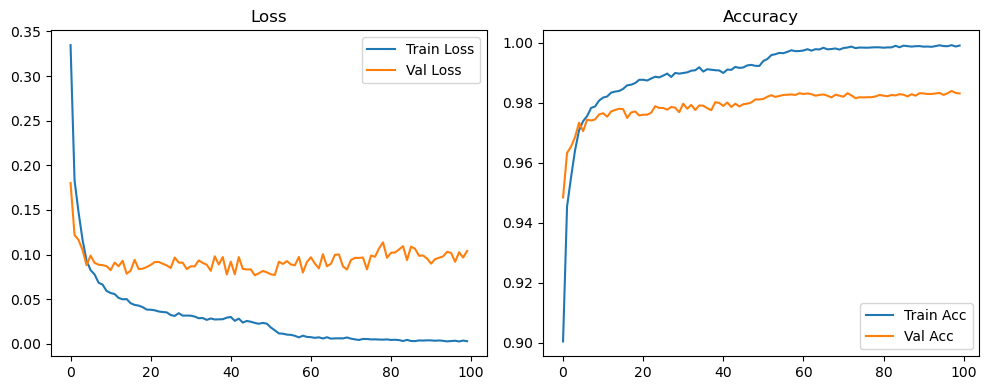

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2298, Acc: 0.9296 | Val Loss: 0.1619, Acc: 0.9523


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1039, Acc: 0.9679 | Val Loss: 0.1255, Acc: 0.9648


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9775 | Val Loss: 0.1249, Acc: 0.9671


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9829 | Val Loss: 0.1076, Acc: 0.9706


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.1186, Acc: 0.9699


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9887 | Val Loss: 0.1179, Acc: 0.9706


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.1324, Acc: 0.9679


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.1134, Acc: 0.9728


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1157, Acc: 0.9746


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1275, Acc: 0.9728


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.1245, Acc: 0.9742


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1242, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1145, Acc: 0.9744


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1243, Acc: 0.9726


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1362, Acc: 0.9724


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1184, Acc: 0.9762


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.1208, Acc: 0.9752


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1289, Acc: 0.9740


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1369, Acc: 0.9727


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1263, Acc: 0.9742


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1426, Acc: 0.9750


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1307, Acc: 0.9749


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1272, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1051, Acc: 0.9779


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1129, Acc: 0.9742


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0960, Acc: 0.9792


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1020, Acc: 0.9779


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1095, Acc: 0.9761


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1271, Acc: 0.9757


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1010, Acc: 0.9781


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1138, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1141, Acc: 0.9782


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1168, Acc: 0.9766


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1105, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1350, Acc: 0.9757


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1022, Acc: 0.9772


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1042, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1060, Acc: 0.9778


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1073, Acc: 0.9781


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1016, Acc: 0.9787


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1196, Acc: 0.9768


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1100, Acc: 0.9785


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1101, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1057, Acc: 0.9795


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0977, Acc: 0.9769


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1133, Acc: 0.9779


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0964, Acc: 0.9796


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1126, Acc: 0.9778


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1167, Acc: 0.9768


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.0904, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1203, Acc: 0.9769


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1147, Acc: 0.9784


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1134, Acc: 0.9780


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1026, Acc: 0.9780


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9983 | Val Loss: 0.1113, Acc: 0.9759


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1272, Acc: 0.9787


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1152, Acc: 0.9777


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1003, Acc: 0.9797


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1301, Acc: 0.9782


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1082, Acc: 0.9783


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1034, Acc: 0.9767


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1246, Acc: 0.9780


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1029, Acc: 0.9789


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1094, Acc: 0.9794


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1048, Acc: 0.9788


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1128, Acc: 0.9798


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0926, Acc: 0.9773


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1153, Acc: 0.9758


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1317, Acc: 0.9744


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0992, Acc: 0.9789


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1031, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1110, Acc: 0.9795


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1256, Acc: 0.9779


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1092, Acc: 0.9785


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1136, Acc: 0.9788


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1324, Acc: 0.9768


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1380, Acc: 0.9772


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1354, Acc: 0.9771


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1024, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1029, Acc: 0.9778


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1214, Acc: 0.9784


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1081, Acc: 0.9791


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1202, Acc: 0.9784


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1021, Acc: 0.9778


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1104, Acc: 0.9787


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1229, Acc: 0.9787


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1141, Acc: 0.9792


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1165, Acc: 0.9794


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1400, Acc: 0.9796


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1154, Acc: 0.9788


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9998 | Val Loss: 0.1089, Acc: 0.9798


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1220, Acc: 0.9787


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1149, Acc: 0.9802


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0961, Acc: 0.9784


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1191, Acc: 0.9773


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1246, Acc: 0.9787


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1192, Acc: 0.9792


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1145, Acc: 0.9812


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1013, Acc: 0.9799


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0811, Acc: 0.9796


Final Test Loss: 0.0810 Accuracy: 0.9801


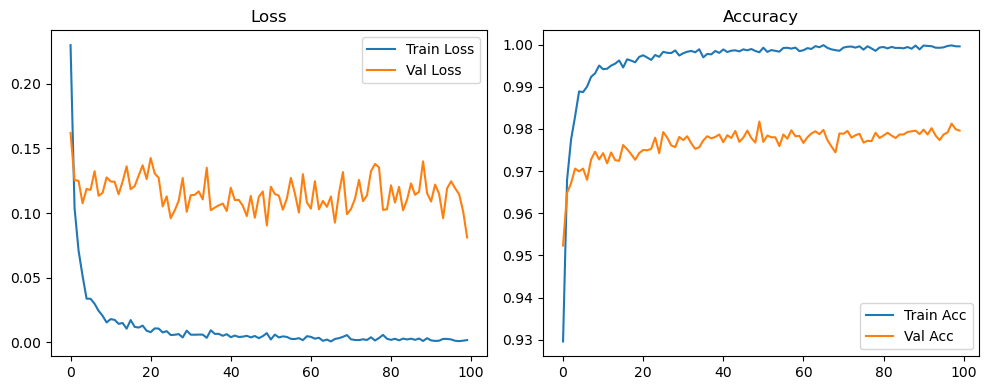

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2461, Acc: 0.9254 | Val Loss: 0.1633, Acc: 0.9526


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1231, Acc: 0.9618 | Val Loss: 0.1301, Acc: 0.9615


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9727 | Val Loss: 0.1220, Acc: 0.9656


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9790 | Val Loss: 0.1211, Acc: 0.9662


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9831 | Val Loss: 0.1058, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9850 | Val Loss: 0.1196, Acc: 0.9693


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9877 | Val Loss: 0.1093, Acc: 0.9720


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.1086, Acc: 0.9729


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.1046, Acc: 0.9752


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.1108, Acc: 0.9726


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.1063, Acc: 0.9744


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.1103, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.1135, Acc: 0.9752


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1227, Acc: 0.9742


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1089, Acc: 0.9757


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1076, Acc: 0.9764


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1132, Acc: 0.9762


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1094, Acc: 0.9773


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.1063, Acc: 0.9760


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0999, Acc: 0.9783


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1052, Acc: 0.9766


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0980, Acc: 0.9787


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0949, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0930, Acc: 0.9793


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1119, Acc: 0.9775


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0959, Acc: 0.9781


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0990, Acc: 0.9793


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1095, Acc: 0.9758


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0980, Acc: 0.9768


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1149, Acc: 0.9782


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1181, Acc: 0.9763


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0932, Acc: 0.9789


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0891, Acc: 0.9794


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1030, Acc: 0.9778


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1118, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1180, Acc: 0.9762


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1133, Acc: 0.9786


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1046, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1053, Acc: 0.9785


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1002, Acc: 0.9786


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1066, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1094, Acc: 0.9775


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1155, Acc: 0.9786


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1019, Acc: 0.9788


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1040, Acc: 0.9783


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0919, Acc: 0.9803


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1120, Acc: 0.9788


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1101, Acc: 0.9781


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0949, Acc: 0.9787


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1094, Acc: 0.9792


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0882, Acc: 0.9806


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0961, Acc: 0.9788


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1059, Acc: 0.9783


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1004, Acc: 0.9794


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1031, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1076, Acc: 0.9784


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1066, Acc: 0.9782


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1075, Acc: 0.9784


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1033, Acc: 0.9792


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1098, Acc: 0.9788


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0962, Acc: 0.9786


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0989, Acc: 0.9785


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1154, Acc: 0.9778


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0952, Acc: 0.9794


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1161, Acc: 0.9786


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1234, Acc: 0.9793


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1149, Acc: 0.9791


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0937, Acc: 0.9808


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1042, Acc: 0.9787


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1124, Acc: 0.9796


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0963, Acc: 0.9793


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1249, Acc: 0.9802


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0917, Acc: 0.9808


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1160, Acc: 0.9793


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1002, Acc: 0.9788


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1128, Acc: 0.9803


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1043, Acc: 0.9811


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1087, Acc: 0.9786


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1104, Acc: 0.9793


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1096, Acc: 0.9784


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1175, Acc: 0.9797


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0902, Acc: 0.9782


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1021, Acc: 0.9803


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1181, Acc: 0.9793


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1223, Acc: 0.9798


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1095, Acc: 0.9779


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1123, Acc: 0.9795


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1298, Acc: 0.9753


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1079, Acc: 0.9800


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1126, Acc: 0.9796


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1166, Acc: 0.9802


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1053, Acc: 0.9788


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1184, Acc: 0.9802


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1220, Acc: 0.9816


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1277, Acc: 0.9788


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1265, Acc: 0.9792


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1320, Acc: 0.9798


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1158, Acc: 0.9787


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1026, Acc: 0.9791


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1130, Acc: 0.9798


Final Test Loss: 0.0971 Accuracy: 0.9816


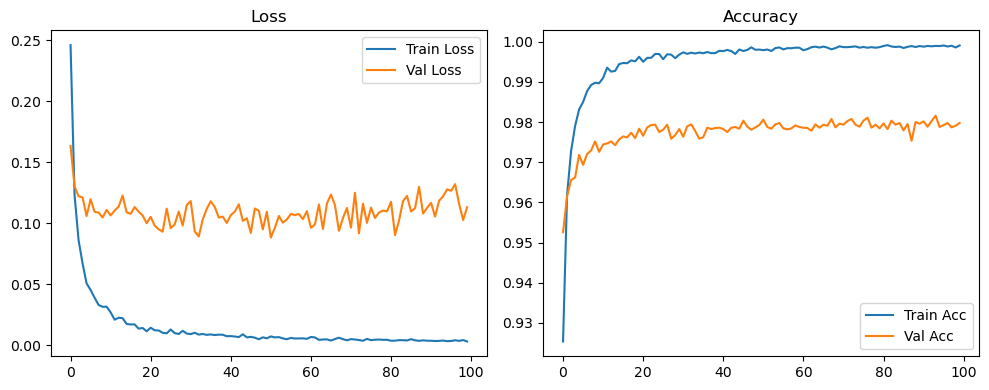

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3068, Acc: 0.9048 | Val Loss: 0.1536, Acc: 0.9557


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1715, Acc: 0.9485 | Val Loss: 0.1247, Acc: 0.9609


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1400, Acc: 0.9581 | Val Loss: 0.1109, Acc: 0.9677


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1135, Acc: 0.9652 | Val Loss: 0.1020, Acc: 0.9704


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0985, Acc: 0.9694 | Val Loss: 0.0951, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0852, Acc: 0.9724 | Val Loss: 0.0944, Acc: 0.9738


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9754 | Val Loss: 0.0874, Acc: 0.9749


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0696, Acc: 0.9781 | Val Loss: 0.0934, Acc: 0.9744


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9794 | Val Loss: 0.0848, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9812 | Val Loss: 0.0875, Acc: 0.9766


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9816 | Val Loss: 0.0834, Acc: 0.9766


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9840 | Val Loss: 0.0820, Acc: 0.9782


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9854 | Val Loss: 0.0854, Acc: 0.9769


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9855 | Val Loss: 0.0843, Acc: 0.9779


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9866 | Val Loss: 0.0859, Acc: 0.9769


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.0783, Acc: 0.9785


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 0.0933, Acc: 0.9755


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0811, Acc: 0.9783


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.0832, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0834, Acc: 0.9783


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9889 | Val Loss: 0.0856, Acc: 0.9788


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9900 | Val Loss: 0.0782, Acc: 0.9787


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0812, Acc: 0.9789


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0848, Acc: 0.9779


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.0866, Acc: 0.9778


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.0841, Acc: 0.9790


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.0873, Acc: 0.9798


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.0882, Acc: 0.9791


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9916 | Val Loss: 0.0867, Acc: 0.9786


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0930, Acc: 0.9797


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.0824, Acc: 0.9806


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0797, Acc: 0.9783


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0858, Acc: 0.9812


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0850, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0881, Acc: 0.9792


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0873, Acc: 0.9798


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0906, Acc: 0.9805


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0784, Acc: 0.9811


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0728, Acc: 0.9803


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0791, Acc: 0.9803


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0877, Acc: 0.9797


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0853, Acc: 0.9812


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0845, Acc: 0.9806


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0891, Acc: 0.9810


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.0873, Acc: 0.9794


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0897, Acc: 0.9801


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0915, Acc: 0.9783


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0836, Acc: 0.9801


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0846, Acc: 0.9804


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0849, Acc: 0.9808


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.0769, Acc: 0.9807


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0830, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0824, Acc: 0.9811


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0844, Acc: 0.9824


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.0844, Acc: 0.9818


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.0855, Acc: 0.9822


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0863, Acc: 0.9805


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.0892, Acc: 0.9810


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0902, Acc: 0.9806


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0867, Acc: 0.9808


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0850, Acc: 0.9814


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0914, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9949 | Val Loss: 0.0779, Acc: 0.9813


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.0989, Acc: 0.9799


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0847, Acc: 0.9813


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0880, Acc: 0.9820


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9953 | Val Loss: 0.0862, Acc: 0.9802


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0833, Acc: 0.9801


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0843, Acc: 0.9803


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0916, Acc: 0.9797


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0964, Acc: 0.9802


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0942, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9953 | Val Loss: 0.0894, Acc: 0.9810


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0912, Acc: 0.9803


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0894, Acc: 0.9812


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0873, Acc: 0.9810


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0812, Acc: 0.9818


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0936, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1035, Acc: 0.9802


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0950, Acc: 0.9802


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0895, Acc: 0.9818


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0921, Acc: 0.9814


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9962 | Val Loss: 0.0771, Acc: 0.9822


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0917, Acc: 0.9818


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0959, Acc: 0.9808


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0971, Acc: 0.9815


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0835, Acc: 0.9818


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0922, Acc: 0.9818


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.0780, Acc: 0.9817


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1040, Acc: 0.9804


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.0831, Acc: 0.9800


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0971, Acc: 0.9806


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.0822, Acc: 0.9812


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.0969, Acc: 0.9813


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0933, Acc: 0.9808


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0854, Acc: 0.9818


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1059, Acc: 0.9815


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0911, Acc: 0.9815


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.0944, Acc: 0.9821


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9961 | Val Loss: 0.0955, Acc: 0.9812


Final Test Loss: 0.0942 Accuracy: 0.9829


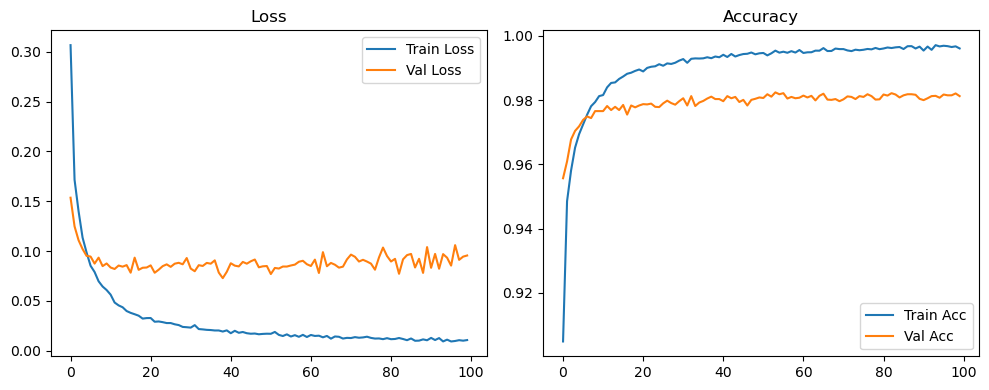

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2298, Acc: 0.9296 | Val Loss: 0.1619, Acc: 0.9523


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1039, Acc: 0.9679 | Val Loss: 0.1255, Acc: 0.9648


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9775 | Val Loss: 0.1249, Acc: 0.9671


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0514, Acc: 0.9829 | Val Loss: 0.1076, Acc: 0.9706


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9889 | Val Loss: 0.1186, Acc: 0.9699


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9887 | Val Loss: 0.1179, Acc: 0.9706


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0299, Acc: 0.9900 | Val Loss: 0.1324, Acc: 0.9679


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9923 | Val Loss: 0.1134, Acc: 0.9728


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1157, Acc: 0.9746


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1275, Acc: 0.9728


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.1245, Acc: 0.9742


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1242, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1145, Acc: 0.9744


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1243, Acc: 0.9726


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1362, Acc: 0.9724


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9946 | Val Loss: 0.1184, Acc: 0.9762


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9965 | Val Loss: 0.1208, Acc: 0.9752


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1289, Acc: 0.9740


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1369, Acc: 0.9727


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1263, Acc: 0.9742


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1426, Acc: 0.9750


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1307, Acc: 0.9749


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1272, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1051, Acc: 0.9779


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1129, Acc: 0.9742


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.0960, Acc: 0.9792


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1020, Acc: 0.9779


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1095, Acc: 0.9761


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1271, Acc: 0.9757


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1010, Acc: 0.9781


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1138, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1141, Acc: 0.9782


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.1168, Acc: 0.9766


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1105, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1350, Acc: 0.9757


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1022, Acc: 0.9772


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1042, Acc: 0.9782


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1060, Acc: 0.9778


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1073, Acc: 0.9781


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1016, Acc: 0.9787


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1196, Acc: 0.9768


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1100, Acc: 0.9785


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1101, Acc: 0.9778


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1057, Acc: 0.9795


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0977, Acc: 0.9769


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1133, Acc: 0.9779


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0964, Acc: 0.9796


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1126, Acc: 0.9778


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1167, Acc: 0.9768


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9982 | Val Loss: 0.0904, Acc: 0.9818


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0988, Acc: 0.9809


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9802


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1055, Acc: 0.9822


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1068, Acc: 0.9822


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1112, Acc: 0.9822


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1123, Acc: 0.9822


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1157, Acc: 0.9823


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1164, Acc: 0.9828


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1162, Acc: 0.9829


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1175, Acc: 0.9832


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1197, Acc: 0.9825


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1214, Acc: 0.9827


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1213, Acc: 0.9825


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1329, Acc: 0.9805


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1246, Acc: 0.9804


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1323, Acc: 0.9792


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1235, Acc: 0.9794


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1145, Acc: 0.9792


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1140, Acc: 0.9800


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1010, Acc: 0.9804


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1111, Acc: 0.9804


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1168, Acc: 0.9796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1183, Acc: 0.9807


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1197, Acc: 0.9808


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1218, Acc: 0.9812


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1221, Acc: 0.9816


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1216, Acc: 0.9814


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1275, Acc: 0.9795


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1222, Acc: 0.9782


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1246, Acc: 0.9795


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1171, Acc: 0.9808


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1213, Acc: 0.9815


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1254, Acc: 0.9814


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1275, Acc: 0.9814


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1248, Acc: 0.9812


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1266, Acc: 0.9816


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1312, Acc: 0.9816


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1304, Acc: 0.9811


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1326, Acc: 0.9814


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1309, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1321, Acc: 0.9813


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1302, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1318, Acc: 0.9824


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1347, Acc: 0.9822


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1387, Acc: 0.9816


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1382, Acc: 0.9813


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1405, Acc: 0.9819


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1419, Acc: 0.9825


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1409, Acc: 0.9826


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1491, Acc: 0.9813


Final Test Loss: 0.1412 Accuracy: 0.9814


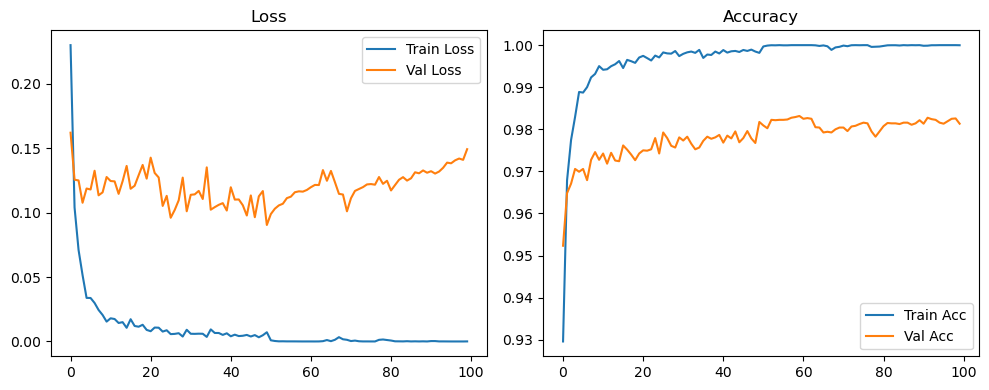

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2461, Acc: 0.9254 | Val Loss: 0.1633, Acc: 0.9526


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1231, Acc: 0.9618 | Val Loss: 0.1301, Acc: 0.9615


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0861, Acc: 0.9727 | Val Loss: 0.1220, Acc: 0.9656


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0669, Acc: 0.9790 | Val Loss: 0.1211, Acc: 0.9662


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0506, Acc: 0.9831 | Val Loss: 0.1058, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0452, Acc: 0.9850 | Val Loss: 0.1196, Acc: 0.9693


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9877 | Val Loss: 0.1093, Acc: 0.9720


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0329, Acc: 0.9892 | Val Loss: 0.1086, Acc: 0.9729


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.1046, Acc: 0.9752


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.1108, Acc: 0.9726


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9910 | Val Loss: 0.1063, Acc: 0.9744


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.1103, Acc: 0.9747


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9925 | Val Loss: 0.1135, Acc: 0.9752


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.1227, Acc: 0.9742


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.1089, Acc: 0.9757


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9947 | Val Loss: 0.1076, Acc: 0.9764


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1132, Acc: 0.9762


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1094, Acc: 0.9773


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9951 | Val Loss: 0.1063, Acc: 0.9760


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.0999, Acc: 0.9783


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9950 | Val Loss: 0.1052, Acc: 0.9766


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0980, Acc: 0.9787


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0949, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0930, Acc: 0.9793


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1119, Acc: 0.9775


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0959, Acc: 0.9781


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0990, Acc: 0.9793


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1095, Acc: 0.9758


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.0980, Acc: 0.9768


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1149, Acc: 0.9782


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1181, Acc: 0.9763


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0932, Acc: 0.9789


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0891, Acc: 0.9794


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1030, Acc: 0.9778


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1118, Acc: 0.9758


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1180, Acc: 0.9762


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1133, Acc: 0.9786


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1046, Acc: 0.9782


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1053, Acc: 0.9785


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1002, Acc: 0.9786


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1066, Acc: 0.9782


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1094, Acc: 0.9775


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.1155, Acc: 0.9786


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.1019, Acc: 0.9788


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1040, Acc: 0.9783


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.0919, Acc: 0.9803


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1120, Acc: 0.9788


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1101, Acc: 0.9781


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0949, Acc: 0.9787


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1094, Acc: 0.9792


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1009, Acc: 0.9803


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1122, Acc: 0.9799


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1160, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1236, Acc: 0.9793


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1169, Acc: 0.9802


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1169, Acc: 0.9806


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1144, Acc: 0.9807


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1088, Acc: 0.9805


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1200, Acc: 0.9806


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1114, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1036, Acc: 0.9808


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1133, Acc: 0.9811


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1187, Acc: 0.9811


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1231, Acc: 0.9806


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1169, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1142, Acc: 0.9808


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1146, Acc: 0.9808


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1210, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1247, Acc: 0.9798


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1102, Acc: 0.9818


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1114, Acc: 0.9826


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1091, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1104, Acc: 0.9816


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1215, Acc: 0.9812


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1312, Acc: 0.9814


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1317, Acc: 0.9812


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1132, Acc: 0.9803


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1300, Acc: 0.9808


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1271, Acc: 0.9814


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1159, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1193, Acc: 0.9815


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1171, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1159, Acc: 0.9819


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1218, Acc: 0.9809


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1233, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1237, Acc: 0.9812


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1253, Acc: 0.9822


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1275, Acc: 0.9814


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1278, Acc: 0.9816


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1308, Acc: 0.9816


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1347, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1311, Acc: 0.9821


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1314, Acc: 0.9823


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1294, Acc: 0.9824


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1268, Acc: 0.9837


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1301, Acc: 0.9825


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1245, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1216, Acc: 0.9824


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1182, Acc: 0.9817


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1232, Acc: 0.9826


Final Test Loss: 0.1082 Accuracy: 0.9837


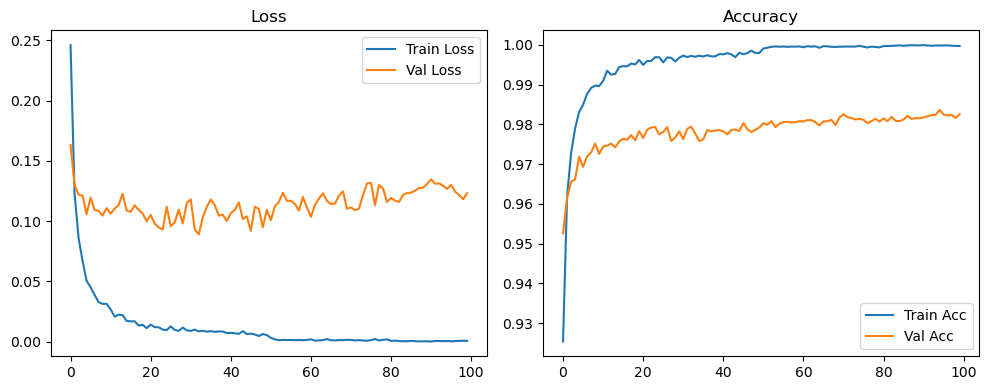

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3068, Acc: 0.9048 | Val Loss: 0.1536, Acc: 0.9557


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1715, Acc: 0.9485 | Val Loss: 0.1247, Acc: 0.9609


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1400, Acc: 0.9581 | Val Loss: 0.1109, Acc: 0.9677


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1135, Acc: 0.9652 | Val Loss: 0.1020, Acc: 0.9704


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0985, Acc: 0.9694 | Val Loss: 0.0951, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0852, Acc: 0.9724 | Val Loss: 0.0944, Acc: 0.9738


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0789, Acc: 0.9754 | Val Loss: 0.0874, Acc: 0.9749


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0696, Acc: 0.9781 | Val Loss: 0.0934, Acc: 0.9744


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0644, Acc: 0.9794 | Val Loss: 0.0848, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0608, Acc: 0.9812 | Val Loss: 0.0875, Acc: 0.9766


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9816 | Val Loss: 0.0834, Acc: 0.9766


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0483, Acc: 0.9840 | Val Loss: 0.0820, Acc: 0.9782


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0454, Acc: 0.9854 | Val Loss: 0.0854, Acc: 0.9769


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9855 | Val Loss: 0.0843, Acc: 0.9779


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0397, Acc: 0.9866 | Val Loss: 0.0859, Acc: 0.9769


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0379, Acc: 0.9874 | Val Loss: 0.0783, Acc: 0.9785


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 0.0933, Acc: 0.9755


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9885 | Val Loss: 0.0811, Acc: 0.9783


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.0832, Acc: 0.9778


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0326, Acc: 0.9895 | Val Loss: 0.0834, Acc: 0.9783


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9889 | Val Loss: 0.0856, Acc: 0.9788


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9900 | Val Loss: 0.0782, Acc: 0.9787


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0812, Acc: 0.9789


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.0848, Acc: 0.9779


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9912 | Val Loss: 0.0866, Acc: 0.9778


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9907 | Val Loss: 0.0841, Acc: 0.9790


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9914 | Val Loss: 0.0873, Acc: 0.9798


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9913 | Val Loss: 0.0882, Acc: 0.9791


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9916 | Val Loss: 0.0867, Acc: 0.9786


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0930, Acc: 0.9797


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9928 | Val Loss: 0.0824, Acc: 0.9806


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0797, Acc: 0.9783


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0858, Acc: 0.9812


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0850, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9930 | Val Loss: 0.0881, Acc: 0.9792


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0873, Acc: 0.9798


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9934 | Val Loss: 0.0906, Acc: 0.9805


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9931 | Val Loss: 0.0784, Acc: 0.9811


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.0728, Acc: 0.9803


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.0791, Acc: 0.9803


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0877, Acc: 0.9797


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0853, Acc: 0.9812


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0845, Acc: 0.9806


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.0891, Acc: 0.9810


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9940 | Val Loss: 0.0873, Acc: 0.9794


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0897, Acc: 0.9801


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0915, Acc: 0.9783


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.0836, Acc: 0.9801


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.0846, Acc: 0.9804


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0849, Acc: 0.9808


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0835, Acc: 0.9827


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.0801, Acc: 0.9819


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0897, Acc: 0.9818


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.0913, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0876, Acc: 0.9818


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0933, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0872, Acc: 0.9825


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9977 | Val Loss: 0.0947, Acc: 0.9819


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.0981, Acc: 0.9821


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0940, Acc: 0.9818


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1041, Acc: 0.9818


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.0952, Acc: 0.9821


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0908, Acc: 0.9813


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0927, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0990, Acc: 0.9825


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0917, Acc: 0.9828


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0927, Acc: 0.9819


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0884, Acc: 0.9835


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0902, Acc: 0.9827


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0942, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0944, Acc: 0.9829


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0878, Acc: 0.9827


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0943, Acc: 0.9830


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1008, Acc: 0.9831


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0881, Acc: 0.9828


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0951, Acc: 0.9829


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0890, Acc: 0.9827


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0941, Acc: 0.9844


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0979, Acc: 0.9822


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0869, Acc: 0.9838


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0940, Acc: 0.9834


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0955, Acc: 0.9840


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0945, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0999, Acc: 0.9837


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1001, Acc: 0.9842


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0927, Acc: 0.9836


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0957, Acc: 0.9836


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0994, Acc: 0.9839


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9990 | Val Loss: 0.1013, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0964, Acc: 0.9848


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0984, Acc: 0.9841


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1013, Acc: 0.9840


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1012, Acc: 0.9847


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0979, Acc: 0.9838


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1033, Acc: 0.9838


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0951, Acc: 0.9845


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0938, Acc: 0.9834


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0965, Acc: 0.9835


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1000, Acc: 0.9838


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0980, Acc: 0.9833


Final Test Loss: 0.0848 Accuracy: 0.9844


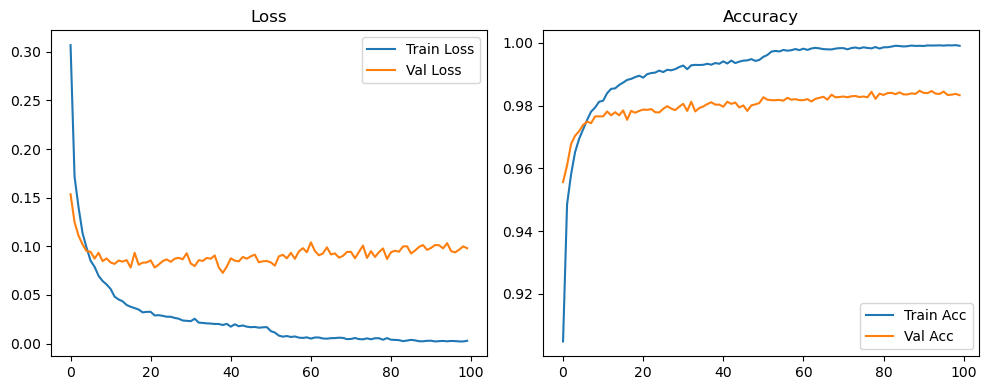

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2003, Acc: 0.9375 | Val Loss: 0.1304, Acc: 0.9588


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0898, Acc: 0.9707 | Val Loss: 0.1147, Acc: 0.9659


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9819 | Val Loss: 0.1105, Acc: 0.9686


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9866 | Val Loss: 0.1099, Acc: 0.9672


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9888 | Val Loss: 0.1084, Acc: 0.9707


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9906 | Val Loss: 0.1214, Acc: 0.9707


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1081, Acc: 0.9736


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.1195, Acc: 0.9712


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1215, Acc: 0.9728


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.1243, Acc: 0.9722


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1120, Acc: 0.9746


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1138, Acc: 0.9754


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9962 | Val Loss: 0.1241, Acc: 0.9746


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1307, Acc: 0.9720


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1512, Acc: 0.9688


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9968 | Val Loss: 0.1309, Acc: 0.9730


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.1375, Acc: 0.9702


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1115, Acc: 0.9762


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9968 | Val Loss: 0.1253, Acc: 0.9761


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1100, Acc: 0.9788


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1150, Acc: 0.9756


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1201, Acc: 0.9765


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1441, Acc: 0.9724


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9944 | Val Loss: 0.1264, Acc: 0.9752


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1246, Acc: 0.9749


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1050, Acc: 0.9782


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1154, Acc: 0.9787


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1229, Acc: 0.9782


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1257, Acc: 0.9774


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9975 | Val Loss: 0.1346, Acc: 0.9748


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9960 | Val Loss: 0.1248, Acc: 0.9761


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1123, Acc: 0.9786


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1234, Acc: 0.9789


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1265, Acc: 0.9772


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1250, Acc: 0.9783


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1322, Acc: 0.9762


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1276, Acc: 0.9772


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1258, Acc: 0.9785


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1303, Acc: 0.9785


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1346, Acc: 0.9759


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1377, Acc: 0.9768


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1339, Acc: 0.9777


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1262, Acc: 0.9784


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1293, Acc: 0.9769


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1220, Acc: 0.9785


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1489, Acc: 0.9775


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1393, Acc: 0.9758


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1406, Acc: 0.9762


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9986 | Val Loss: 0.1287, Acc: 0.9767


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1296, Acc: 0.9790


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1239, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1214, Acc: 0.9803


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1325, Acc: 0.9794


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1354, Acc: 0.9774


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1266, Acc: 0.9781


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1117, Acc: 0.9810


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1291, Acc: 0.9797


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1230, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1234, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1344, Acc: 0.9772


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.1265, Acc: 0.9790


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1339, Acc: 0.9779


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1379, Acc: 0.9787


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1559, Acc: 0.9744


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1195, Acc: 0.9779


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1191, Acc: 0.9799


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1239, Acc: 0.9786


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1208, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1176, Acc: 0.9813


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1193, Acc: 0.9812


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1289, Acc: 0.9781


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1649, Acc: 0.9737


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1290, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1315, Acc: 0.9793


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1302, Acc: 0.9786


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1328, Acc: 0.9787


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1427, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1559, Acc: 0.9770


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1326, Acc: 0.9786


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1394, Acc: 0.9786


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1481, Acc: 0.9767


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1373, Acc: 0.9788


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1295, Acc: 0.9800


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1322, Acc: 0.9795


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1285, Acc: 0.9797


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1289, Acc: 0.9807


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9992 | Val Loss: 0.1570, Acc: 0.9765


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1286, Acc: 0.9795


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1427, Acc: 0.9792


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1255, Acc: 0.9794


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1333, Acc: 0.9785


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1312, Acc: 0.9786


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1239, Acc: 0.9797


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1233, Acc: 0.9800


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.1224, Acc: 0.9808


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1254, Acc: 0.9803


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1302, Acc: 0.9798


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.1348, Acc: 0.9793


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1322, Acc: 0.9813


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1332, Acc: 0.9806


Final Test Loss: 0.1027 Accuracy: 0.9826


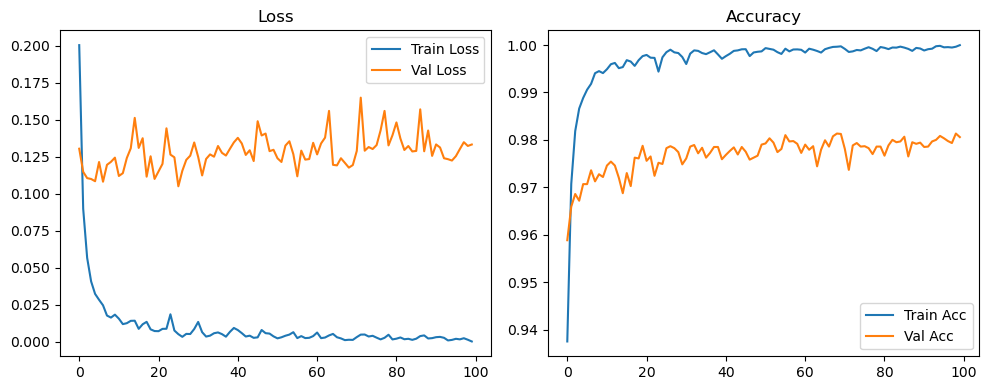

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2227, Acc: 0.9296 | Val Loss: 0.1222, Acc: 0.9639


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1085, Acc: 0.9657 | Val Loss: 0.1104, Acc: 0.9673


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0763, Acc: 0.9756 | Val Loss: 0.1062, Acc: 0.9689


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0573, Acc: 0.9810 | Val Loss: 0.1021, Acc: 0.9698


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9852 | Val Loss: 0.1006, Acc: 0.9714


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9878 | Val Loss: 0.1047, Acc: 0.9720


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0348, Acc: 0.9886 | Val Loss: 0.1040, Acc: 0.9736


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9898 | Val Loss: 0.1020, Acc: 0.9740


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.0941, Acc: 0.9756


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.1019, Acc: 0.9746


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9926 | Val Loss: 0.1234, Acc: 0.9710


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.1045, Acc: 0.9752


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.1051, Acc: 0.9760


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9936 | Val Loss: 0.1077, Acc: 0.9755


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9941 | Val Loss: 0.1034, Acc: 0.9779


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1239, Acc: 0.9759


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9934 | Val Loss: 0.1097, Acc: 0.9761


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1112, Acc: 0.9753


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1159, Acc: 0.9757


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.0999, Acc: 0.9788


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.1150, Acc: 0.9760


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1113, Acc: 0.9781


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1149, Acc: 0.9762


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1138, Acc: 0.9777


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1202, Acc: 0.9771


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1299, Acc: 0.9750


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.1089, Acc: 0.9779


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1232, Acc: 0.9773


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1234, Acc: 0.9768


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1324, Acc: 0.9762


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1108, Acc: 0.9778


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1103, Acc: 0.9782


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1282, Acc: 0.9782


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1068, Acc: 0.9789


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1217, Acc: 0.9776


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1098, Acc: 0.9788


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1149, Acc: 0.9798


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1132, Acc: 0.9770


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1075, Acc: 0.9804


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1231, Acc: 0.9781


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1149, Acc: 0.9782


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1110, Acc: 0.9795


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1076, Acc: 0.9796


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1165, Acc: 0.9796


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.1210, Acc: 0.9775


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1211, Acc: 0.9782


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1259, Acc: 0.9768


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1260, Acc: 0.9777


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1313, Acc: 0.9774


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1126, Acc: 0.9797


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1056, Acc: 0.9810


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1172, Acc: 0.9792


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1077, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1291, Acc: 0.9784


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1141, Acc: 0.9802


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1178, Acc: 0.9791


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1212, Acc: 0.9792


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1230, Acc: 0.9791


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1332, Acc: 0.9773


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1269, Acc: 0.9779


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1229, Acc: 0.9798


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1202, Acc: 0.9800


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1173, Acc: 0.9805


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1181, Acc: 0.9800


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1170, Acc: 0.9795


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1428, Acc: 0.9774


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1297, Acc: 0.9806


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1244, Acc: 0.9792


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1303, Acc: 0.9784


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1250, Acc: 0.9788


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1292, Acc: 0.9795


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1402, Acc: 0.9772


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1408, Acc: 0.9776


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1409, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1482, Acc: 0.9765


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9980 | Val Loss: 0.1437, Acc: 0.9763


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1261, Acc: 0.9792


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1287, Acc: 0.9801


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1393, Acc: 0.9797


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1358, Acc: 0.9793


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1276, Acc: 0.9788


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1222, Acc: 0.9807


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1254, Acc: 0.9811


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1284, Acc: 0.9811


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1421, Acc: 0.9783


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1386, Acc: 0.9788


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1391, Acc: 0.9766


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1208, Acc: 0.9808


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1239, Acc: 0.9780


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1231, Acc: 0.9793


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1081, Acc: 0.9803


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1105, Acc: 0.9803


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1107, Acc: 0.9814


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1162, Acc: 0.9794


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1079, Acc: 0.9799


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1057, Acc: 0.9819


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1076, Acc: 0.9802


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1097, Acc: 0.9805


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1196, Acc: 0.9806


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1208, Acc: 0.9788


Final Test Loss: 0.1203 Accuracy: 0.9816


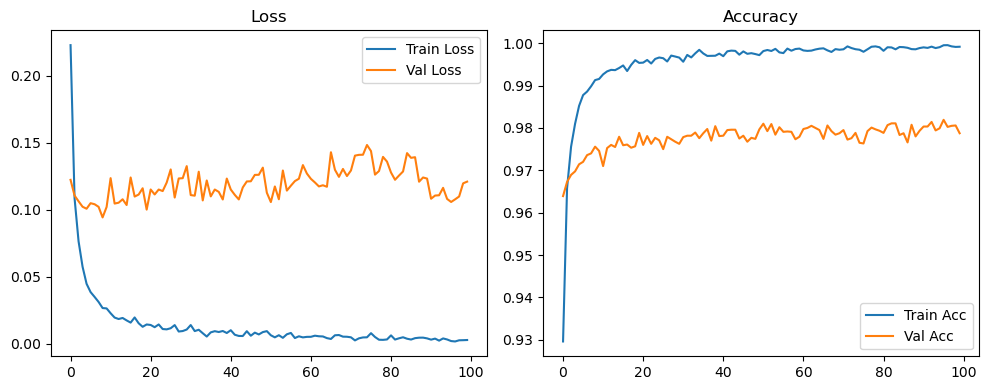

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3006, Acc: 0.9064 | Val Loss: 0.1544, Acc: 0.9545


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1628, Acc: 0.9497 | Val Loss: 0.1212, Acc: 0.9624


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1278, Acc: 0.9604 | Val Loss: 0.0980, Acc: 0.9686


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1035, Acc: 0.9666 | Val Loss: 0.1034, Acc: 0.9696


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0946, Acc: 0.9695 | Val Loss: 0.0932, Acc: 0.9720


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0816, Acc: 0.9731 | Val Loss: 0.0880, Acc: 0.9737


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0756, Acc: 0.9758 | Val Loss: 0.0872, Acc: 0.9748


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0669, Acc: 0.9786 | Val Loss: 0.0988, Acc: 0.9738


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0623, Acc: 0.9796 | Val Loss: 0.0864, Acc: 0.9758


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0595, Acc: 0.9806 | Val Loss: 0.0881, Acc: 0.9751


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0567, Acc: 0.9812 | Val Loss: 0.0900, Acc: 0.9756


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0504, Acc: 0.9831 | Val Loss: 0.0950, Acc: 0.9750


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9846 | Val Loss: 0.0876, Acc: 0.9769


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9834 | Val Loss: 0.0868, Acc: 0.9770


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0422, Acc: 0.9859 | Val Loss: 0.0815, Acc: 0.9777


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0427, Acc: 0.9858 | Val Loss: 0.0913, Acc: 0.9768


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0382, Acc: 0.9870 | Val Loss: 0.0873, Acc: 0.9769


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9885 | Val Loss: 0.0899, Acc: 0.9786


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9896 | Val Loss: 0.0904, Acc: 0.9769


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9894 | Val Loss: 0.0890, Acc: 0.9797


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0922, Acc: 0.9785


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0838, Acc: 0.9803


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9899 | Val Loss: 0.0889, Acc: 0.9784


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9908 | Val Loss: 0.0930, Acc: 0.9775


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9911 | Val Loss: 0.0899, Acc: 0.9786


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.0890, Acc: 0.9797


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0299, Acc: 0.9904 | Val Loss: 0.0899, Acc: 0.9792


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9917 | Val Loss: 0.1019, Acc: 0.9775


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0241, Acc: 0.9918 | Val Loss: 0.0994, Acc: 0.9779


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.0995, Acc: 0.9788


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9915 | Val Loss: 0.0923, Acc: 0.9807


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9927 | Val Loss: 0.0970, Acc: 0.9785


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 0.0982, Acc: 0.9803


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.0874, Acc: 0.9806


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.0921, Acc: 0.9798


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9929 | Val Loss: 0.0980, Acc: 0.9793


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9926 | Val Loss: 0.0914, Acc: 0.9808


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.0932, Acc: 0.9796


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.0988, Acc: 0.9792


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9939 | Val Loss: 0.0909, Acc: 0.9802


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.0981, Acc: 0.9796


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0920, Acc: 0.9791


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9944 | Val Loss: 0.0906, Acc: 0.9805


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0958, Acc: 0.9803


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0910, Acc: 0.9805


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.1008, Acc: 0.9789


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1016, Acc: 0.9802


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1018, Acc: 0.9792


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9950 | Val Loss: 0.0852, Acc: 0.9810


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0934, Acc: 0.9799


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0893, Acc: 0.9820


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0888, Acc: 0.9804


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0997, Acc: 0.9796


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9954 | Val Loss: 0.0956, Acc: 0.9812


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.0893, Acc: 0.9810


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.0914, Acc: 0.9800


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0955, Acc: 0.9804


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.0914, Acc: 0.9807


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0915, Acc: 0.9802


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0906, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.0903, Acc: 0.9799


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.0926, Acc: 0.9795


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0913, Acc: 0.9798


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.0909, Acc: 0.9804


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0872, Acc: 0.9809


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0858, Acc: 0.9820


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0882, Acc: 0.9810


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0939, Acc: 0.9806


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0892, Acc: 0.9813


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0934, Acc: 0.9815


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0857, Acc: 0.9816


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0851, Acc: 0.9812


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0919, Acc: 0.9801


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0905, Acc: 0.9815


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0875, Acc: 0.9808


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0928, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0907, Acc: 0.9812


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9972 | Val Loss: 0.0943, Acc: 0.9808


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0957, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9963 | Val Loss: 0.0941, Acc: 0.9806


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0912, Acc: 0.9810


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0855, Acc: 0.9815


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0913, Acc: 0.9822


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0852, Acc: 0.9808


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0896, Acc: 0.9808


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0925, Acc: 0.9814


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0977, Acc: 0.9805


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0931, Acc: 0.9813


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0912, Acc: 0.9812


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0847, Acc: 0.9822


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0925, Acc: 0.9811


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0949, Acc: 0.9823


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.0977, Acc: 0.9811


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1001, Acc: 0.9810


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0998, Acc: 0.9805


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0960, Acc: 0.9803


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1005, Acc: 0.9807


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.0996, Acc: 0.9799


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.0910, Acc: 0.9818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1003, Acc: 0.9811


Final Test Loss: 0.0786 Accuracy: 0.9836


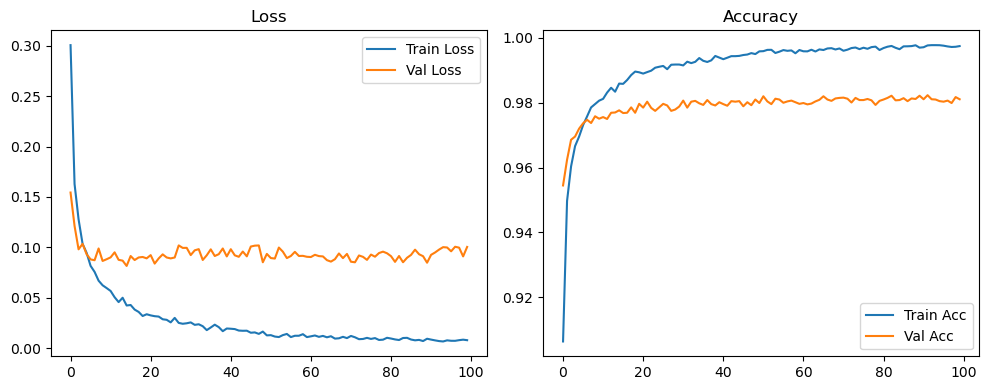

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1918, Acc: 0.9399 | Val Loss: 0.1203, Acc: 0.9633


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0755, Acc: 0.9760 | Val Loss: 0.1258, Acc: 0.9607


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9837 | Val Loss: 0.1140, Acc: 0.9663


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.1152, Acc: 0.9665


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9913 | Val Loss: 0.1097, Acc: 0.9713


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9920 | Val Loss: 0.1080, Acc: 0.9702


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.1059, Acc: 0.9742


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1023, Acc: 0.9751


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9936 | Val Loss: 0.1050, Acc: 0.9746


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1179, Acc: 0.9718


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9959 | Val Loss: 0.1203, Acc: 0.9714


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1121, Acc: 0.9755


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9961 | Val Loss: 0.1190, Acc: 0.9734


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1093, Acc: 0.9757


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1175, Acc: 0.9747


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1121, Acc: 0.9754


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1070, Acc: 0.9765


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1293, Acc: 0.9738


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1324, Acc: 0.9720


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.1227, Acc: 0.9744


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1314, Acc: 0.9741


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1228, Acc: 0.9748


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1211, Acc: 0.9762


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1304, Acc: 0.9736


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9971 | Val Loss: 0.1196, Acc: 0.9765


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1180, Acc: 0.9768


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1242, Acc: 0.9764


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1267, Acc: 0.9772


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1042, Acc: 0.9776


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1191, Acc: 0.9763


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.1309, Acc: 0.9750


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1192, Acc: 0.9769


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1098, Acc: 0.9797


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1179, Acc: 0.9793


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1234, Acc: 0.9772


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1129, Acc: 0.9776


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1377, Acc: 0.9769


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.1389, Acc: 0.9746


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1283, Acc: 0.9768


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1121, Acc: 0.9782


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1187, Acc: 0.9792


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1195, Acc: 0.9802


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1278, Acc: 0.9776


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1346, Acc: 0.9758


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1259, Acc: 0.9779


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1176, Acc: 0.9788


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1247, Acc: 0.9774


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1280, Acc: 0.9779


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1233, Acc: 0.9782


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1215, Acc: 0.9782


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1295, Acc: 0.9777


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1176, Acc: 0.9791


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1132, Acc: 0.9804


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1116, Acc: 0.9822


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1213, Acc: 0.9792


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1328, Acc: 0.9778


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1528, Acc: 0.9738


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1539, Acc: 0.9757


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1396, Acc: 0.9758


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1435, Acc: 0.9757


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1414, Acc: 0.9769


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1301, Acc: 0.9798


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1413, Acc: 0.9768


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1332, Acc: 0.9780


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1260, Acc: 0.9789


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1224, Acc: 0.9783


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1237, Acc: 0.9795


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1398, Acc: 0.9778


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.1771, Acc: 0.9728


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9973 | Val Loss: 0.1216, Acc: 0.9783


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1223, Acc: 0.9772


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.1129, Acc: 0.9800


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1162, Acc: 0.9798


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1131, Acc: 0.9800


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1256, Acc: 0.9790


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1431, Acc: 0.9758


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1446, Acc: 0.9768


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1697, Acc: 0.9738


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.1436, Acc: 0.9761


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1260, Acc: 0.9784


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1182, Acc: 0.9802


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1256, Acc: 0.9799


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1286, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.1238, Acc: 0.9793


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1268, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1258, Acc: 0.9800


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1635, Acc: 0.9764


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1469, Acc: 0.9770


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1352, Acc: 0.9788


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1195, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1226, Acc: 0.9805


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9997 | Val Loss: 0.1306, Acc: 0.9785


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1279, Acc: 0.9797


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.1312, Acc: 0.9782


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1544, Acc: 0.9756


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1275, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1254, Acc: 0.9810


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1321, Acc: 0.9793


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1489, Acc: 0.9799


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1377, Acc: 0.9784


Final Test Loss: 0.1495 Accuracy: 0.9801


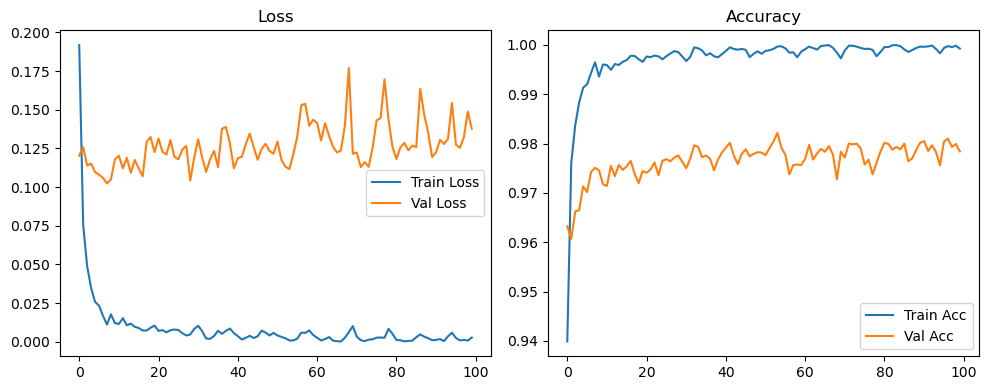

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2257, Acc: 0.9295 | Val Loss: 0.1159, Acc: 0.9636


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0987, Acc: 0.9682 | Val Loss: 0.1143, Acc: 0.9650


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9780 | Val Loss: 0.1001, Acc: 0.9692


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9832 | Val Loss: 0.1052, Acc: 0.9698


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9861 | Val Loss: 0.0981, Acc: 0.9728


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0346, Acc: 0.9884 | Val Loss: 0.0935, Acc: 0.9732


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9901 | Val Loss: 0.1072, Acc: 0.9718


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9910 | Val Loss: 0.1085, Acc: 0.9703


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.1012, Acc: 0.9747


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9929 | Val Loss: 0.1075, Acc: 0.9742


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1086, Acc: 0.9743


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1088, Acc: 0.9742


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9947 | Val Loss: 0.1033, Acc: 0.9764


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1020, Acc: 0.9763


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1001, Acc: 0.9768


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1224, Acc: 0.9728


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1017, Acc: 0.9772


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1147, Acc: 0.9734


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1061, Acc: 0.9765


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1063, Acc: 0.9766


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1074, Acc: 0.9768


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1060, Acc: 0.9768


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9954 | Val Loss: 0.1124, Acc: 0.9767


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1234, Acc: 0.9742


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1165, Acc: 0.9759


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1075, Acc: 0.9775


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1107, Acc: 0.9783


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1035, Acc: 0.9778


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1116, Acc: 0.9767


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1297, Acc: 0.9748


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1287, Acc: 0.9757


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1155, Acc: 0.9774


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1194, Acc: 0.9774


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1231, Acc: 0.9766


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1239, Acc: 0.9759


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1163, Acc: 0.9774


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1162, Acc: 0.9759


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1132, Acc: 0.9765


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1220, Acc: 0.9774


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1054, Acc: 0.9793


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1176, Acc: 0.9767


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1174, Acc: 0.9777


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1141, Acc: 0.9798


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1156, Acc: 0.9782


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1147, Acc: 0.9785


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1185, Acc: 0.9787


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1165, Acc: 0.9786


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1124, Acc: 0.9791


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1219, Acc: 0.9792


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1259, Acc: 0.9784


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1320, Acc: 0.9788


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1333, Acc: 0.9771


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1240, Acc: 0.9779


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1157, Acc: 0.9804


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1147, Acc: 0.9797


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1194, Acc: 0.9787


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1220, Acc: 0.9786


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1262, Acc: 0.9778


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1328, Acc: 0.9776


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1243, Acc: 0.9781


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1299, Acc: 0.9779


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1353, Acc: 0.9763


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1331, Acc: 0.9778


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1135, Acc: 0.9803


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1338, Acc: 0.9776


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1227, Acc: 0.9809


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1361, Acc: 0.9772


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1193, Acc: 0.9797


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1367, Acc: 0.9778


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1342, Acc: 0.9778


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1318, Acc: 0.9779


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1172, Acc: 0.9798


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1158, Acc: 0.9801


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1231, Acc: 0.9800


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.1187, Acc: 0.9802


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1324, Acc: 0.9784


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1276, Acc: 0.9790


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1301, Acc: 0.9799


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1332, Acc: 0.9793


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1325, Acc: 0.9784


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1256, Acc: 0.9808


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1391, Acc: 0.9768


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1288, Acc: 0.9795


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1209, Acc: 0.9796


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1267, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1375, Acc: 0.9794


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1326, Acc: 0.9785


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1400, Acc: 0.9781


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1278, Acc: 0.9795


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1388, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1289, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1299, Acc: 0.9798


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1190, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1172, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1200, Acc: 0.9813


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1224, Acc: 0.9800


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1183, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1250, Acc: 0.9809


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1357, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1371, Acc: 0.9787


Final Test Loss: 0.1272 Accuracy: 0.9801


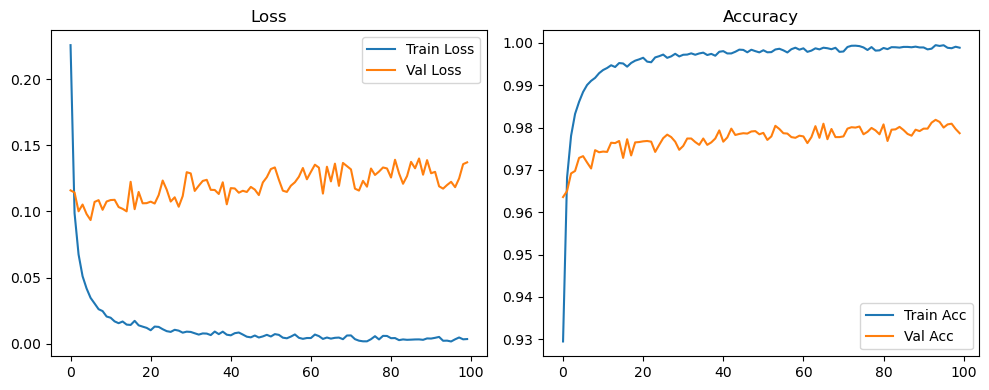

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3322, Acc: 0.8965 | Val Loss: 0.1471, Acc: 0.9556


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1621, Acc: 0.9494 | Val Loss: 0.1175, Acc: 0.9643


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1239, Acc: 0.9611 | Val Loss: 0.1001, Acc: 0.9692


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1042, Acc: 0.9664 | Val Loss: 0.1002, Acc: 0.9692


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0920, Acc: 0.9698 | Val Loss: 0.0907, Acc: 0.9718


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0825, Acc: 0.9726 | Val Loss: 0.0867, Acc: 0.9734


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0709, Acc: 0.9770 | Val Loss: 0.0887, Acc: 0.9733


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0631, Acc: 0.9801 | Val Loss: 0.0916, Acc: 0.9732


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0633, Acc: 0.9787 | Val Loss: 0.0891, Acc: 0.9745


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0572, Acc: 0.9810 | Val Loss: 0.0821, Acc: 0.9752


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0542, Acc: 0.9812 | Val Loss: 0.0864, Acc: 0.9748


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9834 | Val Loss: 0.0888, Acc: 0.9755


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9849 | Val Loss: 0.0856, Acc: 0.9757


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9855 | Val Loss: 0.0834, Acc: 0.9779


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9868 | Val Loss: 0.0853, Acc: 0.9772


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9869 | Val Loss: 0.0859, Acc: 0.9770


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0384, Acc: 0.9864 | Val Loss: 0.0883, Acc: 0.9765


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9876 | Val Loss: 0.0858, Acc: 0.9782


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9881 | Val Loss: 0.0880, Acc: 0.9752


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9879 | Val Loss: 0.0832, Acc: 0.9784


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.0900, Acc: 0.9778


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0306, Acc: 0.9896 | Val Loss: 0.0843, Acc: 0.9784


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9903 | Val Loss: 0.0834, Acc: 0.9787


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9902 | Val Loss: 0.0903, Acc: 0.9775


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9904 | Val Loss: 0.0867, Acc: 0.9799


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.0847, Acc: 0.9796


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9912 | Val Loss: 0.0875, Acc: 0.9788


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0257, Acc: 0.9912 | Val Loss: 0.0883, Acc: 0.9800


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.0860, Acc: 0.9789


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9925 | Val Loss: 0.0935, Acc: 0.9785


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0868, Acc: 0.9797


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9921 | Val Loss: 0.0867, Acc: 0.9788


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9928 | Val Loss: 0.0915, Acc: 0.9802


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9934 | Val Loss: 0.0945, Acc: 0.9783


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9933 | Val Loss: 0.0908, Acc: 0.9792


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0994, Acc: 0.9793


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.0960, Acc: 0.9797


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9929 | Val Loss: 0.0888, Acc: 0.9805


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.0872, Acc: 0.9797


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1000, Acc: 0.9772


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0956, Acc: 0.9782


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.0912, Acc: 0.9806


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9938 | Val Loss: 0.0881, Acc: 0.9803


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0173, Acc: 0.9943 | Val Loss: 0.0994, Acc: 0.9792


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0941, Acc: 0.9802


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.0961, Acc: 0.9785


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.0920, Acc: 0.9802


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0932, Acc: 0.9804


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0886, Acc: 0.9798


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.0901, Acc: 0.9808


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.0902, Acc: 0.9813


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0952, Acc: 0.9802


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0974, Acc: 0.9802


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1025, Acc: 0.9795


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9943 | Val Loss: 0.0919, Acc: 0.9808


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9951 | Val Loss: 0.0977, Acc: 0.9787


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9963 | Val Loss: 0.0957, Acc: 0.9805


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9958 | Val Loss: 0.1004, Acc: 0.9792


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9959 | Val Loss: 0.0974, Acc: 0.9797


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0973, Acc: 0.9796


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0971, Acc: 0.9798


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1031, Acc: 0.9783


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0942, Acc: 0.9800


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0973, Acc: 0.9810


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0925, Acc: 0.9804


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9960 | Val Loss: 0.1025, Acc: 0.9797


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.0948, Acc: 0.9816


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0992, Acc: 0.9801


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0979, Acc: 0.9811


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1011, Acc: 0.9803


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0987, Acc: 0.9798


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0991, Acc: 0.9810


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0988, Acc: 0.9806


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0971, Acc: 0.9802


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0982, Acc: 0.9812


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9970 | Val Loss: 0.1044, Acc: 0.9799


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.0982, Acc: 0.9813


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1014, Acc: 0.9808


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0973, Acc: 0.9808


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1012, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1026, Acc: 0.9805


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.0996, Acc: 0.9809


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0989, Acc: 0.9807


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1023, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0996, Acc: 0.9811


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0997, Acc: 0.9797


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0996, Acc: 0.9807


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1015, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1065, Acc: 0.9802


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1043, Acc: 0.9814


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1064, Acc: 0.9807


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.1072, Acc: 0.9810


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1028, Acc: 0.9805


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1089, Acc: 0.9799


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1046, Acc: 0.9792


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1037, Acc: 0.9811


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1018, Acc: 0.9797


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1074, Acc: 0.9799


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1043, Acc: 0.9807


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1079, Acc: 0.9806


Final Test Loss: 0.0949 Accuracy: 0.9826


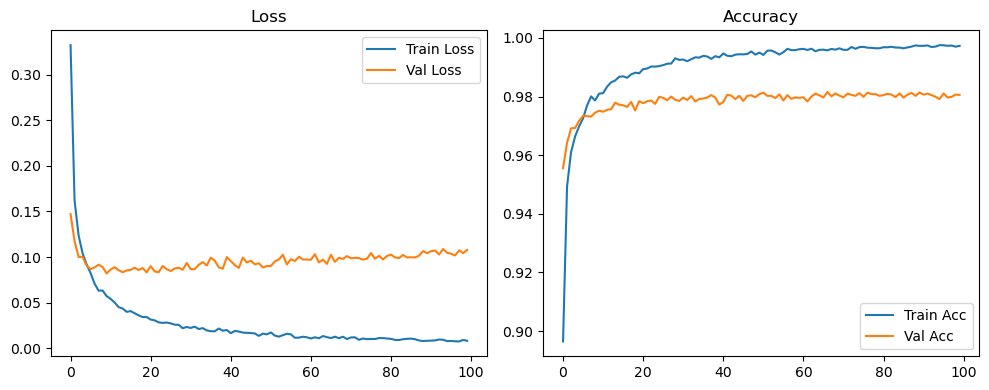

🏆 Best Config: batch128_lr0.005_0.002_0.001_dp0.2 Accuracy: 0.9847


In [8]:
root_path = "MLP_1024_4bit_regular_ReLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)